## Implementations of Q-iteration and Q-learning

In [1]:
import numpy as np

# This function performs Q_iteration, based on Bellman optimality equation. It's an iterative update of the Q function. The input
# parameters are the discount factor gamma, the number of iterations epochs and the reward matrix R. P corresponds to the 
# probability of having a broken robot, thus staying to the same state with probability P. The function returns the 
# converged Q-function. Convergence is assured by comparison to the previous iteration Q-function.
def Q_iteration(gamma, epochs, R, P=None):
    if P == None:
        P = 0
    Q = np.zeros_like(R)
    Q_next = np.zeros_like(Q)
    
    # iterate for all states and all actions
    for ii in range(epochs):
        for s in range(Q.shape[1]):
            #  if it's a terminal state continue
            if s==0 or s==5:
                    continue
            for a in range(Q.shape[0]):
                # perform the update
                Q_next[a,s] = R[a,s] + gamma * np.amax([(1-P) * Q[:, 2*a - 1 + s] +  P * Q[:,s]])
        
        # compare to the value of the previous iteration and break if converged
        # uncomment following line if you want the algorithm to stop when converged
        if np.linalg.norm(Q-Q_next) < 1e-8:
            break
            
        #update the value for the next iteration 
        #print(Q)
        Q = np.array(Q_next, copy = True)
        
    Q = np.array(Q_next, copy = True)
    return(Q)           
    

# The implementation of Q_learning algorithm. The input parameters are the discount factor gamma, the learning rate alpha, the 
# parameter epsilon of greedy research, the number of iterations epochs and the reward matrix R. P corresponds to the 
# probability of having a broken robot, thus staying to the same state with probability P.
def Q_learning(gamma, alpha, epsilon, epochs, R, Q_star, P = None):
    #if epochs_checkpoints == None:
    #epochs_checkpoints = epochs
    Q_check = np.zeros(epochs)
    std_Q_check = np.zeros_like(Q_check)
    c = 0
    
    if P == None:
        P = 0
    Q = np.zeros_like(R)
    Q_next = np.zeros_like(Q)
    
    n_states = Q.shape[1] - 1
    end_state = False
    
    # iterate for the set number of epochs
    for ii in range(epochs):
        # set an arbitrary initial state. Continue if the initial state is also a terminal state.
        s = np.rint(n_states * np.random.rand()).astype(int)
        if s==0 or s==5:
            Q_check[ii] = Q_check[ii-1] 
            continue
            
        LL = []
        # each episode include a number of steps updating the Q-function until the agent reaches a terminal state, when the
        # running episode ends and we move to the next iteration
        while(not end_state):
            # set current Q function to the value extracted from the previous iteration.
            Q = np.array(Q_next, copy = True)
            

            # Apply ε-greedy research. The second condition applies for the case of multiple occurences of the max value.
            # Withoout this condition the first occurence would always be returned, meaning that always the agent would take
            # the action left
            t = np.random.rand()
            if t<epsilon or (Q[:,s] == np.amax(Q[:, s]) * np.ones_like(Q[:,s])).all():
                a = np.rint(np.random.rand()).astype(int)
            else:
                a = np.argmax([Q[:,s]])
                
            LL.append(np.linalg.norm(Q-Q_star))
        
            # Determine the next state based on action a. Then update the Q function.
            # If we get a reward for ending up in a terminal state set end_state to true and continue with the next epoch
            s_next = 2*a - 1 + s
            Q_next[a,s] =  Q[a,s] + alpha * (R[a,s] + gamma * np.amax([(1-P)*Q[:,s_next] + P*Q[:, s]]) - Q[a,s])
            #Q_next[a,s] = Q[a,s] + alpha/(ii+1) * (R[a,s] + gamma * max(Q[:,s_next]) - Q[a,s])
            if R[a,s]>0:
                end_state = True   
            s = s_next    
        end_state = False
        
        LL.append(np.linalg.norm(Q_star - Q_next))
        Q_check[ii] = np.mean(np.array(LL, copy = True))
        std_Q_check[ii] = np.std(np.array(LL, copy = True))
        
                                       
    Q = np.array(Q_next, copy = True)
    #Q_check[c,:,:] = np.array(Q, copy = True)
    
    return Q_check, std_Q_check

[[0.         1.17647059 0.48442907 0.71239568 1.73010381 0.        ]
 [0.         0.41067516 0.99735396 2.42214533 5.88235294 0.        ]]


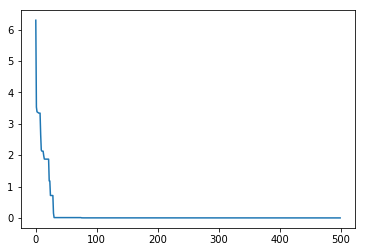

In [9]:
epochs = 500
gamma = 0.5
alpha = 1
epsilon = 0.3
QQ = Q_iteration(gamma, epochs, R, P=0.3)
print(QQ)
QQQ, _ = Q_learning(gamma, alpha, epsilon, epochs, R, QQ, P = 0.3)
plt.figure()
plt.plot(np.arange(epochs), QQQ)

In [4]:
epochs = 1000
gamma = 0.5

Q = np.zeros((2,6))
R = np.zeros_like(Q)
R[0,1] = 1
R[1,4] = 5

QQ = Q_iteration(gamma, 1000, R, 0)
print(np.round(QQ, 6))

[[0.    1.    0.5   0.625 1.25  0.   ]
 [0.    0.625 1.25  2.5   5.    0.   ]]


In [58]:
QQ = Q_learning(gamma, 0.1,  0, 12000, R, 0)
print(QQ)

[[0.    1.    0.5   0.625 1.25  0.   ]
 [0.    0.625 1.25  2.5   5.    0.   ]]


## Visualizations 

In [8]:
from matplotlib import pyplot as plt

def divQlearn_alpha(Q_star, gamma, alpha, epsilon, epochs, rep, R, P):
    
    fig = plt.figure(figsize = (10,5))
    aa = np.arange(epochs)
    for a in alpha:
        L2diff = np.zeros((rep, epochs))
        for i in range(rep):
            L2diff[i,:], _ = Q_learning(gamma, a, epsilon, epochs, R, Q_star, P)

        mean_L2diff = np.mean(L2diff, axis = 0)
        std_L2diff = np.std(L2diff, axis = 0)

        plt.fill_between(aa, mean_L2diff - std_L2diff,
                             mean_L2diff + std_L2diff, alpha=0.1)
        plt.plot(aa, mean_L2diff)
    
    plt.title('L2-norm difference berween Q-learning and groundtruth')
    plt.xlabel("Number of interactions - epochs")
    plt.ylabel("L2-norm difference")
    plt.grid()
    plt.legend(['a=1', 'a=0.1', 'a=0.01', 'a=0.001'], loc="best")
    
    
def divQlearn_epsilon(Q_star, gamma, alpha, epsilon, epochs, rep, R, P):
    
    fig = plt.figure(figsize = (10,5))
    aa = np.arange(epochs)
    for e in epsilon:
        L2diff = np.zeros((rep, epochs))
        for i in range(rep):
            L2diff[i,:], _ = Q_learning(gamma, alpha, e, epochs, R, Q_star, P)

        mean_L2diff = np.mean(L2diff, axis = 0)
        std_L2diff = np.std(L2diff, axis = 0)

        plt.fill_between(aa, mean_L2diff - std_L2diff,
                             mean_L2diff + std_L2diff, alpha=0.1)
        plt.plot(aa, mean_L2diff)
    
    plt.title('L2-norm difference berween Q-learning and groundtruth')
    plt.xlabel("Number of interactions - epochs")
    plt.ylabel("L2-norm difference")
    plt.grid()
    plt.legend(['e=0', 'e=0.1', 'e=0.2', 'e=0.3', 'e=0.5', 'e=1'], loc="best")
    
def divQRBF_alpha(Q_star, gamma, alpha, epsilon, epochs, rep, mean_g, sigma_g, c_i, sigma):
    fig = plt.figure(figsize = (10,5))
    aa = np.arange(epochs)
    for a in alpha:
        L2diff = np.zeros((rep, epochs))
        for i in range(rep):
            _, L2diff[i,:], _ = Q_learning_RBF(epochs, a, gamma, epsilon, Q_star, mean_g, sigma_g, c_i, sigma) 
            
        mean_L2diff = np.mean(L2diff, axis = 0)
        std_L2diff = np.std(L2diff, axis = 0)

        plt.fill_between(aa, mean_L2diff - std_L2diff,
                             mean_L2diff + std_L2diff, alpha=0.1)
        plt.plot(aa, mean_L2diff)
    
    plt.title('L2-norm difference berween Q-learning and groundtruth - fixed epsilon')
    plt.xlabel("Number of interactions - epochs")
    plt.ylabel("L2-norm difference")
    plt.grid()
    plt.legend(['a=1', 'a=0.1', 'a=0.01', 'e=0.001'], loc="best")
    
def divQRBF_epsilon(Q_star, gamma, alpha, epsilon, epochs, rep, mean_g, sigma_g, c_i, sigma):
    fig = plt.figure(figsize = (10,5))
    aa = np.arange(epochs)
    for e in epsilon:
        L2diff = np.zeros((rep, epochs))
        for i in range(rep):
            _, L2diff[i,:], _ = Q_learning_RBF(epochs, alpha, gamma, e, Q_star, mean_g, sigma_g, c_i, sigma) 
            
        mean_L2diff = np.mean(L2diff, axis = 0)
        std_L2diff = np.std(L2diff, axis = 0)

        plt.fill_between(aa, mean_L2diff - std_L2diff,
                             mean_L2diff + std_L2diff, alpha=0.1)
        plt.plot(aa, mean_L2diff)
    
    plt.title('L2-norm difference between Q-learning and groundtruth - fixed alpha')
    plt.xlabel("Number of interactions - epochs")
    plt.ylabel("L2-norm difference")
    plt.grid()
    plt.legend(['e=1', 'e=0.5', 'e=0.1', 'e=0.3', 'e=0.5', 'e=1'], loc="best")
    

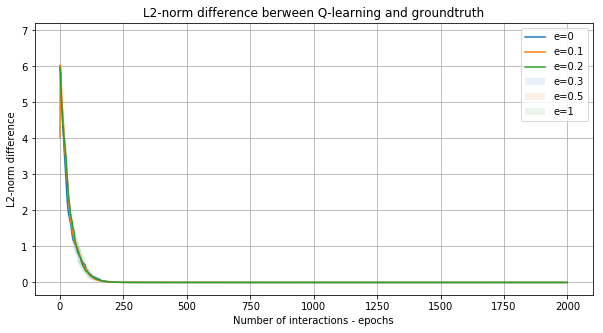

In [344]:
epochs = 2000
epsilon = np.array([1,0.5,0.1])
alpha = 0.1
#alpha = np.array([1,0.1,0.01])
divQlearn_epsilon(Q_star, gamma, alpha, epsilon, epochs, 3, R, 0)

### L2 diff vs epochs - fixed epsilon

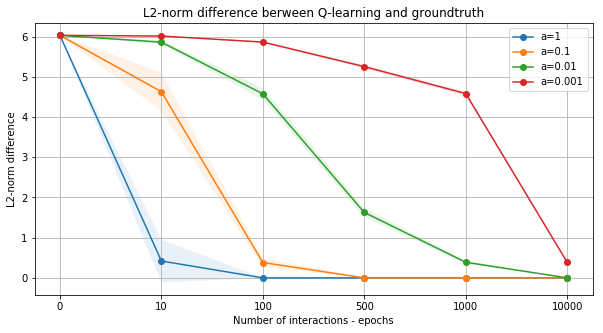

In [243]:
epochs_checkpoints = np.array([0, 10, 100, 500, 1000, 10000])
epochs = 10001
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0
rep = 20

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, epochs_checkpoints, 0)

In [126]:
epochs = np.array([0, 10, 100, 500, 1000, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0.1
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

TypeError: divQlearn_alpha() missing 1 required positional argument: 'P'

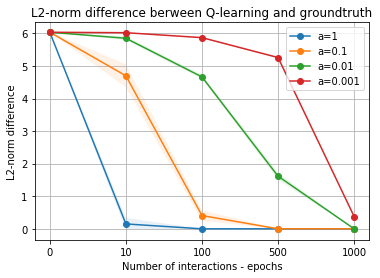

In [84]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0.2
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

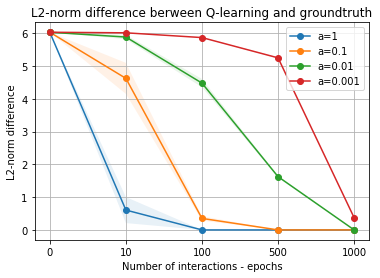

In [87]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0.3
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

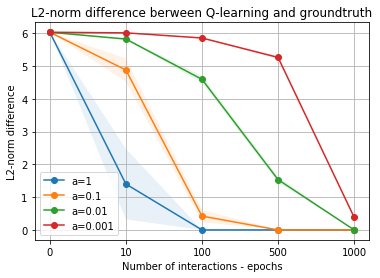

In [85]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0.5
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

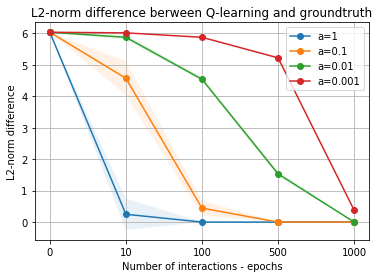

In [86]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 1
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

### L2 diff vs epochs - fixed alpha

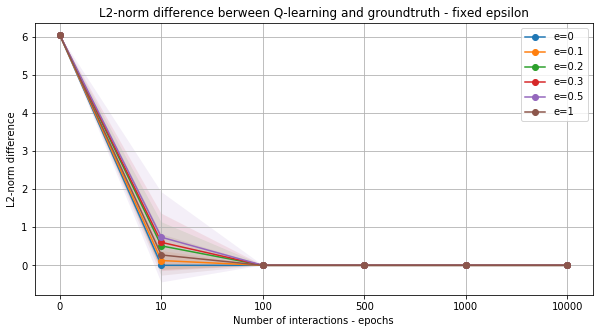

In [6]:
epochs_checkpoints = np.array([0, 10, 100, 500, 1000, 10000])
epochs = 10001
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = 1
epsilon = [0,0.1,0.2,0.3,0.5,1]
rep = 5

divQlearn_epsilon(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

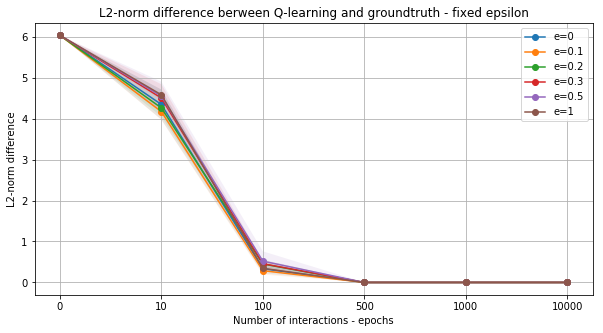

In [7]:
epochs_checkpoints = np.array([0, 10, 100, 500, 1000, 10000])
epochs = 10001
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = 0.1
epsilon = [0,0.1,0.2,0.3,0.5,1]
rep = 5

divQlearn_epsilon(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

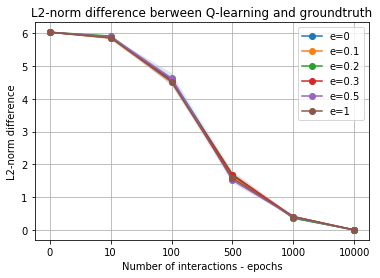

In [92]:
epochs_checkpoints = np.array([0, 10, 100, 500, 1000, 10000])
epochs = 10001
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = 0.01
epsilon = [0,0.1,0.2,0.3,0.5,1]
rep = 5

divQlearn_epsilon(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

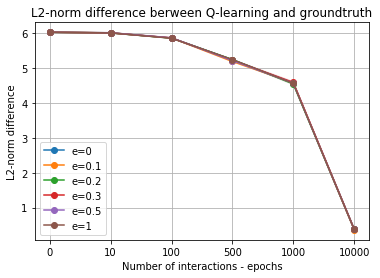

In [93]:
epochs_checkpoints = np.array([0, 10, 100, 500, 1000, 10000])
epochs = 10001
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = 0.001
epsilon = [0,0.1,0.2,0.3,0.5,1]
rep = 5

divQlearn_epsilon(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

### Stochastic transitions

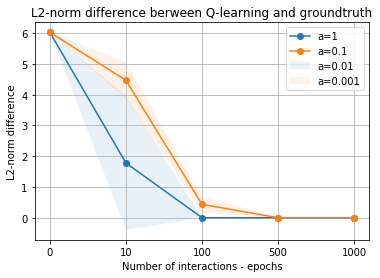

In [99]:
epochs_checkpoints = np.array([0, 10, 100, 500, 1000, 10000])
epochs = 10001
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1]
epsilon = 0
rep = 5

divQlearn_alpha(Q_star, gamma, alpha, epsilon, epochs, rep, R, 0.3)

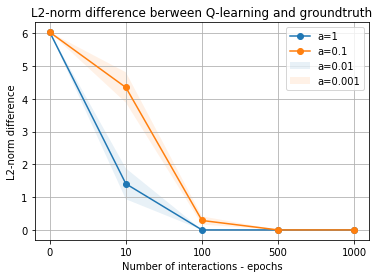

In [108]:
epochs_checkpoints = np.array([0, 10, 100, 500, 1000, 10000])
epochs = 10001
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1]
epsilon = 0.8
rep = 5

divQlearn(Q_star, gamma, alpha, epsilon, epochs, rep, R, 0.3)

In [6]:

epochs = 1000
gamma = 0.5

Q = np.zeros((2,6))
Q_next = np.zeros_like(Q)
R = np.zeros_like(Q)
R[0,1] = 1
R[1,4] = 5
c = 0

for ii in range(epochs):
    c+=1
    for s in range(Q.shape[1]):
        if s==0 or s==5:
                continue
        for a in range(Q.shape[0]):
            Q_next[a,s] = R[a,s] + gamma * max(Q[:, 2*a - 1 + s])
    if np.linalg.norm(Q-Q_next) < 1e-16:
        break
    Q = np.array(Q_next, copy = True)
            
Q = Q_next        
#print(Q)
#print(c)

NameError: name 'np' is not defined

In [147]:
QQ = Q_iteration(gamma, epochs, R, 0.3)
print(QQ)

[[0.     1.     0.725  1.1875 2.375  0.    ]
 [0.     0.7375 1.25   2.5    5.     0.    ]]


## Q-learning

In [56]:
# Implementation of Q-learning
import numpy as np

# Initialize the discount factor gamma, the learning rate alpha, the parameter for ε-greedy epsilon and the number of iterations
# for the Q-learning algorithm epochs
gamma = 0.5
alpha = 0.1
epsilon = 0.1
epochs = 10000 
P = 0

Q = np.zeros((2,6))
Q_next = np.zeros_like(Q)
R = np.zeros_like(Q)
R[0,1] = 1
R[1,4] = 5
n_states = Q.shape[1] - 1
end_state = False


for ii in range(epochs):
    # set an arbitrary initial state. Continue if the initial state is also a terminal state.
    s = np.rint(n_states * np.random.rand()).astype(int)
    if s==0 or s==5:
            continue
    while(not end_state):
        # set current Q function to the value extracted from the previous iteration.
        Q = np.array(Q_next, copy = True)

        # Apply ε-greedy research. The second condition applies for the case of multiple occurences of the max value.
        # Withoout this condition the first occurence would always be returned, meaning that always the agent would take
        # the action left
        t = np.random.rand()
        if t<epsilon or (Q[:,s] == np.amax(Q[:, s]) * np.ones_like(Q[:,s])).all:
            a = np.rint(np.random.rand()).astype(int)
        else:
            a = np.argmax([Q[:,s]])
            
            
        
        # Determine the next state based on action a. Then update the Q function.
        # If we get a reward for ending up in a terminal state set end_state to true and continue with the next epoch
        s_next = 2*a - 1 + s
        Q_next[a,s] = Q[a,s] + alpha * (P * gamma * max(Q[:, s]) + (1-P) * (R[a,s] + gamma * max(Q[:,s_next])) - Q[a,s])
        #Q_next[a,s] = Q[a,s] + alpha/(ii+1) * (R[a,s] + gamma * max(Q[:,s_next]) - Q[a,s])
        if R[a,s]>0:
            end_state = True   
        s = s_next    
    end_state = False
                                       

Q = Q_next    
print(np.round(Q,3))                
                                            

[[0.    1.    0.5   0.625 1.25  0.   ]
 [0.    0.625 1.25  2.5   5.    0.   ]]


## Continuous state - non deterministic transitions

### v1

In [193]:
epochs = 10000
epsilon = 0.1
gamma = 0.5
alpha = 0.1

Q = np.zeros((2,6))
Q_next = np.zeros_like(Q)
cc = np.zeros_like(Q)
R = np.zeros_like(Q)
R[0,1] = 1
R[1,4] = 5
n_states = Q.shape[1] - 1
end_state = False

sigma = 0.1

# initial weights for the function approximation
w = np.random.rand(13)

# parameters of the Gaussian for the noise corruption of state transition. Mean and std
mean_g = 0
sigma_g = 0.1

Loss = 0

# basis functions in form (action x state x basis functions)
phi_sa = np.zeros((2,6,13))
phi_sa[:,:,12] = 1

phi_s = np.abs(np.arange(6) - np.arange(6)[:,np.newaxis])
phi_sa[0, :, 0:6] = phi_s
phi_sa[1, :, 6:12] = phi_s

for ii in range(epochs):
    # set an arbitrary initial state. Continue if the initial state is also a terminal state.
    s = np.rint(n_states * np.random.rand()).astype(int)
    s_disc = s
    if s==0 or s==5:
            continue
    while(not end_state):
    #for i in range(1):        
        # Apply ε-greedy research to determine the next action
        t = np.random.rand()
        if t<epsilon:
            a = np.rint(np.random.rand()).astype(int)
        else:
            a = np.argmax([Q[:,s_disc]])
            
        # derive next continuous state, incorporating the Gaussian noise
        # extract also a discretised next state. each state corresponds to the interval s+-0.5
        s_next = 2*a - 1 + s + np.random.normal(mean_g, sigma_g)
        s_next_disc = np.rint(s_next).astype(int)
        if s_next_disc<0:
            s_next_disc = 0
        elif s_next_disc>Q.shape[1] - 1:
            s_next_disc = Q.shape[1] - 1
        
        # Incrementing the counter of interactions with the certain (action, state) for a discretized version of the next state
        # Next update the Q_target approximation, by division with the counter of (action, state)
        cc[a, s_disc] += 1
        Q_next[a, s_disc] = (R[a,s_disc] + gamma * max(Q[:, s_next_disc])) / cc[a, s_disc]
        div = Q_next[a, s_disc] - np.multiply(w, phi_sa[a, s_disc, :])
        Loss += 0.5 * div**2
        w += alpha * np.multiply(div , phi_sa[a, s_disc, :])
        
        if s_next<0.5 or s_next>=4.5:
            end_state = True
            
        s = s_next
        s_disc = s_next_disc
        Qtemp = np.array(Q, copy = True)
        Q = np.array(Q_next, copy = True)
    end_state = False
    if ii%100 == 0 :
        print('Loss', np.linalg.norm(Loss))
        #print('Divergence', np.linalg.norm(Q-Qtemp))

Loss 5.578089670481885
Divergence 0.00017088174982911666
Loss 77.20980680252865
Divergence 0.027472527472527486
Loss 79.34752487483807
Divergence 0.0006105006105006083
Loss 79.53295820328552
Divergence 0.00017403411068569324
Loss 79.56690331735255
Divergence 8.779168788299301e-06
Loss 79.60089990869498
Divergence 8.228827227543464e-05
Loss 79.6488154922247
Divergence 3.867394768188471e-06
Loss 79.6594318989987
Divergence 3.132832080200362e-05
Loss 79.66711539232838
Divergence 2.636296530633686e-05
Loss 79.67423915477988
Divergence 2.4683313093016527e-06
Loss 79.68072030805389
Divergence 1.8526752630797574e-05
Loss 79.68519918792036
Divergence 1.953353908661125e-06
Loss 79.68920344527331
Divergence 1.7290269036585645e-06
Loss 79.6939054773825
Divergence 1.5922147069689137e-06
Loss 79.69885992225026
Divergence 1.0366346692098141e-05
Loss 79.704630697613
Divergence 1.2062580668507818e-06
Loss 79.70680307192997
Divergence 7.536817352767761e-06
Loss 79.71265091915642
Divergence 5.7377481862

### v2

In [170]:
def RBF_kernels(c_i, sigma, s, num_actions):
    
    ff = 1e-8
    l=len(c_i)
    
    phi_as = np.zeros((num_actions, l*2 + 1))
    phi_as[:,l*2] = 1    
    phi_s = np.exp(-np.power(c_i - s,2) / (2*(sigma + ff )**2))
    for i in range(num_actions):
        phi_as[i, i*l:(i+1)*l] = phi_s
    
    return phi_as

def RBF_kernels_norm(c_i, sigma, s, num_actions):
    ff = 1e-8
    l=len(c_i)
    
    phi_as = np.zeros((num_actions, l*2 + 1))
    phi_as[:,l*2] = 1    
    phi_s = np.exp(-np.power(c_i - s, 2) / (2*(sigma + ff)**2)) 
    phi_s = phi_s / (np.sum(phi_s) + ff)
    for i in range(num_actions):
        phi_as[i, i*l:(i+1)*l] = phi_s
    
    return phi_as

def RBF_kernelsv2(c_i, sigma, s, num_actions):
    
    ff = 1e-8
    l=len(c_i)
    
    # basis functions: number of kernels used x number of actions + number of actions bias term
    phi_as = np.zeros((num_actions, l*num_actions + num_actions))
    phi_s = np.ones((l+1))
    phi_s[0:l] = np.exp(-np.power(c_i - s, 2) / (2*sigma**2 + ff))
    for i in range(num_actions):
        phi_as[i, i*(l+1):(i+1)*(l+1)] = phi_s    
        
    return phi_as

def RBF_kernelsv2_norm(c_i, sigma, s, num_actions):
    
    ff = 1e-8
    l=len(c_i)
    
    # basis functions: number of kernels used x number of actions + number of actions bias term
    phi_as = np.zeros((num_actions, l*num_actions + num_actions))
    phi_s = np.ones((l+1))
    phi_s[0:l] = np.exp(-np.power(c_i - s, 2) / (2*sigma**2 + ff))
    phi_s = phi_s / (np.sum(phi_s) + ff)
    for i in range(num_actions):
        phi_as[i, i*(l+1):(i+1)*(l+1)] = phi_s    
        
    return phi_as

def RBF_kernels_nobias(c_i, sigma, s, num_actions):
    
    ff = 1e-8
    l=len(c_i)
    
    # basis functions: number of kernels used x number of actions + number of actions bias term
    phi_as = np.zeros((num_actions, l*num_actions))
    phi_s = np.exp(-np.power(c_i - s, 2) / (2*sigma**2 + ff))
    #phi_s = phi_s / (np.sum(phi_s) + ff)
    for i in range(num_actions):
        phi_as[i, i*l:(i+1)*l] = phi_s    
        
    return phi_as

def RBF_kernels_nobias_norm(c_i, sigma, s, num_actions):
    
    ff = 1e-8
    l=len(c_i)
    
    # basis functions: number of kernels used x number of actions + number of actions bias term
    phi_as = np.zeros((num_actions, l*num_actions))
    phi_s = np.exp(-np.power(c_i - s, 2) / (2*sigma**2 + ff))
    phi_s = phi_s / (np.sum(phi_s) + ff)
    for i in range(num_actions):
        phi_as[i, i*l:(i+1)*l] = phi_s    
        
    return phi_as

In [181]:
c_i = np.arange(6)
#pp =RBF_kernels_nobias(c_i, 0, 2, 2)
p = RBF_kernels_nobias_norm(c_i, 0, 2, 2)
#print(pp)
print(p)

[[0.         0.         0.99999999 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.99999999 0.         0.         0.        ]]


In [270]:
# Hyperparameters of Q-learning. Number of epochs-iter, epsilon parameter for e-greedy search, discount factor gamma
# and learning rate alpha for the GD
epochs = 5000
epsilon = 0.5
gamma = 0.5
alpha = 0.01
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])

# initialization of algorithm parameters. weights for the function approximation.
r = 0
n_states = 5
end_state = False
n_actions = 2
mean_R = np.zeros(epochs)
std_R = np.zeros(epochs)

# parameters of the Gaussian for the noise corruption of state transition. Mean and std
mean_g = 0
sigma_g = 0.1

# statistics
Loss = 0
acc_Reward = 0
Loss_opt = np.zeros(epochs)

# Parameters of the utilized basis functions. Width sigma and c_i is the vector with the centers of the RBF kernels
sigma = 0.1
c_i = np.arange(0,6,1)
#c_i = np.array([1,3,5])
theta = np.zeros(len(c_i)* n_actions)   # 13: number of kernels x number of actions + 1 bias term

# For each epoch pick an initial state. If the initial state is a terminal one move to the next epoch
for ii in range(epochs):
    # set an arbitrary initial state. Continue if the initial state is also a terminal state.
    #alpha = 1/(ii+1)
    s = np.rint(n_states * np.random.rand()).astype(int)
    if s==0 or s==5:
            Loss_opt[ii] = Loss_opt[ii-1]
            continue

    RR = []
    # As long as the agent does not reach a terminal state repeat
    while(not end_state):
            
        # Extract the values for the basis functions based on the given state and compute the approximation for Q
        phi_as = RBF_kernels_nobias_norm(c_i, sigma, s, n_actions)
        Q = np.matmul(phi_as, theta)
        
        # Apply ε-greedy research to determine the next action
        t = np.random.rand()
        if t<epsilon or (Q == (np.amax(Q) * np.ones_like(Q))).all():
            a = np.rint(np.random.rand()).astype(int) 
        else:
            a = np.argmax(np.matmul(phi_as, theta))
            
        
        # derive next continuous state, incorporating the Gaussian noise
        # extract the values of the basis fucntions for the calculated next state
        s_next = 2*a - 1 + s + np.random.normal(mean_g, sigma_g)
        phi_as_next = RBF_kernels_nobias_norm(c_i, sigma, s_next, n_actions)
        
        # Check whether the agent reaches a terminal state
        if s_next <0.5 or s_next >= 4.5:
            end_state = True
            if s_next < 0.5:
                r = 1
            else:
                r = 5
            Q_next = r
        else:
            Q_next = r + gamma * np.amax(np.matmul(phi_as_next, theta))
            
        RR.append(gamma**ii * r)        
                
        # calculate one step TD, update the Loss and update the weights
        div = Q_next - Q[a]
        Loss += 0.5*div**2
        temp = np.array(theta, copy = True)
        theta += alpha * div * phi_as[a, :]
            
        s = s_next
        
        
    end_state = False
    Loss_opt[ii] = getLoss(Q_star, theta, c_i, sigma)
    mean_R[ii] = np.mean(np.array(RR, copy = True))
    std_R[ii] = np.std(np.array(RR, copy = True))
    r = 0
    if ii%1000 == 0 :
        #alpha = alpha/10
        #epsilon = epsilon/10
        print(ii)
        print('w', np.linalg.norm(temp-theta))
        print('loss', Loss)
        
        

[[1.08213553e-022 9.99999979e-003 1.96380081e-024 6.75132930e-048
  4.93242237e-113 6.30849322e-180]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]
0
w 0.009999999891631264
loss 0.5
[[1.10229527e-022 1.98999996e-002 4.99999979e-005 1.92879799e-026
  1.86013092e-048 2.66952377e-113]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]
[[7.57062832e-11 2.97009865e-02 1.48999846e-04 2.49999937e-07
  1.06947398e-20 4.12559867e-42]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[[7.57062832e-11 3.94039764e-02 2.96014777e-04 1.72757338e-06
  1.24999964e-09 4.34590356e-25]
 [3.69642501e-54 9.76329598e-31 4.96249565e-09 5.34737454e-23
  2.06280018e-44 1.98936161e-66]]
[[7.57062832e-11 4.90099364e-02 4.90074507e-04 1.72757338e-06
  1.24999964e-09 4.34590356e-25]
 [3.69642501e-54 9.76329598e-31 4.96249565e-09 5.34737454e-23
  2.06280018e-44 1.98

[[5.73452037e-09 3.70181410e-01 5.99114912e-02 2.07927124e-03
  8.00650388e-04 8.08883043e-21]
 [1.88251104e-08 3.69675653e-03 2.17210571e-03 9.12362460e-02
  1.48276147e+00 2.71970272e-11]]
[[5.73452037e-09 3.70181410e-01 5.99114912e-02 2.07927124e-03
  8.00650388e-04 8.08883043e-21]
 [1.88251104e-08 3.69675653e-03 2.17210571e-03 9.77376906e-02
  1.51793385e+00 2.71970272e-11]]
[[5.73452037e-09 3.70181410e-01 5.99114912e-02 2.07927124e-03
  8.00650388e-04 8.08883043e-21]
 [1.88251104e-08 3.95934641e-03 2.63907308e-03 1.04349982e-01
  1.55275451e+00 2.71970272e-11]]
[[5.73452037e-09 3.70181410e-01 5.99114912e-02 2.07927124e-03
  8.00650388e-04 8.08883043e-21]
 [1.88251104e-08 3.95934641e-03 2.63907308e-03 1.04349982e-01
  1.58722696e+00 2.71970272e-11]]
[[5.73482294e-09 3.76479595e-01 6.36294373e-02 2.07927124e-03
  8.00650388e-04 8.08883043e-21]
 [1.88251104e-08 4.49532594e-03 2.63907308e-03 1.04349982e-01
  1.58722696e+00 2.71970272e-11]]
[[5.73482294e-09 3.82714799e-01 6.36294373e-0

[[6.46120423e-06 5.99320518e-01 1.28161404e-01 7.43476059e-03
  1.78537153e-02 4.72958814e-15]
 [1.88251105e-08 1.40065222e-02 2.32121739e-02 3.98765538e-01
  2.68364309e+00 8.74125333e-03]]
[[6.46120423e-06 6.03327330e-01 1.31574209e-01 7.43476059e-03
  1.78537153e-02 4.72958814e-15]
 [1.88251105e-08 1.50115733e-02 2.32121739e-02 3.98765538e-01
  2.68364309e+00 8.74125333e-03]]
[[6.46120423e-06 6.07294057e-01 1.33275103e-01 8.01828387e-03
  1.78537153e-02 4.72958814e-15]
 [1.88251105e-08 1.50115733e-02 2.49738798e-02 3.98765538e-01
  2.68364309e+00 8.74125333e-03]]
[[6.46120423e-06 6.07294057e-01 1.33275103e-01 8.01828387e-03
  1.78537153e-02 4.72958814e-15]
 [1.88251105e-08 1.50115733e-02 2.49738798e-02 4.08196098e-01
  2.70680666e+00 8.74125333e-03]]
[[6.46120423e-06 6.11221118e-01 1.34978820e-01 9.18480712e-03
  1.78537153e-02 4.72958814e-15]
 [1.88251105e-08 1.50115733e-02 2.67651214e-02 4.08196098e-01
  2.70680666e+00 8.74125333e-03]]
[[6.46120423e-06 6.11221118e-01 1.34978820e-0

[[6.47157245e-06 7.55137959e-01 1.85871537e-01 1.68672742e-02
  4.75495680e-02 4.72958922e-15]
 [1.88251105e-08 2.01333785e-02 5.22446814e-02 7.33590234e-01
  3.51148226e+00 8.74125339e-03]]
[[6.47157245e-06 7.57586580e-01 1.87788512e-01 1.68672742e-02
  4.75495680e-02 4.72958922e-15]
 [1.88251105e-08 2.01333785e-02 5.22446814e-02 7.33590234e-01
  3.51148226e+00 8.74125339e-03]]
[[6.47157245e-06 7.60010714e-01 1.87788512e-01 1.68672742e-02
  4.75495680e-02 4.72958922e-15]
 [1.88251105e-08 2.01333785e-02 5.22446814e-02 7.33590234e-01
  3.51148226e+00 8.74125339e-03]]
[[6.47157245e-06 7.62410606e-01 1.89710680e-01 1.68672742e-02
  4.75495680e-02 4.72958922e-15]
 [1.88251105e-08 2.01333785e-02 5.22446814e-02 7.33590234e-01
  3.51148226e+00 8.74125339e-03]]
[[6.47157245e-06 7.64786500e-01 1.89710680e-01 1.68672742e-02
  4.75495680e-02 4.72958922e-15]
 [1.88251105e-08 2.01333785e-02 5.22446814e-02 7.33590234e-01
  3.51148226e+00 8.74125339e-03]]
[[6.47157245e-06 7.64786500e-01 1.89710680e-0

[[6.66701067e-05 8.50517999e-01 2.60223046e-01 2.82105671e-02
  8.84601787e-02 4.80105733e-15]
 [1.88251106e-08 3.42903591e-02 9.85253101e-02 1.04944844e+00
  4.00422369e+00 8.74125344e-03]]
[[6.66701067e-05 8.50517999e-01 2.60223046e-01 2.82105671e-02
  1.01699636e-01 3.02857622e-12]
 [1.88251106e-08 3.42903591e-02 9.85253101e-02 1.08698665e+00
  4.01418223e+00 8.74134923e-03]]
[[6.66701067e-05 8.50517999e-01 2.60223046e-01 2.82105671e-02
  1.19380434e-01 3.02857651e-12]
 [1.88251106e-08 3.42903591e-02 9.85253101e-02 1.12324243e+00
  4.02404041e+00 8.74134923e-03]]
[[6.66701067e-05 8.52012819e-01 2.61873405e-01 2.92295767e-02
  1.19380434e-01 3.02857651e-12]
 [1.88251106e-08 3.42903591e-02 9.85253101e-02 1.12324243e+00
  4.02404041e+00 8.74134923e-03]]
[[6.66701067e-05 8.52012819e-01 2.61873405e-01 2.92295767e-02
  1.19380434e-01 3.02857651e-12]
 [1.88251106e-08 3.42903591e-02 9.85253101e-02 1.13213021e+00
  4.03380000e+00 8.74134923e-03]]
[[6.66701067e-05 8.52012819e-01 2.61873405e-0

[[6.66701067e-05 9.01000757e-01 3.05683022e-01 3.90290222e-02
  1.90351682e-01 4.29368275e-04]
 [1.88251109e-08 4.68694799e-02 1.58820655e-01 1.37381359e+00
  4.35197389e+00 8.74135328e-03]]
[[6.66701067e-05 9.01000757e-01 3.05683022e-01 3.90290222e-02
  1.95317233e-01 4.29368275e-04]
 [1.88251109e-08 4.68694799e-02 1.58820655e-01 1.38183532e+00
  4.35845415e+00 8.74135328e-03]]
[[6.66701067e-05 9.01000757e-01 3.05683022e-01 3.90290222e-02
  1.95317233e-01 4.29368275e-04]
 [1.88251109e-08 4.68694799e-02 1.58820655e-01 1.38183532e+00
  4.36486961e+00 8.74135328e-03]]
[[6.66701067e-05 9.01000757e-01 3.05683022e-01 3.90290222e-02
  1.95317233e-01 4.29368275e-04]
 [1.88251109e-08 4.68694799e-02 1.58820655e-01 1.38183532e+00
  4.37122092e+00 8.74135328e-03]]
[[6.66701067e-05 9.01990749e-01 3.05683022e-01 3.90290222e-02
  1.95317233e-01 4.29368275e-04]
 [1.88251109e-08 4.68694799e-02 1.58820655e-01 1.38183532e+00
  4.37122092e+00 8.74135328e-03]]
[[6.66701067e-05 9.01990749e-01 3.05683022e-0

[[6.66701067e-05 9.31807202e-01 3.43162025e-01 5.42866507e-02
  2.93561020e-01 4.29368284e-04]
 [1.88252232e-08 5.36592662e-02 2.27693864e-01 1.69046720e+00
  4.64897395e+00 8.74135328e-03]]
[[6.66701067e-05 9.32489130e-01 3.43162025e-01 5.42866507e-02
  2.93561020e-01 4.29368284e-04]
 [1.88252232e-08 5.36592662e-02 2.27693864e-01 1.69046720e+00
  4.64897395e+00 8.74135328e-03]]
[[6.66701067e-05 9.33164239e-01 3.44392851e-01 5.42866507e-02
  2.93561020e-01 4.29368284e-04]
 [1.88252232e-08 5.36592662e-02 2.27693864e-01 1.69046720e+00
  4.64897395e+00 8.74135328e-03]]
[[6.66701067e-05 9.33832597e-01 3.46824417e-01 5.42866507e-02
  2.93561020e-01 4.29368284e-04]
 [1.88252232e-08 5.48507472e-02 2.27693864e-01 1.69046720e+00
  4.64897395e+00 8.74135328e-03]]
[[6.66701067e-05 9.34494271e-01 3.46824417e-01 5.42866507e-02
  2.93561020e-01 4.29368284e-04]
 [1.88252232e-08 5.48507472e-02 2.27693864e-01 1.69046720e+00
  4.64897395e+00 8.74135328e-03]]
[[6.66701067e-05 9.34494271e-01 3.46824417e-0

[[6.66701071e-05 9.55288781e-01 3.82509601e-01 6.54464923e-02
  3.84793201e-01 6.36693954e-04]
 [1.88252236e-08 7.50434601e-02 3.11143227e-01 1.91993829e+00
  4.77447496e+00 8.74135594e-03]]
[[6.66701071e-05 9.55735893e-01 3.82509601e-01 6.54464923e-02
  3.84793201e-01 6.36693954e-04]
 [1.88252236e-08 7.50434601e-02 3.11143227e-01 1.91993829e+00
  4.77447496e+00 8.74135594e-03]]
[[6.66701071e-05 9.55735893e-01 3.82509601e-01 6.54464923e-02
  3.84793201e-01 6.36693954e-04]
 [1.88252236e-08 7.50434601e-02 3.11143227e-01 1.91993829e+00
  4.77673021e+00 8.74135594e-03]]
[[6.66701071e-05 9.56178534e-01 3.82509601e-01 6.54464923e-02
  3.84793201e-01 6.36693954e-04]
 [1.88252236e-08 7.50434601e-02 3.11143227e-01 1.91993829e+00
  4.77673021e+00 8.74135594e-03]]
[[6.66701071e-05 9.56178534e-01 3.83465398e-01 6.67045753e-02
  3.84793201e-01 6.36693954e-04]
 [1.88252236e-08 7.62103524e-02 3.17631486e-01 1.92462255e+00
  4.77896293e+00 8.74135594e-03]]
[[6.66701071e-05 9.56178534e-01 3.83465398e-0

[[6.66701072e-05 9.72121437e-01 4.20151542e-01 7.97836806e-02
  4.31151274e-01 6.36693954e-04]
 [1.88252236e-08 1.01885754e-01 3.82192787e-01 2.03971546e+00
  4.86078585e+00 8.74135640e-03]]
[[6.66701072e-05 9.72121437e-01 4.20151542e-01 7.97836806e-02
  4.31151274e-01 6.36693954e-04]
 [1.88252236e-08 1.01885754e-01 3.88569436e-01 2.04362223e+00
  4.86217799e+00 8.74135640e-03]]
[[6.66701072e-05 9.72400223e-01 4.20810634e-01 7.97836806e-02
  4.31151274e-01 6.36693954e-04]
 [1.88252236e-08 1.01885754e-01 3.88569436e-01 2.04362223e+00
  4.86217799e+00 8.74135640e-03]]
[[6.66701072e-05 9.72400223e-01 4.20810634e-01 7.97836806e-02
  4.31151274e-01 6.36693954e-04]
 [1.88252236e-08 1.01885754e-01 3.88569436e-01 2.04362223e+00
  4.86355621e+00 8.74135640e-03]]
[[6.66701072e-05 9.72676220e-01 4.20810634e-01 7.97836806e-02
  4.31151274e-01 6.36693954e-04]
 [1.88252236e-08 1.01885754e-01 3.88569436e-01 2.04362223e+00
  4.86355621e+00 8.74135640e-03]]
[[6.66701072e-05 9.72676220e-01 4.20810634e-0

[[2.35231066e-04 9.82637012e-01 4.39897272e-01 1.24698522e-01
  5.63293540e-01 6.36693954e-04]
 [1.88252236e-08 1.20113585e-01 6.07019238e-01 2.21553101e+00
  4.91492398e+00 8.74135653e-03]]
[[2.35231066e-04 9.82637012e-01 4.39897272e-01 1.24698522e-01
  5.63293540e-01 6.36693954e-04]
 [1.88252236e-08 1.20113585e-01 6.07019238e-01 2.21795032e+00
  4.91577474e+00 8.74135653e-03]]
[[2.35231066e-04 9.82637012e-01 4.39897272e-01 1.26511731e-01
  5.63293540e-01 6.36693954e-04]
 [1.88252236e-08 1.20113585e-01 6.17008160e-01 2.22034969e+00
  4.91661699e+00 8.74135653e-03]]
[[2.35231066e-04 9.82637012e-01 4.40411484e-01 1.26511731e-01
  5.63293540e-01 6.36693954e-04]
 [1.88252252e-08 1.21997488e-01 6.21939827e-01 2.22272924e+00
  4.91745089e+00 8.74135653e-03]]
[[2.35231066e-04 9.82637012e-01 4.40411484e-01 1.26511731e-01
  5.63293540e-01 6.36693954e-04]
 [1.88252252e-08 1.21997488e-01 6.21939827e-01 2.22272924e+00
  4.91827638e+00 8.74135653e-03]]
[[2.35231066e-04 9.82637012e-01 4.40411484e-0

[[2.35231066e-04 9.86631080e-01 4.48150621e-01 1.72090946e-01
  6.81442689e-01 6.36693954e-04]
 [1.88252252e-08 1.46016661e-01 7.98988388e-01 2.34347435e+00
  4.94025592e+00 1.19708498e-02]]
[[2.35231066e-04 9.86764769e-01 4.48602270e-01 1.72090946e-01
  6.81442689e-01 6.36693954e-04]
 [1.88252252e-08 1.46016661e-01 7.98988388e-01 2.34347435e+00
  4.94025592e+00 1.19708498e-02]]
[[2.35231066e-04 9.86764769e-01 4.48602270e-01 1.72090946e-01
  6.86351967e-01 6.36693954e-04]
 [1.88252252e-08 1.46016661e-01 7.98988388e-01 2.34599476e+00
  4.94085336e+00 1.19708498e-02]]
[[2.35231066e-04 9.86764769e-01 4.48602270e-01 1.72090946e-01
  6.86351967e-01 6.36693954e-04]
 [1.88252252e-08 1.46016661e-01 7.98988388e-01 2.34599476e+00
  4.94144483e+00 1.19708498e-02]]
[[2.35231066e-04 9.86897121e-01 4.48602270e-01 1.72090946e-01
  6.86351967e-01 6.36693954e-04]
 [1.88252252e-08 1.46016661e-01 7.98988388e-01 2.34599476e+00
  4.94144483e+00 1.19708498e-02]]
[[2.35231066e-04 9.86897121e-01 4.48602270e-0

[[2.35231066e-04 9.89910221e-01 4.52548276e-01 2.16475853e-01
  7.81826755e-01 6.36693966e-04]
 [1.88252252e-08 1.60253016e-01 9.14538114e-01 2.40611455e+00
  4.97134408e+00 1.24604258e-02]]
[[2.35231066e-04 9.89910221e-01 4.52548276e-01 2.18898211e-01
  7.86043038e-01 6.36693966e-04]
 [1.88252252e-08 1.60253016e-01 9.20283623e-01 2.40769774e+00
  4.97163063e+00 1.24604258e-02]]
[[2.35231066e-04 9.89910221e-01 4.52548276e-01 2.18898211e-01
  7.86043038e-01 6.36693966e-04]
 [1.88252252e-08 1.60253016e-01 9.23119275e-01 2.40847892e+00
  4.97191433e+00 1.24604258e-02]]
[[2.35231066e-04 9.89910221e-01 4.52548276e-01 2.21324825e-01
  7.90225003e-01 6.36693966e-04]
 [1.88252252e-08 1.60253016e-01 9.25930477e-01 2.40925370e+00
  4.97219519e+00 1.24604258e-02]]
[[2.35231066e-04 9.89910221e-01 4.52548276e-01 2.21324825e-01
  7.90225003e-01 6.36693966e-04]
 [1.88252252e-08 1.60253016e-01 9.25930477e-01 2.40925370e+00
  4.97247323e+00 1.24604258e-02]]
[[2.35231066e-04 9.90011118e-01 4.52972344e-0

[[2.35231407e-04 9.92830829e-01 4.57035151e-01 2.69939212e-01
  8.89394250e-01 6.39717604e-04]
 [1.88252253e-08 1.91416513e-01 1.02362564e+00 2.46678376e+00
  4.98582479e+00 1.24604258e-02]]
[[2.35231407e-04 9.92902521e-01 4.57035151e-01 2.69939212e-01
  8.89394250e-01 6.39717604e-04]
 [1.88252253e-08 1.91416513e-01 1.02362564e+00 2.46678376e+00
  4.98582479e+00 1.24604258e-02]]
[[2.35231407e-04 9.92973496e-01 4.57035151e-01 2.69939212e-01
  8.89394250e-01 6.39717604e-04]
 [1.88252253e-08 1.91416513e-01 1.02362564e+00 2.46678376e+00
  4.98582479e+00 1.24604258e-02]]
[[2.35231407e-04 9.92973496e-01 4.57035151e-01 2.72368437e-01
  8.92835533e-01 6.39717604e-04]
 [1.88252253e-08 1.91416513e-01 1.02779999e+00 2.46730372e+00
  4.98596654e+00 1.24604258e-02]]
[[2.35231407e-04 9.92973496e-01 4.57035151e-01 2.72368437e-01
  8.92835533e-01 6.39717604e-04]
 [1.88252253e-08 1.91416513e-01 1.02779999e+00 2.46756052e+00
  4.98610688e+00 1.24604258e-02]]
[[2.35231407e-04 9.93043761e-01 4.57429667e-0

[[2.35232950e-04 9.90537979e-01 4.61182537e-01 3.47082024e-01
  9.96966274e-01 6.42081411e-04]
 [1.52670375e-07 2.14514703e-01 1.11011733e+00 2.48001314e+00
  4.99247070e+00 1.24607548e-02]]
[[2.35232950e-04 9.90632747e-01 4.61860784e-01 3.47082024e-01
  9.96966274e-01 6.42081411e-04]
 [1.52670375e-07 2.17920142e-01 1.11011733e+00 2.48001314e+00
  4.99247070e+00 1.24607548e-02]]
[[2.35232950e-04 9.90632747e-01 4.61860784e-01 3.47082024e-01
  9.96966274e-01 6.42081411e-04]
 [1.52670375e-07 2.17920142e-01 1.11011733e+00 2.48017536e+00
  4.99254599e+00 1.24607548e-02]]
[[2.35232950e-04 9.90726420e-01 4.61860784e-01 3.47082024e-01
  9.96966274e-01 6.42081411e-04]
 [1.52670375e-07 2.17920142e-01 1.11011733e+00 2.48017536e+00
  4.99254599e+00 1.24607548e-02]]
[[2.35232950e-04 9.90726420e-01 4.62195808e-01 3.47082024e-01
  9.96966274e-01 6.42081411e-04]
 [1.52670375e-07 2.24629198e-01 1.11141703e+00 2.48033634e+00
  4.99262053e+00 1.24607548e-02]]
[[2.35232950e-04 9.90726420e-01 4.62195808e-0

[[2.35232950e-04 9.92858945e-01 4.68067246e-01 4.07519664e-01
  1.05138525e+00 6.42081411e-04]
 [1.52679411e-07 2.67187009e-01 1.16910451e+00 2.48657750e+00
  5.00234958e+00 1.45105328e-02]]
[[2.35232950e-04 9.92858945e-01 4.68350868e-01 4.09289990e-01
  1.05708930e+00 6.42081411e-04]
 [1.52679411e-07 2.70360662e-01 1.16984709e+00 2.48715268e+00
  5.00232610e+00 1.45105328e-02]]
[[2.35232950e-04 9.92930358e-01 4.68631653e-01 4.11050012e-01
  1.05895487e+00 6.42081411e-04]
 [1.52679411e-07 2.70360662e-01 1.17058438e+00 2.48729278e+00
  5.00232610e+00 1.45105328e-02]]
[[2.35232950e-04 9.92930358e-01 4.68631653e-01 4.11050012e-01
  1.05895487e+00 6.42081411e-04]
 [1.52679411e-07 2.70360662e-01 1.17058438e+00 2.48729278e+00
  5.00230284e+00 1.45105328e-02]]
[[2.35232950e-04 9.93001054e-01 4.68631653e-01 4.11050012e-01
  1.05895487e+00 6.42081411e-04]
 [1.52679411e-07 2.70360662e-01 1.17058438e+00 2.48729278e+00
  5.00230284e+00 1.45105328e-02]]
[[2.35232950e-04 9.93001054e-01 4.68631653e-0

[[2.35234667e-04 9.95174980e-01 4.74504841e-01 4.36233490e-01
  1.08498620e+00 6.42081411e-04]
 [1.52679417e-07 3.17797895e-01 1.19168465e+00 2.49263412e+00
  5.00125634e+00 1.45105312e-02]]
[[2.35234667e-04 9.95174980e-01 4.74504841e-01 4.36233490e-01
  1.08498620e+00 6.42081411e-04]
 [1.52679417e-07 3.20578340e-01 1.19223097e+00 2.49271406e+00
  5.00124378e+00 1.45105312e-02]]
[[2.35234667e-04 9.95223230e-01 4.74504841e-01 4.36233490e-01
  1.08498620e+00 6.42081411e-04]
 [1.52679417e-07 3.20578340e-01 1.19223097e+00 2.49271406e+00
  5.00124378e+00 1.45105312e-02]]
[[2.35234667e-04 9.95223230e-01 4.74504841e-01 4.36233490e-01
  1.08498620e+00 6.42081411e-04]
 [1.52679417e-07 3.20578340e-01 1.19223097e+00 2.49279314e+00
  5.00123135e+00 1.45105312e-02]]
[[2.35234667e-04 9.95223230e-01 4.74735678e-01 4.37834976e-01
  1.08498620e+00 6.42081411e-04]
 [1.52679417e-07 3.23346020e-01 1.19333712e+00 2.49256204e+00
  5.00163922e+00 1.45139302e-02]]
[[2.35234667e-04 9.95223230e-01 4.74735678e-0

  5.00103258e+00 1.45139302e-02]]
[[2.35234667e-04 9.96284530e-01 4.76523013e-01 4.62060958e-01
  1.11183527e+00 6.42081425e-04]
 [1.52679417e-07 3.34287497e-01 1.20850639e+00 2.51278823e+00
  5.00102226e+00 1.45139302e-02]]
[[2.35234667e-04 9.96321685e-01 4.76523013e-01 4.62060958e-01
  1.11183527e+00 6.42081425e-04]
 [1.52679417e-07 3.34287497e-01 1.20850639e+00 2.51278823e+00
  5.00102226e+00 1.45139302e-02]]
[[2.35234667e-04 9.96321685e-01 4.76523013e-01 4.63485275e-01
  1.11183527e+00 6.42081425e-04]
 [1.52679417e-07 3.34287497e-01 1.20945935e+00 2.51266546e+00
  5.00101203e+00 1.45139302e-02]]
[[2.35234667e-04 9.96321685e-01 4.76523013e-01 4.63485275e-01
  1.11183527e+00 6.42081425e-04]
 [1.52679417e-07 3.34287497e-01 1.20945935e+00 2.51266546e+00
  5.00100191e+00 1.45139302e-02]]
[[2.35234667e-04 9.96358468e-01 4.76523013e-01 4.63485275e-01
  1.11183527e+00 6.42081425e-04]
 [1.52679417e-07 3.34287497e-01 1.20945935e+00 2.51266546e+00
  5.00100191e+00 1.45139302e-02]]
[[2.3523466

[[2.35234667e-04 9.97279158e-01 4.79586478e-01 4.94888776e-01
  1.14387581e+00 6.42081428e-04]
 [1.52679417e-07 3.62939831e-01 1.22794722e+00 2.51751337e+00
  5.00181325e+00 1.45139302e-02]]
[[2.35234667e-04 9.97306366e-01 4.79777009e-01 4.96081165e-01
  1.14387581e+00 6.42081428e-04]
 [1.52679417e-07 3.65450169e-01 1.22825532e+00 2.51751337e+00
  5.00181325e+00 1.45139302e-02]]
[[2.35234667e-04 9.97306366e-01 4.79777009e-01 4.96081165e-01
  1.14502379e+00 6.42081428e-04]
 [1.52679417e-07 3.65450169e-01 1.22856033e+00 2.51718290e+00
  5.00179512e+00 1.45139302e-02]]
[[2.35234667e-04 9.97306366e-01 4.79777009e-01 4.97264656e-01
  1.14502379e+00 6.42081428e-04]
 [1.52679417e-07 3.65450169e-01 1.22915795e+00 2.51702005e+00
  5.00177717e+00 1.45139302e-02]]
[[2.35234667e-04 9.97306366e-01 4.79777009e-01 4.98439267e-01
  1.14502379e+00 6.42081428e-04]
 [1.52679417e-07 3.65450169e-01 1.22974206e+00 2.51685873e+00
  5.00175940e+00 1.45139302e-02]]
[[2.35234667e-04 9.97306366e-01 4.79777009e-0

[[2.35234667e-04 9.98162303e-01 4.81772226e-01 5.12807957e-01
  1.16434975e+00 6.42081606e-04]
 [1.52679417e-07 3.87149346e-01 1.23762610e+00 2.50873116e+00
  5.00088253e+00 1.45139301e-02]]
[[2.35234667e-04 9.98162303e-01 4.81945315e-01 5.12807957e-01
  1.16434975e+00 6.42081606e-04]
 [1.52679417e-07 3.91759454e-01 1.23779350e+00 2.50864826e+00
  5.00087371e+00 1.45139301e-02]]
[[2.35234667e-04 9.98162303e-01 4.81945315e-01 5.12807957e-01
  1.16524908e+00 6.42081606e-04]
 [1.52679417e-07 3.94030826e-01 1.23795880e+00 2.50848483e+00
  5.00086504e+00 1.45139301e-02]]
[[2.35234667e-04 9.98162303e-01 4.81945315e-01 5.12807957e-01
  1.16613861e+00 6.42081606e-04]
 [1.52679417e-07 3.94030826e-01 1.23812164e+00 2.50832455e+00
  5.00085646e+00 1.45139301e-02]]
[[2.35234667e-04 9.98162303e-01 4.81945315e-01 5.12807957e-01
  1.16701885e+00 6.42081606e-04]
 [1.52679417e-07 3.94030826e-01 1.23812164e+00 2.50824559e+00
  5.00084789e+00 1.45139301e-02]]
[[2.35234667e-04 9.98180696e-01 4.82116666e-0

[[2.35234682e-04 9.98828481e-01 4.85862903e-01 5.42296505e-01
  1.18570010e+00 6.42081852e-04]
 [1.52679417e-07 4.11576930e-01 1.24539455e+00 2.53827565e+00
  5.00043754e+00 1.45139301e-02]]
[[2.35234682e-04 9.98828481e-01 4.85862903e-01 5.42296505e-01
  1.18570010e+00 6.42081852e-04]
 [1.52679417e-07 4.11576930e-01 1.24539455e+00 2.53789508e+00
  5.00043316e+00 1.45139301e-02]]
[[2.35234682e-04 9.98828481e-01 4.85862903e-01 5.42296505e-01
  1.18735111e+00 6.42081852e-04]
 [1.52679417e-07 4.11576930e-01 1.24539455e+00 2.53677599e+00
  5.00042884e+00 1.45139301e-02]]
[[2.35234682e-04 9.98840196e-01 4.85998416e-01 5.42296505e-01
  1.18735111e+00 6.42081852e-04]
 [1.52679417e-07 4.11576930e-01 1.24539455e+00 2.53677599e+00
  5.00042884e+00 1.45139301e-02]]
[[2.35234682e-04 9.98840196e-01 4.85998416e-01 5.42296505e-01
  1.18735111e+00 6.42081852e-04]
 [1.52679417e-07 4.11576930e-01 1.24539455e+00 2.53641037e+00
  5.00042455e+00 1.45139301e-02]]
[[2.35234682e-04 9.98840196e-01 4.85998416e-0

[[2.35280064e-04 9.95464031e-01 4.88095209e-01 5.60302325e-01
  1.20217054e+00 6.42154596e-04]
 [1.52679424e-07 4.39779536e-01 1.25455643e+00 2.51827207e+00
  5.00020815e+00 1.45139301e-02]]
[[2.35280064e-04 9.95464031e-01 4.88095209e-01 5.60302325e-01
  1.20217054e+00 6.42154596e-04]
 [1.52679424e-07 4.39779536e-01 1.25455643e+00 2.51809039e+00
  5.00020607e+00 1.45139301e-02]]
[[2.35280064e-04 9.95464031e-01 4.88095209e-01 5.60302325e-01
  1.20217054e+00 6.42154596e-04]
 [1.52679424e-07 4.39779536e-01 1.25455643e+00 2.51809039e+00
  5.00020401e+00 1.45139301e-02]]
[[2.35280064e-04 9.95464031e-01 4.88095209e-01 5.60302325e-01
  1.20217054e+00 6.42154596e-04]
 [1.52679424e-07 4.39779536e-01 1.25455643e+00 2.51809039e+00
  5.00020197e+00 1.45139301e-02]]
[[2.35280064e-04 9.95509391e-01 4.88095209e-01 5.60302325e-01
  1.20217054e+00 6.42154596e-04]
 [1.52679424e-07 4.39779536e-01 1.25455643e+00 2.51809039e+00
  5.00020197e+00 1.45139301e-02]]
[[2.35280064e-04 9.95509391e-01 4.88095209e-0

[[2.35280064e-04 9.96252527e-01 4.88576281e-01 5.72542952e-01
  1.20985635e+00 6.42154596e-04]
 [1.52679424e-07 4.43516231e-01 1.25535674e+00 2.50940546e+00
  4.98200269e+00 1.45139339e-02]]
[[2.35280064e-04 9.96252527e-01 4.88576281e-01 5.73094306e-01
  1.21030481e+00 6.42154596e-04]
 [1.52679424e-07 4.43516231e-01 1.25535020e+00 2.50922142e+00
  4.98218267e+00 1.45139339e-02]]
[[2.35280064e-04 9.96290001e-01 4.88671781e-01 5.73640114e-01
  1.21074787e+00 6.42154596e-04]
 [1.52679424e-07 4.43516231e-01 1.25535020e+00 2.50922142e+00
  4.98218267e+00 1.45139339e-02]]
[[2.35280064e-04 9.96290001e-01 4.88671781e-01 5.74715299e-01
  1.21074787e+00 6.42154596e-04]
 [1.52679424e-07 4.43516231e-01 1.25532823e+00 2.50903999e+00
  4.98236110e+00 1.45139340e-02]]
[[2.35280064e-04 9.96327101e-01 4.88671781e-01 5.74715299e-01
  1.21074787e+00 6.42154596e-04]
 [1.52679424e-07 4.43516231e-01 1.25532823e+00 2.50903999e+00
  4.98236110e+00 1.45139340e-02]]
[[2.35280064e-04 9.96363830e-01 4.88671781e-0

[[2.35280064e-04 9.97199995e-01 4.90362701e-01 5.86807177e-01
  1.22059908e+00 6.42154747e-04]
 [1.52679424e-07 4.62754115e-01 1.25349362e+00 2.49688521e+00
  4.97959615e+00 1.99166808e-02]]
[[2.35280064e-04 9.97199995e-01 4.90362701e-01 5.86807177e-01
  1.22059908e+00 6.42154747e-04]
 [1.52679424e-07 4.62754115e-01 1.25349362e+00 2.49688521e+00
  4.97980019e+00 1.99166808e-02]]
[[2.35280064e-04 9.97227995e-01 4.90445074e-01 5.87206573e-01
  1.22059908e+00 6.42154747e-04]
 [1.52679424e-07 4.62754115e-01 1.25349362e+00 2.49688521e+00
  4.97980019e+00 1.99166808e-02]]
[[2.35280064e-04 9.97255715e-01 4.90445074e-01 5.87206573e-01
  1.22059908e+00 6.42154747e-04]
 [1.52679424e-07 4.62754115e-01 1.25349362e+00 2.49688521e+00
  4.97980019e+00 1.99166808e-02]]
[[2.35280064e-04 9.97255715e-01 4.90445074e-01 5.87206573e-01
  1.22059908e+00 6.42154747e-04]
 [1.52679424e-07 4.62754115e-01 1.25349362e+00 2.49688521e+00
  4.98000219e+00 1.99166808e-02]]
[[2.35280064e-04 9.97255715e-01 4.90445074e-0

[[2.35513342e-04 9.93497282e-01 4.91184395e-01 5.96056916e-01
  1.22741999e+00 6.60512669e-04]
 [1.52691595e-07 4.85730841e-01 1.25095878e+00 2.52807522e+00
  4.99113290e+00 1.99166808e-02]]
[[2.35513342e-04 9.93497282e-01 4.91184395e-01 5.96056916e-01
  1.22778455e+00 6.60512669e-04]
 [1.52691595e-07 4.85730841e-01 1.25095878e+00 2.52742829e+00
  4.99122158e+00 1.99166808e-02]]
[[2.35513342e-04 9.93497282e-01 4.91184395e-01 5.96056916e-01
  1.22778455e+00 6.60512669e-04]
 [1.52691595e-07 4.85730841e-01 1.25095878e+00 2.52742829e+00
  4.99130936e+00 1.99166808e-02]]
[[2.35513342e-04 9.93497282e-01 4.91184395e-01 5.96056916e-01
  1.22778455e+00 6.60512669e-04]
 [1.52691595e-07 4.85730841e-01 1.25095878e+00 2.52711056e+00
  4.99139627e+00 1.99166808e-02]]
[[2.35513342e-04 9.93497282e-01 4.91184395e-01 5.96056916e-01
  1.22778455e+00 6.60512669e-04]
 [1.52691595e-07 4.85730841e-01 1.25108474e+00 2.52679643e+00
  4.99148230e+00 1.99166808e-02]]
[[2.35513342e-04 9.93497282e-01 4.91184395e-0

  4.98966298e+00 2.35227174e-02]]
[[2.35513342e-04 9.94787223e-01 4.91798250e-01 6.04685144e-01
  1.23655602e+00 6.60512669e-04]
 [1.52691595e-07 5.00482982e-01 1.25383184e+00 2.50484911e+00
  4.98976635e+00 2.35227174e-02]]
[[2.35513342e-04 9.94787223e-01 4.91798250e-01 6.05560686e-01
  1.23687032e+00 6.60512669e-04]
 [1.52691595e-07 5.00482982e-01 1.25377296e+00 2.50455311e+00
  4.98986870e+00 2.35227174e-02]]
[[2.35513342e-04 9.94787223e-01 4.91798250e-01 6.05773870e-01
  1.23687032e+00 6.60512669e-04]
 [1.52691595e-07 5.00482982e-01 1.25374318e+00 2.50445692e+00
  4.98997002e+00 2.35227174e-02]]
[[2.35513342e-04 9.94787223e-01 4.91798250e-01 6.05773870e-01
  1.23702390e+00 6.60512669e-04]
 [1.52691595e-07 5.00482982e-01 1.25374318e+00 2.50436220e+00
  4.99007032e+00 2.35227174e-02]]
[[2.35513342e-04 9.94787223e-01 4.91798250e-01 6.05773870e-01
  1.23702390e+00 6.60512669e-04]
 [1.52691595e-07 5.00482982e-01 1.25374318e+00 2.50436220e+00
  4.99016961e+00 2.35227174e-02]]
[[2.3551334

[[2.35513342e-04 9.95425680e-01 4.92026659e-01 6.07967992e-01
  1.23878030e+00 6.60512671e-04]
 [1.52691595e-07 5.05460470e-01 1.25319090e+00 2.50168170e+00
  4.99370327e+00 2.35227174e-02]]
[[2.35513342e-04 9.95425680e-01 4.92026659e-01 6.07967992e-01
  1.23890067e+00 6.60512671e-04]
 [1.52691595e-07 5.05460470e-01 1.25319090e+00 2.50158558e+00
  4.99376624e+00 2.35227174e-02]]
[[2.35513342e-04 9.95471424e-01 4.92026659e-01 6.07967992e-01
  1.23890067e+00 6.60512671e-04]
 [1.52691595e-07 5.05460470e-01 1.25319090e+00 2.50158558e+00
  4.99376624e+00 2.35227174e-02]]
[[2.35513342e-04 9.95471424e-01 4.92026659e-01 6.07967992e-01
  1.23890067e+00 6.60512671e-04]
 [1.52691595e-07 5.05460470e-01 1.25319090e+00 2.50158558e+00
  4.99382857e+00 2.35227174e-02]]
[[2.35513342e-04 9.95471424e-01 4.92083748e-01 6.08520523e-01
  1.23913662e+00 6.60512671e-04]
 [1.52691595e-07 5.07871057e-01 1.25333764e+00 2.50097152e+00
  4.99388341e+00 2.35227202e-02]]
[[2.35513342e-04 9.95471424e-01 4.92083748e-0

[[2.35513342e-04 9.96369755e-01 4.92699096e-01 6.10243841e-01
  1.24551512e+00 6.62134848e-04]
 [1.52691595e-07 5.14814639e-01 1.25319274e+00 2.50834291e+00
  4.97897307e+00 2.39581553e-02]]
[[2.35513342e-04 9.96369755e-01 4.92699096e-01 6.10243841e-01
  1.24551512e+00 6.62134848e-04]
 [1.52691595e-07 5.14814639e-01 1.25320252e+00 2.50815434e+00
  4.97918333e+00 2.39581553e-02]]
[[2.35513342e-04 9.96406058e-01 4.92753954e-01 6.10407459e-01
  1.24551512e+00 6.62134848e-04]
 [1.52691595e-07 5.14814639e-01 1.25321127e+00 2.50815434e+00
  4.97918333e+00 2.39581553e-02]]
[[2.35513342e-04 9.96406058e-01 4.92753954e-01 6.10407459e-01
  1.24551512e+00 6.62134848e-04]
 [1.52691595e-07 5.15932549e-01 1.25321993e+00 2.50796872e+00
  4.97939150e+00 2.39581553e-02]]
[[2.35513342e-04 9.96441997e-01 4.92808445e-01 6.10407459e-01
  1.24551512e+00 6.62134848e-04]
 [1.52691595e-07 5.17039323e-01 1.25321993e+00 2.50796872e+00
  4.97939150e+00 2.39581553e-02]]
[[2.35513342e-04 9.96477577e-01 4.92862570e-0

[[2.35513342e-04 9.98007186e-01 4.98091038e-01 6.15177792e-01
  1.24361794e+00 6.62211468e-04]
 [1.52691876e-07 5.26747934e-01 1.26378611e+00 2.51455666e+00
  4.99140368e+00 2.42517297e-02]]
[[2.35513342e-04 9.98027114e-01 4.98100163e-01 6.15510108e-01
  1.24375362e+00 6.62211478e-04]
 [1.52691876e-07 5.26747934e-01 1.26372103e+00 2.51436804e+00
  4.99140368e+00 2.42517297e-02]]
[[2.35513342e-04 9.98027114e-01 4.98100163e-01 6.15510108e-01
  1.24375362e+00 6.62211478e-04]
 [1.52691876e-07 5.26747934e-01 1.26365566e+00 2.51418138e+00
  4.99148964e+00 2.42517297e-02]]
[[2.35513342e-04 9.98027114e-01 4.98100163e-01 6.15510108e-01
  1.24375362e+00 6.62211478e-04]
 [1.52691876e-07 5.26747934e-01 1.26359001e+00 2.51399702e+00
  4.99157475e+00 2.42517297e-02]]
[[2.35513342e-04 9.98027114e-01 4.98100163e-01 6.15510108e-01
  1.24375362e+00 6.62211478e-04]
 [1.52691876e-07 5.26747934e-01 1.26359001e+00 2.51399702e+00
  4.99165900e+00 2.42517297e-02]]
[[2.35513342e-04 9.98027114e-01 4.98100163e-0

[[2.14345754e-03 1.00057192e+00 4.96396892e-01 6.18690566e-01
  1.24116006e+00 6.62211478e-04]
 [1.52691876e-07 5.35753991e-01 1.26020583e+00 2.50491754e+00
  4.99627024e+00 2.42517297e-02]]
[[2.14345754e-03 1.00056620e+00 4.96396892e-01 6.18690566e-01
  1.24116006e+00 6.62211478e-04]
 [1.52691876e-07 5.35753991e-01 1.26020583e+00 2.50491754e+00
  4.99627024e+00 2.42517297e-02]]
[[2.14345754e-03 1.00056054e+00 4.96396892e-01 6.18690566e-01
  1.24116006e+00 6.62211478e-04]
 [1.52691876e-07 5.35753991e-01 1.26020583e+00 2.50491754e+00
  4.99627024e+00 2.42517297e-02]]
[[2.14345754e-03 1.00055493e+00 4.96435725e-01 6.18690566e-01
  1.24116006e+00 6.62211478e-04]
 [1.52691876e-07 5.35753991e-01 1.26020583e+00 2.50491754e+00
  4.99627024e+00 2.42517297e-02]]
[[2.14345754e-03 1.00055493e+00 4.96435725e-01 6.18804690e-01
  1.24127271e+00 6.62211478e-04]
 [1.52691876e-07 5.35753991e-01 1.26012801e+00 2.50478258e+00
  4.99630754e+00 2.42517297e-02]]
[[2.14345754e-03 1.00055493e+00 4.96435725e-0

[[2.14345754e-03 1.00040639e+00 4.96901155e-01 6.20788235e-01
  1.24341461e+00 6.62211483e-04]
 [1.52691876e-07 5.48004023e-01 1.25687799e+00 2.50305729e+00
  5.00132479e+00 2.42517297e-02]]
[[2.14345754e-03 1.00040639e+00 4.96901155e-01 6.20788235e-01
  1.24341461e+00 6.62211483e-04]
 [1.52691876e-07 5.48004023e-01 1.25682450e+00 2.50303335e+00
  5.00131154e+00 2.42517297e-02]]
[[2.14345754e-03 1.00040639e+00 4.96901155e-01 6.20788235e-01
  1.24341461e+00 6.62211483e-04]
 [1.52691876e-07 5.48004023e-01 1.25682450e+00 2.50300957e+00
  5.00129842e+00 2.42517297e-02]]
[[2.14345754e-03 1.00040639e+00 4.96901155e-01 6.20788235e-01
  1.24357548e+00 6.62211483e-04]
 [1.52691876e-07 5.48004023e-01 1.25682450e+00 2.50296260e+00
  5.00128544e+00 2.42517297e-02]]
[[2.14345754e-03 1.00040639e+00 4.96901155e-01 6.20788235e-01
  1.24357548e+00 6.62211483e-04]
 [1.52691876e-07 5.48004023e-01 1.25677107e+00 2.50293940e+00
  5.00127259e+00 2.42517297e-02]]
[[2.14345754e-03 1.00040639e+00 4.96901155e-0

[[2.14345754e-03 1.00029463e+00 4.97469885e-01 6.22086243e-01
  1.24653853e+00 6.62224206e-04]
 [1.52693202e-07 5.54024794e-01 1.25147819e+00 2.51982409e+00
  5.00114387e+00 2.42588507e-02]]
[[2.14345754e-03 1.00029168e+00 4.97496659e-01 6.22123193e-01
  1.24653853e+00 6.62224206e-04]
 [1.52693202e-07 5.54024794e-01 1.25156253e+00 2.51982409e+00
  5.00114387e+00 2.42588507e-02]]
[[2.14345754e-03 1.00029168e+00 4.97496659e-01 6.22123193e-01
  1.24667226e+00 6.62224206e-04]
 [1.52693202e-07 5.54024794e-01 1.25156253e+00 2.51963157e+00
  5.00113243e+00 2.42588507e-02]]
[[2.14345754e-03 1.00029168e+00 4.97496659e-01 6.22123193e-01
  1.24680370e+00 6.62224206e-04]
 [1.52693202e-07 5.54024794e-01 1.25156253e+00 2.51944092e+00
  5.00112111e+00 2.42588507e-02]]
[[2.14345754e-03 1.00029168e+00 4.97496659e-01 6.22123193e-01
  1.24680370e+00 6.62224206e-04]
 [1.52693202e-07 5.54024794e-01 1.25164411e+00 2.51925211e+00
  5.00110990e+00 2.42588507e-02]]
[[2.14345754e-03 1.00029168e+00 4.97496659e-0

[[2.14345754e-03 1.00023628e+00 4.97796202e-01 6.22732860e-01
  1.24814749e+00 6.62224206e-04]
 [1.52693202e-07 5.60934761e-01 1.25306796e+00 2.50925568e+00
  4.98421984e+00 3.43160463e-02]]
[[2.14345754e-03 1.00023628e+00 4.97796202e-01 6.22732860e-01
  1.24814749e+00 6.62224206e-04]
 [1.52693202e-07 5.60934761e-01 1.25306796e+00 2.50908422e+00
  4.98437764e+00 3.43160463e-02]]
[[2.14345754e-03 1.00023392e+00 4.97819421e-01 6.22732860e-01
  1.24814749e+00 6.62224206e-04]
 [1.52693202e-07 5.60934761e-01 1.25306796e+00 2.50908422e+00
  4.98437764e+00 3.43160463e-02]]
[[2.14345754e-03 1.00023392e+00 4.97819421e-01 6.22770871e-01
  1.24827222e+00 6.62224206e-04]
 [1.52693202e-07 5.60934761e-01 1.25308270e+00 2.50858239e+00
  4.98453392e+00 3.43160463e-02]]
[[2.14345754e-03 1.00023158e+00 4.97842396e-01 6.22845964e-01
  1.24827222e+00 6.62224206e-04]
 [1.52693202e-07 5.60934761e-01 1.25309479e+00 2.50858239e+00
  4.98453392e+00 3.43160463e-02]]
[[2.14345754e-03 1.00023158e+00 4.97842396e-0

[[2.14345750e-03 1.00017027e+00 4.98118809e-01 6.23577476e-01
  1.24914842e+00 6.62224208e-04]
 [1.52693202e-07 5.65391548e-01 1.25279786e+00 2.50160368e+00
  4.99287956e+00 3.43160765e-02]]
[[2.14345750e-03 1.00017027e+00 4.98118809e-01 6.23577476e-01
  1.24916496e+00 6.62224208e-04]
 [1.52693202e-07 5.65391548e-01 1.25279786e+00 2.50155204e+00
  4.99295077e+00 3.43160765e-02]]
[[2.14345750e-03 1.00016857e+00 4.98138472e-01 6.23577476e-01
  1.24916496e+00 6.62224208e-04]
 [1.52693202e-07 5.65391548e-01 1.25279786e+00 2.50155204e+00
  4.99295077e+00 3.43160765e-02]]
[[2.14345750e-03 1.00016857e+00 4.98138472e-01 6.23577476e-01
  1.24916496e+00 6.62224208e-04]
 [1.52693202e-07 5.65391548e-01 1.25279786e+00 2.50150128e+00
  4.99302126e+00 3.43160765e-02]]
[[2.14345750e-03 1.00016857e+00 4.98138472e-01 6.23577476e-01
  1.24916496e+00 6.62224208e-04]
 [1.52693202e-07 5.65391548e-01 1.25277739e+00 2.50145137e+00
  4.99309105e+00 3.43160765e-02]]
[[2.14345750e-03 1.00016688e+00 4.98138472e-0

[[2.14345749e-03 1.00012880e+00 4.98425424e-01 6.24156732e-01
  1.24930314e+00 6.62224208e-04]
 [1.56009801e-07 5.72819881e-01 1.25171636e+00 2.49763268e+00
  4.97767484e+00 3.43160771e-02]]
[[2.14345749e-03 1.00012751e+00 4.98425424e-01 6.24156732e-01
  1.24930314e+00 6.62224208e-04]
 [1.56009801e-07 5.72819881e-01 1.25171636e+00 2.49763268e+00
  4.97767484e+00 3.43160771e-02]]
[[2.14345749e-03 1.00012624e+00 4.98458027e-01 6.24173602e-01
  1.24930314e+00 6.62224208e-04]
 [1.56009801e-07 5.73350119e-01 1.25168736e+00 2.49763268e+00
  4.97767484e+00 3.43160771e-02]]
[[2.14345749e-03 1.00012624e+00 4.98458027e-01 6.24173602e-01
  1.24930314e+00 6.62224208e-04]
 [1.56009801e-07 5.73350119e-01 1.25168736e+00 2.49763268e+00
  4.97789810e+00 3.43160771e-02]]
[[2.14345749e-03 1.00012624e+00 4.98458027e-01 6.24190303e-01
  1.24930314e+00 6.62224208e-04]
 [1.56009801e-07 5.73350119e-01 1.25165865e+00 2.49754584e+00
  4.97811912e+00 3.43160771e-02]]
[[2.14345749e-03 1.00012624e+00 4.98474077e-0

[[2.14345749e-03 1.00009152e+00 4.98653531e-01 6.24576594e-01
  1.25181046e+00 6.62224282e-04]
 [1.56009801e-07 5.78336263e-01 1.26195905e+00 2.49116792e+00
  4.98066942e+00 3.56509693e-02]]
[[2.14345749e-03 1.00009152e+00 4.98653531e-01 6.24576594e-01
  1.25181046e+00 6.62224282e-04]
 [1.56009801e-07 5.78336263e-01 1.26195905e+00 2.49115958e+00
  4.98086273e+00 3.56509693e-02]]
[[2.14345749e-03 1.00009060e+00 4.98653531e-01 6.24576594e-01
  1.25181046e+00 6.62224282e-04]
 [1.56009801e-07 5.78336263e-01 1.26195905e+00 2.49115958e+00
  4.98086273e+00 3.56509693e-02]]
[[2.14345749e-03 1.00008970e+00 4.98653531e-01 6.24576594e-01
  1.25181046e+00 6.62224282e-04]
 [1.56009801e-07 5.78336263e-01 1.26195905e+00 2.49115958e+00
  4.98086273e+00 3.56509693e-02]]
[[2.14345749e-03 1.00008970e+00 4.98653531e-01 6.24576594e-01
  1.25181046e+00 6.62224282e-04]
 [1.56009801e-07 5.78336263e-01 1.26179526e+00 2.49115230e+00
  4.98105410e+00 3.56509693e-02]]
[[2.14345749e-03 1.00008880e+00 4.98653531e-0

[[2.14345749e-03 1.00006001e+00 4.98810875e-01 6.25216684e-01
  1.25182255e+00 6.62224282e-04]
 [1.56009801e-07 5.80874052e-01 1.25933218e+00 2.50945415e+00
  4.99144618e+00 3.56586393e-02]]
[[2.14345749e-03 1.00005941e+00 4.98823067e-01 6.25216684e-01
  1.25182255e+00 6.62224282e-04]
 [1.56009801e-07 5.80874052e-01 1.25933218e+00 2.50945415e+00
  4.99144618e+00 3.56586393e-02]]
[[2.14345749e-03 1.00005941e+00 4.98823067e-01 6.25216684e-01
  1.25182255e+00 6.62224282e-04]
 [1.56009801e-07 5.80874052e-01 1.25933218e+00 2.50945415e+00
  4.99153172e+00 3.56586393e-02]]
[[2.14345749e-03 1.00005941e+00 4.98823067e-01 6.25216684e-01
  1.25182255e+00 6.62224282e-04]
 [1.56009801e-07 5.80874052e-01 1.25933218e+00 2.50945415e+00
  4.99161640e+00 3.56586393e-02]]
[[2.14345749e-03 1.00005881e+00 4.98823067e-01 6.25216684e-01
  1.25182255e+00 6.62224282e-04]
 [1.56009801e-07 5.80874052e-01 1.25933218e+00 2.50945415e+00
  4.99161640e+00 3.56586393e-02]]
[[2.14345749e-03 1.00005881e+00 4.98823067e-0

[[2.14345749e-03 1.00004908e+00 4.98893538e-01 6.25605881e-01
  1.25202820e+00 6.62224282e-04]
 [1.56009801e-07 5.85065249e-01 1.25782273e+00 2.50398694e+00
  4.99497303e+00 3.56587434e-02]]
[[2.14345749e-03 1.00004908e+00 4.98893538e-01 6.25605881e-01
  1.25202820e+00 6.62224282e-04]
 [1.56009801e-07 5.85065249e-01 1.25782273e+00 2.50392193e+00
  4.99502330e+00 3.56587434e-02]]
[[2.14345749e-03 1.00004908e+00 4.98893538e-01 6.25605881e-01
  1.25202820e+00 6.62224282e-04]
 [1.56009801e-07 5.85065249e-01 1.25782273e+00 2.50385783e+00
  4.99507307e+00 3.56587434e-02]]
[[2.14345749e-03 1.00004908e+00 4.98893538e-01 6.25638642e-01
  1.25202689e+00 6.62224282e-04]
 [1.56009801e-07 5.85065249e-01 1.25770513e+00 2.50373203e+00
  4.99512234e+00 3.56587434e-02]]
[[2.14345749e-03 1.00004859e+00 4.98916046e-01 6.25670488e-01
  1.25202689e+00 6.62224282e-04]
 [1.56009801e-07 5.85503122e-01 1.25764674e+00 2.50373203e+00
  4.99512234e+00 3.56587434e-02]]
[[2.14345749e-03 1.00004859e+00 4.98916046e-0

[[2.14345749e-03 1.00003524e+00 4.99108110e-01 6.26280582e-01
  1.25184989e+00 6.62224282e-04]
 [1.56009801e-07 5.89580542e-01 1.25497842e+00 2.50091118e+00
  4.99777286e+00 3.56587434e-02]]
[[2.14345749e-03 1.00003489e+00 4.99117205e-01 6.26304407e-01
  1.25183584e+00 6.62224282e-04]
 [1.56009801e-07 5.89580542e-01 1.25493319e+00 2.50089094e+00
  4.99777286e+00 3.56587434e-02]]
[[2.14345749e-03 1.00003454e+00 4.99117205e-01 6.26304407e-01
  1.25183584e+00 6.62224282e-04]
 [1.56009801e-07 5.89580542e-01 1.25493319e+00 2.50089094e+00
  4.99777286e+00 3.56587434e-02]]
[[2.14345749e-03 1.00003454e+00 4.99135116e-01 6.26326866e-01
  1.25182184e+00 6.62224282e-04]
 [1.56009801e-07 5.90333805e-01 1.25479971e+00 2.50085104e+00
  4.99779514e+00 3.56587434e-02]]
[[2.14345749e-03 1.00003420e+00 4.99143938e-01 6.26337596e-01
  1.25182184e+00 6.62224282e-04]
 [1.56009801e-07 5.90333805e-01 1.25479971e+00 2.50085104e+00
  4.99779514e+00 3.56587434e-02]]
[[2.14345749e-03 1.00003385e+00 4.99143938e-0

[[2.14345749e-03 1.00002607e+00 4.99302533e-01 6.26610938e-01
  1.25140597e+00 6.62224282e-04]
 [1.56009801e-07 5.93540978e-01 1.25716573e+00 2.49469626e+00
  4.99613632e+00 3.56629984e-02]]
[[2.14345749e-03 1.00002607e+00 4.99302533e-01 6.26610938e-01
  1.25136556e+00 6.62224282e-04]
 [1.56009801e-07 5.93540978e-01 1.25716573e+00 2.49476336e+00
  4.99617495e+00 3.56629984e-02]]
[[2.14345749e-03 1.00002607e+00 4.99302533e-01 6.26610938e-01
  1.25132589e+00 6.62224282e-04]
 [1.56009801e-07 5.93540978e-01 1.25716573e+00 2.49482951e+00
  4.99621320e+00 3.56629984e-02]]
[[2.14345749e-03 1.00002607e+00 4.99302533e-01 6.26610938e-01
  1.25132589e+00 6.62224282e-04]
 [1.56009801e-07 5.93540978e-01 1.25716573e+00 2.49482951e+00
  4.99625107e+00 3.56629984e-02]]
[[2.14345749e-03 1.00002607e+00 4.99302533e-01 6.26610938e-01
  1.25132589e+00 6.62224282e-04]
 [1.56009801e-07 5.93540978e-01 1.25716573e+00 2.49482951e+00
  4.99628856e+00 3.56629984e-02]]
[[2.14345749e-03 1.00002607e+00 4.99302533e-0

[[2.14345749e-03 1.00001968e+00 4.99401715e-01 6.26826578e-01
  1.25050686e+00 6.62224282e-04]
 [1.56009801e-07 5.98608664e-01 1.25372335e+00 2.49699857e+00
  4.99820053e+00 3.56629984e-02]]
[[2.14345749e-03 1.00001968e+00 4.99401715e-01 6.26826667e-01
  1.25050686e+00 6.62224282e-04]
 [1.56009801e-07 5.98608664e-01 1.25361939e+00 2.49701958e+00
  4.99821853e+00 3.56629984e-02]]
[[2.14345749e-03 1.00001968e+00 4.99401715e-01 6.26826667e-01
  1.25050686e+00 6.62224282e-04]
 [1.56009801e-07 5.98608664e-01 1.25356829e+00 2.49704048e+00
  4.99823635e+00 3.56629984e-02]]
[[2.14345749e-03 1.00001968e+00 4.99401715e-01 6.26826667e-01
  1.25050686e+00 6.62224282e-04]
 [1.56009801e-07 5.98608664e-01 1.25351781e+00 2.49706126e+00
  4.99825399e+00 3.56629984e-02]]
[[2.14345749e-03 1.00001968e+00 4.99401715e-01 6.26826667e-01
  1.25046784e+00 6.62224282e-04]
 [1.56009801e-07 5.98608664e-01 1.25351781e+00 2.49712261e+00
  4.99827145e+00 3.56629984e-02]]
[[2.14345749e-03 1.00001968e+00 4.99401715e-0

  4.99903744e+00 3.56629988e-02]]
[[2.14345749e-03 1.00001398e+00 4.99476047e-01 6.26745288e-01
  1.25018273e+00 6.62224282e-04]
 [1.56009823e-07 6.00757402e-01 1.25209470e+00 2.49805677e+00
  4.99904707e+00 3.56629988e-02]]
[[2.14345749e-03 1.00001398e+00 4.99476047e-01 6.26745288e-01
  1.25018273e+00 6.62224282e-04]
 [1.56009823e-07 6.00757402e-01 1.25209470e+00 2.49805677e+00
  4.99905660e+00 3.56629988e-02]]
[[2.14345749e-03 1.00001398e+00 4.99476047e-01 6.26745288e-01
  1.25018273e+00 6.62224282e-04]
 [1.56009823e-07 6.00757402e-01 1.25209470e+00 2.49807149e+00
  4.99906603e+00 3.56629988e-02]]
[[2.14345749e-03 1.00001398e+00 4.99476047e-01 6.26745288e-01
  1.25017133e+00 6.62224282e-04]
 [1.56009823e-07 6.00757402e-01 1.25209470e+00 2.49810057e+00
  4.99907537e+00 3.56629988e-02]]
[[2.14345749e-03 1.00001398e+00 4.99476047e-01 6.26745288e-01
  1.25017133e+00 6.62224282e-04]
 [1.56009823e-07 6.00757402e-01 1.25206425e+00 2.49811494e+00
  4.99908462e+00 3.56629988e-02]]
[[2.1434574

In [297]:
def getLoss(Q_star, theta, c_i, sigma):

    Q = np.zeros((2,6))
    for s in range(6):
        phi = RBF_kernels_nobias_norm(c_i, sigma, s, 2)
        for a in range(2):
            Q[a,s]= np.matmul(phi[a, :], theta)     
    Loss = np.linalg.norm(Q-Q_star)
    #print(Q)
    return Loss
    
    
    #print(np.sqrt(np.sum(np.power(Q-Q_star, 2))))
    #print(np.linalg.norm(Q-Q_star))

#print(np.linalg.norm(0))    
 

def Q_learning_RBF(epochs, alpha, gamma, epsilon, Q_star, mean_g, sigma_g, c_i, sigma):

    # initialization of algorithm parameters. weights for the function approximation.
    r = 0
    n_states = Q_star.shape[1]-1
    end_state = False
    n_actions = Q_star.shape[0]
    mean_R = np.zeros(epochs)
    std_R = np.zeros(epochs)

    # statistics
    Loss = 0
    acc_Reward = 0
    Loss_opt = np.zeros(epochs)
    std_Loss_opt = np.zeros_like(Loss_opt)

    # Initialization of the weights, for the value function approximation
    theta = np.zeros(len(c_i)* n_actions)   # 13: number of kernels x number of actions + 1 bias term

    # For each epoch pick an initial state. If the initial state is a terminal one move to the next epoch
    for ii in range(epochs):
        # set an arbitrary initial state. Continue if the initial state is also a terminal state.
        s = np.rint(n_states * np.random.rand()).astype(int)
        if s==0 or s==5:
                Loss_opt[ii] = Loss_opt[ii-1]
                continue

        RR = []
        LL = []
        # As long as the agent does not reach a terminal state repeat
        while(not end_state):

            # Extract the values for the basis functions based on the given state and compute the approximation for Q
            phi_as = RBF_kernels_nobias_norm(c_i, sigma, s, n_actions)
            Q = np.matmul(phi_as, theta)

            # Apply ε-greedy research to determine the next action
            t = np.random.rand()
            if t<epsilon or (Q == (np.amax(Q) * np.ones_like(Q))).all():
                a = np.rint(np.random.rand()).astype(int) 
            else:
                a = np.argmax(np.matmul(phi_as, theta))


            # derive next continuous state, incorporating the Gaussian noise
            # extract the values of the basis fucntions for the calculated next state
            s_next = 2*a - 1 + s + np.random.normal(mean_g, sigma_g)
            phi_as_next = RBF_kernels_nobias_norm(c_i, sigma, s_next, n_actions)

            # Check whether the agent reaches a terminal state
            if s_next <0.5 or s_next >= 4.5:
                end_state = True
                if s_next < 0.5:
                    r = 1
                else:
                    r = 5
                Q_next = r
            else:
                Q_next = r + gamma * np.amax(np.matmul(phi_as_next, theta))

            RR.append(gamma**ii * r)
            LL.append(getLoss(Q_star, theta, c_i, sigma))

            # calculate one step TD, update the Loss and update the weights
            div = Q_next - Q[a]
            Loss += 0.5*div**2
            temp = np.array(theta, copy = True)
            theta += alpha * div * phi_as[a, :]

            s = s_next
        LL.append(getLoss(Q_star, theta, c_i, sigma))


        end_state = False
        Loss_opt[ii] = np.mean(np.array(LL, copy = True))
        std_Loss_opt[ii] = np.std(np.array(LL, copy = True))
        mean_R[ii] = np.mean(np.array(RR, copy = True))
        std_R[ii] = np.std(np.array(RR, copy = True))
        r = 0
        #if ii%1000 == 0 :
            #alpha = alpha/10
            #epsilon = epsilon/10
            #print(ii)
            #print('w', np.linalg.norm(temp-theta))
            #print('loss', Loss)
        
    return theta, Loss_opt, std_Loss_opt


In [281]:
w, m, s = Q_learning_RBF(epochs, alpha, gamma, epsilon, Q_star, mean_g, sigma_g, c_i, sigma)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00

[[3.10460620e-23 6.79346508e-02 3.92069684e-04 3.48699062e-06
  2.83117219e-04 3.57221852e-21]
 [7.95444889e-43 4.12266786e-21 4.34950907e-04 3.60389735e-02
  1.03192848e+00 5.67756108e-10]]
[[3.46415936e-23 7.72553041e-02 3.92069684e-04 3.48699062e-06
  2.83117219e-04 3.57221852e-21]
 [7.95444889e-43 4.12266786e-21 4.34950907e-04 3.60389735e-02
  1.03192848e+00 5.67756108e-10]]
[[3.46415936e-23 7.72553041e-02 3.92069684e-04 3.48699062e-06
  2.83117219e-04 3.57221852e-21]
 [7.95444889e-43 4.12266786e-21 4.34950907e-04 3.60389735e-02
  1.03192848e+00 5.67756108e-10]]
[[3.46415936e-23 7.72553041e-02 3.92069684e-04 3.48699062e-06
  2.83117219e-04 3.57221852e-21]
 [7.95451431e-43 4.12273569e-21 6.10796261e-04 3.60389735e-02
  1.03192848e+00 5.67756108e-10]]
[[3.46415936e-23 7.72553041e-02 3.92069684e-04 3.48699062e-06
  2.83117219e-04 3.57221852e-21]
 [7.95451431e-43 4.12273569e-21 6.10796261e-04 4.08382261e-02
  1.03192848e+00 5.67756108e-10]]
[[3.46415936e-23 7.72553041e-02 3.92069684e-0

  1.55275447e+00 5.67756108e-10]]
[[1.03894859e-19 2.75019659e-01 1.22760220e-02 1.48515105e-04
  1.58968537e-03 2.52447862e-18]
 [1.29741614e-26 3.86924211e-05 2.15552602e-03 1.21606413e-01
  1.58722693e+00 5.67756108e-10]]
[[1.03894859e-19 2.75019659e-01 1.22760220e-02 1.48515105e-04
  1.58968537e-03 2.52447862e-18]
 [1.29741614e-26 3.86924211e-05 2.15552602e-03 1.21606413e-01
  1.58722693e+00 5.67756108e-10]]
[[1.03894859e-19 2.75019659e-01 1.22760220e-02 1.48515105e-04
  1.58968537e-03 2.52447862e-18]
 [1.29741614e-26 3.86924211e-05 2.15552602e-03 1.21606413e-01
  1.62135466e+00 5.67756108e-10]]
[[1.03894859e-19 2.75019659e-01 1.22760220e-02 1.48515105e-04
  1.58968537e-03 2.52447862e-18]
 [1.29741614e-26 3.86924211e-05 2.15552602e-03 1.21606413e-01
  1.62135466e+00 5.67756108e-10]]
[[1.03894859e-19 2.75019659e-01 1.22760220e-02 1.48515105e-04
  1.58968537e-03 2.52447862e-18]
 [1.29741614e-26 3.86924211e-05 2.74200281e-03 1.21606413e-01
  1.62135466e+00 5.67756108e-10]]
[[1.0389485

[[5.45586618e-15 3.63814509e-01 3.14368778e-02 4.34728955e-04
  5.74386526e-03 2.52467863e-18]
 [4.05865584e-19 7.95554620e-04 7.66379217e-03 2.40682553e-01
  2.23658252e+00 5.77422013e-10]]
[[5.45586618e-15 3.63814509e-01 3.29415815e-02 4.34728955e-04
  5.74386526e-03 2.52467863e-18]
 [4.05865584e-19 7.95554620e-04 7.66379217e-03 2.40682553e-01
  2.23658252e+00 5.77422013e-10]]
[[5.45587414e-15 3.70176364e-01 3.29415815e-02 4.34728955e-04
  5.74386526e-03 2.52467863e-18]
 [4.05865584e-19 7.95554620e-04 7.66379217e-03 2.40682553e-01
  2.23658252e+00 5.77422013e-10]]
[[5.45587414e-15 3.70176364e-01 3.29415815e-02 4.34728955e-04
  5.74386526e-03 2.52467863e-18]
 [4.05865584e-19 7.95554620e-04 7.66379217e-03 2.40682553e-01
  2.23658252e+00 5.77422013e-10]]
[[5.45587414e-15 3.70176364e-01 3.29415815e-02 4.34728955e-04
  5.74386526e-03 2.52467863e-18]
 [4.05865584e-19 7.95554620e-04 7.66379217e-03 2.49458639e-01
  2.23658252e+00 5.77422013e-10]]
[[5.45587414e-15 3.70176364e-01 3.29415815e-0

[[1.95408449e-12 4.95114104e-01 5.92172830e-02 2.44217848e-03
  2.74777657e-02 2.52473950e-18]
 [4.05885510e-19 1.46162937e-03 1.40855266e-02 4.11224129e-01
  2.82884328e+00 5.80795335e-10]]
[[1.95408449e-12 4.95114104e-01 5.92172830e-02 2.44217848e-03
  2.74777657e-02 2.52473950e-18]
 [4.05885510e-19 1.46162937e-03 1.40855266e-02 4.11224129e-01
  2.82884328e+00 5.80795335e-10]]
[[1.95408449e-12 4.95114104e-01 6.11006806e-02 2.44217848e-03
  2.74777657e-02 2.52473950e-18]
 [4.05885510e-19 1.46162937e-03 1.40855266e-02 4.11224129e-01
  2.82884328e+00 5.80795335e-10]]
[[1.95408449e-12 5.00162963e-01 6.11006806e-02 2.44217848e-03
  2.74777657e-02 2.52473950e-18]
 [4.05885510e-19 1.46162937e-03 1.40855266e-02 4.11224129e-01
  2.82884328e+00 5.80795335e-10]]
[[1.95408449e-12 5.00162963e-01 6.11006806e-02 2.44217848e-03
  2.74777657e-02 2.52473950e-18]
 [4.05885510e-19 1.46162937e-03 1.40855266e-02 4.11224129e-01
  2.82884328e+00 5.80795335e-10]]
[[1.95408449e-12 5.00162963e-01 6.11006806e-0

  3.16983822e+00 5.80795371e-10]]
[[1.95409022e-12 5.91179819e-01 1.00565770e-01 5.20003876e-03
  3.75669577e-02 2.52474280e-18]
 [4.11122683e-19 4.47650498e-03 2.63972788e-02 5.24361095e-01
  3.16983822e+00 5.80795371e-10]]
[[1.95409022e-12 5.91179819e-01 1.00565770e-01 5.20003876e-03
  3.75669577e-02 2.52474280e-18]
 [6.84354580e-19 4.93456876e-03 2.63972788e-02 5.24361095e-01
  3.16983822e+00 5.80795371e-10]]
[[1.95409022e-12 5.91179819e-01 1.00565770e-01 5.20003876e-03
  3.75669577e-02 2.52474280e-18]
 [6.84354580e-19 4.93456876e-03 2.87551113e-02 5.24361095e-01
  3.16983822e+00 5.80795371e-10]]
[[1.95409022e-12 5.91179819e-01 1.00565770e-01 5.20003876e-03
  3.75669577e-02 2.52474280e-18]
 [6.84354580e-19 4.93456876e-03 2.87551113e-02 5.34966674e-01
  3.16983822e+00 5.80795371e-10]]
[[1.95409022e-12 5.91179819e-01 1.00565770e-01 5.20003876e-03
  3.75669577e-02 2.52474280e-18]
 [6.84354580e-19 4.93456876e-03 2.87551113e-02 5.34966674e-01
  3.18813983e+00 5.80795371e-10]]
[[1.9540902

[[3.10464252e-12 6.78801226e-01 1.45838967e-01 8.23040735e-03
  5.36031319e-02 2.52474739e-18]
 [8.42836579e-17 9.51941549e-03 4.22186923e-02 7.11988061e-01
  3.50309798e+00 5.80981106e-10]]
[[3.10464252e-12 6.78801226e-01 1.45838967e-01 8.23040735e-03
  5.36031319e-02 2.52474739e-18]
 [8.42836579e-17 9.51941549e-03 4.22186923e-02 7.11988061e-01
  3.51806700e+00 5.80981106e-10]]
[[3.10464252e-12 6.78801226e-01 1.45838967e-01 8.23040735e-03
  5.36031319e-02 2.52474739e-18]
 [8.42836579e-17 9.51941549e-03 4.22186923e-02 7.11988061e-01
  3.51806700e+00 5.80981106e-10]]
[[3.10464252e-12 6.78801226e-01 1.47774583e-01 8.23040735e-03
  5.36031319e-02 2.52474739e-18]
 [8.42836579e-17 9.51941549e-03 4.22186923e-02 7.11988061e-01
  3.51806700e+00 5.80981106e-10]]
[[3.10464252e-12 6.78801226e-01 1.47774583e-01 8.23040735e-03
  5.36031319e-02 2.52474739e-18]
 [8.42836581e-17 1.01630942e-02 4.22186923e-02 7.11988061e-01
  3.51806700e+00 5.80981106e-10]]
[[3.10464252e-12 6.78801226e-01 1.49690843e-0

  3.75081467e+00 5.81000947e-10]]
[[3.10468288e-12 7.29247686e-01 1.74582481e-01 1.39750130e-02
  7.37409935e-02 4.11443800e-15]
 [8.42836592e-17 1.43632787e-02 6.64791675e-02 8.58969798e-01
  3.75081467e+00 5.81000947e-10]]
[[3.10468288e-12 7.29247686e-01 1.74582481e-01 1.39750130e-02
  7.37409935e-02 4.11443800e-15]
 [8.42836592e-17 1.43632787e-02 6.64791675e-02 8.69134127e-01
  3.75081467e+00 5.81000947e-10]]
[[3.10468288e-12 7.29247686e-01 1.74582481e-01 1.39750130e-02
  7.37409935e-02 4.11443800e-15]
 [8.42836592e-17 1.43632787e-02 6.64791675e-02 8.69134127e-01
  3.76330658e+00 1.13818810e-09]]
[[3.10468288e-12 7.29247686e-01 1.74582481e-01 1.39750130e-02
  7.37409935e-02 4.11443800e-15]
 [8.42836592e-17 1.43632787e-02 6.64791675e-02 8.69134127e-01
  3.76330658e+00 1.13818810e-09]]
[[3.10468288e-12 7.29247686e-01 1.74582481e-01 1.39750130e-02
  7.37409935e-02 4.11443800e-15]
 [8.42836592e-17 1.43632787e-02 6.64791675e-02 8.79259315e-01
  3.76330658e+00 1.13818810e-09]]
[[3.1046828

[[3.10482376e-12 7.62409152e-01 1.93649477e-01 1.61906751e-02
  9.35094208e-02 4.11451716e-15]
 [8.42836601e-17 1.74919032e-02 9.00038831e-02 1.05851128e+00
  4.03807503e+00 5.29641610e-07]]
[[3.10482376e-12 7.62409152e-01 1.95525027e-01 1.61906751e-02
  9.35094208e-02 4.11451716e-15]
 [8.42836601e-17 1.74919032e-02 9.00038831e-02 1.05851128e+00
  4.03807503e+00 5.29641610e-07]]
[[3.10482376e-12 7.64785061e-01 1.95525027e-01 1.61906751e-02
  9.35094208e-02 4.11451716e-15]
 [8.42836601e-17 1.74919032e-02 9.00038831e-02 1.05851128e+00
  4.03807503e+00 5.29641610e-07]]
[[3.10482376e-12 7.64785061e-01 1.95525027e-01 1.61906751e-02
  9.35094208e-02 4.11451716e-15]
 [8.42836601e-17 1.74919032e-02 9.00038831e-02 1.05851128e+00
  4.03807503e+00 5.29641610e-07]]
[[3.10482376e-12 7.67137210e-01 1.95525027e-01 1.61906751e-02
  9.35094208e-02 4.11451716e-15]
 [8.42836601e-17 1.74919032e-02 9.00038831e-02 1.05851128e+00
  4.03807503e+00 5.29641610e-07]]
[[3.10482376e-12 7.67137210e-01 1.95525027e-0

  4.09436674e+00 5.29641610e-07]]
[[3.10482403e-12 7.82956662e-01 2.04877522e-01 1.70252196e-02
  1.06877782e-01 4.17453642e-15]
 [8.64449462e-17 1.91268671e-02 9.90295703e-02 1.12451199e+00
  4.09436674e+00 5.29641610e-07]]
[[3.10482403e-12 7.82956662e-01 2.04877522e-01 1.70252196e-02
  1.06877782e-01 4.17453642e-15]
 [8.64449462e-17 1.91268671e-02 9.90295703e-02 1.12451199e+00
  4.09436674e+00 5.29641610e-07]]
[[3.10482403e-12 7.82956662e-01 2.04877522e-01 1.70252196e-02
  1.06877782e-01 4.17453642e-15]
 [8.64449465e-17 1.99599859e-02 9.90295703e-02 1.12451199e+00
  4.09436674e+00 5.29641610e-07]]
[[3.10482403e-12 7.82956662e-01 2.06743530e-01 1.70252196e-02
  1.06877782e-01 4.17453642e-15]
 [8.64449465e-17 1.99599859e-02 9.90295703e-02 1.12451199e+00
  4.09436674e+00 5.29641610e-07]]
[[3.10482403e-12 7.82956662e-01 2.06743530e-01 1.70252196e-02
  1.06877782e-01 4.17453642e-15]
 [8.64461526e-17 2.07941037e-02 9.90295703e-02 1.12451199e+00
  4.09436674e+00 5.29641610e-07]]
[[3.1048240

[[3.19947730e-12 8.17046206e-01 2.48354929e-01 2.64921144e-02
  1.21102963e-01 4.17453643e-15]
 [8.64553689e-17 3.17512688e-02 1.35686733e-01 1.20417816e+00
  4.21323491e+00 5.29641627e-07]]
[[3.19947730e-12 8.17046206e-01 2.49956611e-01 2.64921144e-02
  1.21102963e-01 4.17453643e-15]
 [8.64553689e-17 3.17512688e-02 1.35686733e-01 1.20417816e+00
  4.21323491e+00 5.29641627e-07]]
[[3.19947730e-12 8.17046206e-01 2.49956611e-01 2.64921144e-02
  1.21102963e-01 4.17453643e-15]
 [8.64553691e-17 3.26835391e-02 1.35686733e-01 1.20417816e+00
  4.21323491e+00 5.29641627e-07]]
[[3.19947730e-12 8.17046206e-01 2.51542275e-01 2.64921144e-02
  1.21102963e-01 4.17453643e-15]
 [8.64553691e-17 3.26835391e-02 1.35686733e-01 1.20417816e+00
  4.21323491e+00 5.29641627e-07]]
[[3.19947730e-12 8.18875744e-01 2.51542275e-01 2.64921144e-02
  1.21102963e-01 4.17453643e-15]
 [8.64553691e-17 3.26835391e-02 1.35686733e-01 1.20417816e+00
  4.21323491e+00 5.29641627e-07]]
[[3.19947730e-12 8.18875744e-01 2.51542275e-0

[[3.19947739e-12 8.45780346e-01 2.77601176e-01 2.96943657e-02
  1.61143206e-01 4.20162968e-15]
 [8.65030536e-17 3.93893620e-02 1.46268462e-01 1.34319921e+00
  4.34999969e+00 5.29641627e-07]]
[[3.19947739e-12 8.47323340e-01 2.77601360e-01 2.96943657e-02
  1.61143206e-01 4.20162968e-15]
 [8.65030536e-17 3.93893620e-02 1.46268462e-01 1.34319921e+00
  4.34999969e+00 5.29641627e-07]]
[[3.19947739e-12 8.47323340e-01 2.77601360e-01 2.96943657e-02
  1.61143206e-01 4.20162968e-15]
 [8.65030536e-17 3.93893620e-02 1.46268462e-01 1.34319921e+00
  4.34999969e+00 5.29641627e-07]]
[[3.19947739e-12 8.47323340e-01 2.77601360e-01 2.96943657e-02
  1.61143206e-01 4.20162968e-15]
 [8.65030536e-17 3.93893620e-02 1.46268462e-01 1.34319921e+00
  4.35649969e+00 5.29641627e-07]]
[[3.19947739e-12 8.47323340e-01 2.77601360e-01 2.96943657e-02
  1.61143206e-01 4.20162968e-15]
 [8.65030536e-17 3.93893620e-02 1.46268462e-01 1.34319921e+00
  4.35649969e+00 5.29641627e-07]]
[[3.19947739e-12 8.47323340e-01 2.77601360e-0

[[3.19952196e-12 8.76373454e-01 2.98958482e-01 3.41925434e-02
  1.76592609e-01 4.20162969e-15]
 [8.65035750e-17 4.55246839e-02 1.68489358e-01 1.44781841e+00
  4.46909002e+00 5.29790086e-07]]
[[3.19952196e-12 8.76373454e-01 2.98958482e-01 3.41925434e-02
  1.76592609e-01 4.20162969e-15]
 [8.65035752e-17 4.65642288e-02 1.68489358e-01 1.44781841e+00
  4.46909002e+00 5.29790086e-07]]
[[3.19952196e-12 8.76373454e-01 3.00350766e-01 3.41925434e-02
  1.76592609e-01 4.20162969e-15]
 [8.65035752e-17 4.65642288e-02 1.68489358e-01 1.44781841e+00
  4.46909002e+00 5.29790086e-07]]
[[3.19952196e-12 8.77609719e-01 3.00350766e-01 3.41925434e-02
  1.76592609e-01 4.20162969e-15]
 [8.65035752e-17 4.65642288e-02 1.68489358e-01 1.44781841e+00
  4.46909002e+00 5.29790086e-07]]
[[3.19952196e-12 8.77609719e-01 3.00350766e-01 3.41925434e-02
  1.76592609e-01 4.20162969e-15]
 [8.65035752e-17 4.65642288e-02 1.68489358e-01 1.44781841e+00
  4.46909002e+00 5.29790086e-07]]
[[3.19952196e-12 8.77609719e-01 3.00350766e-0

  4.57010739e+00 5.29790086e-07]]
[[3.19952253e-12 8.92599956e-01 3.15279405e-01 3.65554908e-02
  1.99705659e-01 4.20162970e-15]
 [8.65035758e-17 4.97773528e-02 1.97365022e-01 1.57511860e+00
  4.57010739e+00 5.29790086e-07]]
[[3.19952253e-12 8.92599956e-01 3.15279405e-01 3.65554908e-02
  1.99705659e-01 4.20162970e-15]
 [8.65035758e-17 4.97773528e-02 1.97365022e-01 1.57511860e+00
  4.57010739e+00 5.29790086e-07]]
[[3.19952253e-12 8.92599956e-01 3.15279405e-01 3.65554908e-02
  1.99705659e-01 4.20162970e-15]
 [8.65035758e-17 4.97773528e-02 1.97365022e-01 1.57511860e+00
  4.57440632e+00 5.29790086e-07]]
[[3.19952253e-12 8.92599956e-01 3.15279405e-01 3.65554908e-02
  1.99705659e-01 4.20162970e-15]
 [8.65035758e-17 4.97773528e-02 1.97365022e-01 1.57511860e+00
  4.57440632e+00 5.29790086e-07]]
[[3.19952253e-12 8.92599956e-01 3.15279405e-01 3.77663329e-02
  1.99705659e-01 4.20162970e-15]
 [8.65035758e-17 4.97773528e-02 1.97365022e-01 1.57511860e+00
  4.57440632e+00 5.29790086e-07]]
[[3.1995225

  4.65190445e+00 5.36245576e-07]]
[[3.81898847e-11 9.08553414e-01 3.31943898e-01 4.48964990e-02
  2.30053178e-01 4.20264243e-15]
 [8.65140781e-17 5.53559058e-02 2.21586302e-01 1.68388988e+00
  4.65190445e+00 5.36245576e-07]]
[[3.81898847e-11 9.08553414e-01 3.31943898e-01 4.48964990e-02
  2.30053178e-01 4.20264243e-15]
 [8.65140781e-17 5.53559058e-02 2.27789888e-01 1.68388988e+00
  4.65190445e+00 5.36245576e-07]]
[[3.81898847e-11 9.08553414e-01 3.31943898e-01 4.48964990e-02
  2.30053178e-01 4.20264243e-15]
 [8.65140781e-17 5.53559058e-02 2.27789888e-01 1.69031050e+00
  4.65190445e+00 5.36245576e-07]]
[[3.81898847e-11 9.08553414e-01 3.31943898e-01 4.48964990e-02
  2.36204198e-01 4.20264244e-15]
 [8.65140781e-17 5.53559058e-02 2.27789888e-01 1.69031050e+00
  4.65190445e+00 5.36245576e-07]]
[[3.81898847e-11 9.08553414e-01 3.31943898e-01 4.48964990e-02
  2.36204198e-01 4.20264244e-15]
 [8.65140781e-17 5.53559058e-02 2.27789888e-01 1.69666692e+00
  4.65190445e+00 5.36245576e-07]]
[[3.8189884

[[3.81903496e-11 9.21350606e-01 3.48448637e-01 4.85470245e-02
  2.66935996e-01 4.20264793e-15]
 [1.12037016e-16 6.43087630e-02 2.47186145e-01 1.78683975e+00
  4.71241488e+00 5.38245591e-07]]
[[3.81903496e-11 9.21350606e-01 3.48448637e-01 4.85470245e-02
  2.66935996e-01 4.20264793e-15]
 [1.12037016e-16 6.43087630e-02 2.47186145e-01 1.78683975e+00
  4.71241488e+00 5.38245591e-07]]
[[3.81903496e-11 9.21350606e-01 3.48448637e-01 4.85470245e-02
  2.66935996e-01 4.20264793e-15]
 [1.12037016e-16 6.43087630e-02 2.53648482e-01 1.78683975e+00
  4.71241488e+00 5.38245591e-07]]
[[3.81903496e-11 9.21350606e-01 3.48448637e-01 4.85470245e-02
  2.66935996e-01 4.20264793e-15]
 [1.12037016e-16 6.43087630e-02 2.53648482e-01 1.79253343e+00
  4.71241488e+00 5.38245591e-07]]
[[3.81903496e-11 9.21350606e-01 3.48448637e-01 4.85470245e-02
  2.66935996e-01 4.20264793e-15]
 [1.12037016e-16 6.43087630e-02 2.53648482e-01 1.79253343e+00
  4.71529073e+00 5.38245591e-07]]
[[3.81903496e-11 9.21350606e-01 3.48448637e-0

  4.75961596e+00 5.38245591e-07]]
[[8.53101327e-09 9.33703333e-01 3.74639043e-01 5.97506360e-02
  2.92262732e-01 4.20424050e-15]
 [1.12189065e-16 7.22546780e-02 3.08330145e-01 1.86070374e+00
  4.75961596e+00 5.38245591e-07]]
[[8.53101327e-09 9.33703333e-01 3.74639043e-01 5.97506360e-02
  2.92262732e-01 4.20424050e-15]
 [1.12189065e-16 7.22546780e-02 3.08330145e-01 1.86070374e+00
  4.75961596e+00 5.38245591e-07]]
[[8.53101327e-09 9.33703333e-01 3.74639043e-01 5.97506360e-02
  2.92262732e-01 4.20424050e-15]
 [1.12189065e-16 7.22546780e-02 3.08330145e-01 1.86589479e+00
  4.75961596e+00 5.38245591e-07]]
[[8.53101327e-09 9.33703333e-01 3.74639043e-01 5.97506360e-02
  2.92262732e-01 4.20424050e-15]
 [1.12189065e-16 7.22546780e-02 3.08330145e-01 1.86589479e+00
  4.76201980e+00 5.38245591e-07]]
[[8.53101327e-09 9.33703333e-01 3.74639043e-01 5.97506360e-02
  2.92262732e-01 4.20424050e-15]
 [1.12189065e-16 7.22546780e-02 3.08330145e-01 1.86589479e+00
  4.76201980e+00 5.38245591e-07]]
[[8.5310132

  4.79327186e+00 1.20216156e-06]]
[[8.63919272e-09 9.45227839e-01 3.91182915e-01 6.87172734e-02
  3.31007647e-01 3.59497718e-10]
 [1.56770848e-16 7.92586257e-02 3.45892307e-01 1.92523091e+00
  4.79327186e+00 1.20216156e-06]]
[[8.63919272e-09 9.45227839e-01 3.91182915e-01 6.87172734e-02
  3.31007647e-01 3.59497718e-10]
 [1.56770848e-16 7.92586257e-02 3.45892307e-01 1.92994496e+00
  4.79327186e+00 1.20216156e-06]]
[[8.63919272e-09 9.45227839e-01 3.91182915e-01 6.87172734e-02
  3.37347295e-01 3.59497718e-10]
 [1.56770848e-16 7.92586257e-02 3.45892307e-01 1.92994496e+00
  4.79327186e+00 1.20216156e-06]]
[[8.63919272e-09 9.45227839e-01 3.91182915e-01 6.87172734e-02
  3.37347295e-01 3.59497718e-10]
 [1.56770848e-16 7.92586257e-02 3.45892307e-01 1.93461187e+00
  4.79327186e+00 1.20216156e-06]]
[[8.63919272e-09 9.45227839e-01 3.91182915e-01 6.87172734e-02
  3.37347295e-01 3.59497718e-10]
 [1.56770848e-16 7.92586257e-02 3.45892307e-01 1.93461187e+00
  4.79533914e+00 1.20216156e-06]]
[[8.6391927

  4.82220253e+00 1.20216158e-06]]
[[8.63919330e-09 9.55649457e-01 4.07905813e-01 7.39538162e-02
  3.68975363e-01 3.59497718e-10]
 [1.58950769e-16 9.28779612e-02 3.64970036e-01 1.98781659e+00
  4.82220253e+00 1.20216158e-06]]
[[8.63919330e-09 9.56092963e-01 4.07905813e-01 7.39538162e-02
  3.68975363e-01 3.59497718e-10]
 [1.58950769e-16 9.28779612e-02 3.64970036e-01 1.98781659e+00
  4.82220253e+00 1.20216158e-06]]
[[8.63919330e-09 9.56092963e-01 4.07905813e-01 7.39538162e-02
  3.68975363e-01 3.59497718e-10]
 [1.58950769e-16 9.28779612e-02 3.64970036e-01 1.98781659e+00
  4.82220253e+00 1.20216158e-06]]
[[8.63919330e-09 9.56092963e-01 4.07905813e-01 7.39538162e-02
  3.68975363e-01 3.59497718e-10]
 [1.58950769e-16 9.28779612e-02 3.71259418e-01 1.98781659e+00
  4.82220253e+00 1.20216158e-06]]
[[8.63919330e-09 9.56092963e-01 4.07905813e-01 7.39538162e-02
  3.68975363e-01 3.59497718e-10]
 [1.58950769e-16 9.28779612e-02 3.71259418e-01 1.99204943e+00
  4.82220253e+00 1.20216158e-06]]
[[8.6391933

  4.84993914e+00 1.20216158e-06]]
[[8.64034162e-09 9.65848181e-01 4.21132308e-01 8.05721344e-02
  3.94275331e-01 3.59497718e-10]
 [1.51373897e-09 1.03820748e-01 3.96243946e-01 2.03575919e+00
  4.84993914e+00 1.20216158e-06]]
[[8.64034162e-09 9.65848181e-01 4.21132308e-01 8.05721344e-02
  3.94275331e-01 3.59497718e-10]
 [1.51373897e-09 1.03820748e-01 3.96243946e-01 2.03575919e+00
  4.84993914e+00 1.20216158e-06]]
[[8.64034162e-09 9.66189699e-01 4.21132308e-01 8.05721344e-02
  3.94275331e-01 3.59497718e-10]
 [1.51373897e-09 1.03820748e-01 3.96243946e-01 2.03575919e+00
  4.84993914e+00 1.20216158e-06]]
[[8.64034162e-09 9.66189699e-01 4.21132308e-01 8.05721344e-02
  3.94275331e-01 3.59497718e-10]
 [1.51373897e-09 1.03820748e-01 3.96243946e-01 2.03575919e+00
  4.84993914e+00 1.20216158e-06]]
[[8.64034162e-09 9.66189699e-01 4.21132308e-01 8.05721344e-02
  3.94275331e-01 3.59497718e-10]
 [1.51373897e-09 1.03820748e-01 3.96243946e-01 2.03575919e+00
  4.85143975e+00 1.20216158e-06]]
[[8.6403416

[[8.64034162e-09 9.70921178e-01 4.29921304e-01 8.31861483e-02
  4.44289091e-01 3.59508667e-10]
 [1.51373897e-09 1.11187942e-01 4.15284571e-01 2.11160969e+00
  4.88210072e+00 1.20216158e-06]]
[[8.64034162e-09 9.70921178e-01 4.29921304e-01 8.31861483e-02
  4.44289091e-01 3.59508667e-10]
 [1.51373897e-09 1.11187942e-01 4.15284571e-01 2.11490410e+00
  4.88210072e+00 1.20216158e-06]]
[[8.64034162e-09 9.70921178e-01 4.29921304e-01 8.31861483e-02
  4.44289091e-01 3.59508667e-10]
 [1.51373897e-09 1.11187942e-01 4.15284571e-01 2.11490410e+00
  4.88327971e+00 1.20216158e-06]]
[[8.64034162e-09 9.70921178e-01 4.29921304e-01 8.31861483e-02
  4.44289091e-01 3.59508667e-10]
 [1.51373897e-09 1.11187942e-01 4.15284571e-01 2.11490410e+00
  4.88327971e+00 1.20216158e-06]]
[[8.64034162e-09 9.70921178e-01 4.29921304e-01 8.31861483e-02
  4.44289091e-01 3.59508667e-10]
 [1.51373897e-09 1.11187942e-01 4.21706246e-01 2.11490410e+00
  4.88327971e+00 1.20216158e-06]]
[[8.64034162e-09 9.70921178e-01 4.29921304e-0

  4.89444026e+00 1.20216158e-06]]
[[8.64034166e-09 9.76216233e-01 4.36381082e-01 8.45038933e-02
  4.56588075e-01 3.59508667e-10]
 [1.51373897e-09 1.15339187e-01 4.34486481e-01 2.13417596e+00
  4.89444026e+00 1.20216158e-06]]
[[8.64034166e-09 9.76216233e-01 4.36381082e-01 8.45038933e-02
  4.56588075e-01 3.59508667e-10]
 [1.51373897e-09 1.15339187e-01 4.34486481e-01 2.13417596e+00
  4.89549586e+00 1.20216158e-06]]
[[8.64034166e-09 9.76216233e-01 4.36381082e-01 8.45038933e-02
  4.56588075e-01 3.59508667e-10]
 [1.51373897e-09 1.15339187e-01 4.34486481e-01 2.13417596e+00
  4.89549586e+00 1.20216158e-06]]
[[8.64034166e-09 9.76216233e-01 4.36898352e-01 8.45038933e-02
  4.56588075e-01 3.59508667e-10]
 [1.51373897e-09 1.15339187e-01 4.34486481e-01 2.13417596e+00
  4.89549586e+00 1.20216158e-06]]
[[8.64034166e-09 9.76454071e-01 4.36898352e-01 8.45038933e-02
  4.56588075e-01 3.59508667e-10]
 [1.51373897e-09 1.15339187e-01 4.34486481e-01 2.13417596e+00
  4.89549586e+00 1.20216158e-06]]
[[8.6403416

[[8.64037321e-09 9.78705489e-01 4.39923725e-01 9.77675382e-02
  5.33407735e-01 5.71611072e-04]
 [1.51373897e-09 1.20135389e-01 5.30822262e-01 2.19637718e+00
  4.90238702e+00 1.20216656e-06]]
[[8.64037321e-09 9.78705489e-01 4.39923725e-01 9.77675382e-02
  5.33407735e-01 5.71611072e-04]
 [1.51373897e-09 1.20135389e-01 5.30822262e-01 2.19637718e+00
  4.90336315e+00 1.20216656e-06]]
[[8.64037321e-09 9.78705489e-01 4.39923725e-01 9.77675382e-02
  5.33407735e-01 5.71611072e-04]
 [1.51373897e-09 1.20135389e-01 5.30822262e-01 2.19637718e+00
  4.90336315e+00 1.20216656e-06]]
[[8.64037321e-09 9.78705489e-01 4.39923725e-01 9.77675382e-02
  5.33407735e-01 5.71611072e-04]
 [1.51373897e-09 1.20135389e-01 5.30822262e-01 2.19893022e+00
  4.90336315e+00 1.20216656e-06]]
[[8.64037321e-09 9.78705489e-01 4.39923725e-01 9.77675382e-02
  5.33407735e-01 5.71611072e-04]
 [1.51373897e-09 1.20135389e-01 5.30822262e-01 2.19893022e+00
  4.90432952e+00 1.20216656e-06]]
[[8.64037321e-09 9.78705489e-01 4.39923725e-0

[[8.64037321e-09 9.80741626e-01 4.42383891e-01 1.24130808e-01
  5.61603963e-01 5.71611544e-04]
 [1.51373897e-09 1.26627429e-01 6.50538074e-01 2.24155467e+00
  4.92175082e+00 1.20263193e-06]]
[[8.64037321e-09 9.80741626e-01 4.42383891e-01 1.24130808e-01
  5.61603963e-01 5.71611544e-04]
 [1.51373897e-09 1.26627429e-01 6.55240467e-01 2.24155467e+00
  4.92175082e+00 1.20263193e-06]]
[[8.64037321e-09 9.80741626e-01 4.42383891e-01 1.24130808e-01
  5.61603963e-01 5.71611544e-04]
 [1.51373897e-09 1.26627429e-01 6.55240467e-01 2.24374788e+00
  4.92175082e+00 1.20263193e-06]]
[[8.64037321e-09 9.80741626e-01 4.42383891e-01 1.24130808e-01
  5.61603963e-01 5.71611544e-04]
 [1.51373897e-09 1.26627429e-01 6.55240467e-01 2.24374788e+00
  4.92253332e+00 1.20263193e-06]]
[[8.64037321e-09 9.80741626e-01 4.42383891e-01 1.24130808e-01
  5.61603963e-01 5.71611544e-04]
 [1.51373897e-09 1.26627429e-01 6.55240467e-01 2.24374788e+00
  4.92253332e+00 1.20263193e-06]]
[[8.64037321e-09 9.80741626e-01 4.42383891e-0

[[8.64037321e-09 9.77657331e-01 4.44664611e-01 1.40054119e-01
  5.98733224e-01 5.71611544e-04]
 [3.18694106e-07 1.36879195e-01 7.20234725e-01 2.28992439e+00
  4.93852135e+00 1.20263193e-06]]
[[8.64037321e-09 9.77657331e-01 4.44664611e-01 1.40054119e-01
  5.98733224e-01 5.71611544e-04]
 [3.18694106e-07 1.36879195e-01 7.20234725e-01 2.28992439e+00
  4.93852135e+00 1.20263193e-06]]
[[8.64037321e-09 9.77657331e-01 4.44664611e-01 1.40054119e-01
  5.98733224e-01 5.71611544e-04]
 [3.18694106e-07 1.36879195e-01 7.20234725e-01 2.29171775e+00
  4.93852135e+00 1.20263193e-06]]
[[8.64037321e-09 9.77657331e-01 4.44664611e-01 1.40054119e-01
  5.98733224e-01 5.71611544e-04]
 [3.18694106e-07 1.36879195e-01 7.20234725e-01 2.29171775e+00
  4.93913613e+00 1.20263193e-06]]
[[8.64037321e-09 9.77657331e-01 4.44664611e-01 1.40054119e-01
  5.98733224e-01 5.71611544e-04]
 [3.18694106e-07 1.36879195e-01 7.20234725e-01 2.29171775e+00
  4.93913613e+00 1.20263193e-06]]
[[8.64037321e-09 9.77657331e-01 4.44664611e-0

  4.94977256e+00 1.20263193e-06]]
[[8.64037321e-09 9.79383421e-01 4.45988285e-01 1.49142571e-01
  6.43295131e-01 5.71611881e-04]
 [3.18694106e-07 1.41489960e-01 7.49721496e-01 2.34032645e+00
  4.94977256e+00 1.20263193e-06]]
[[8.64037321e-09 9.79383421e-01 4.46425320e-01 1.49142571e-01
  6.43295131e-01 5.71611881e-04]
 [3.18694106e-07 1.41489960e-01 7.49721496e-01 2.34032645e+00
  4.94977256e+00 1.20263193e-06]]
[[8.64037321e-09 9.79589587e-01 4.46425320e-01 1.49142571e-01
  6.43295131e-01 5.71611881e-04]
 [3.18694106e-07 1.41489960e-01 7.49721496e-01 2.34032645e+00
  4.94977256e+00 1.20263193e-06]]
[[8.64037321e-09 9.79589587e-01 4.46425320e-01 1.49142571e-01
  6.43295131e-01 5.71611881e-04]
 [3.18694106e-07 1.41489960e-01 7.49721496e-01 2.34032645e+00
  4.94977256e+00 1.20263193e-06]]
[[8.64037321e-09 9.79589587e-01 4.46425320e-01 1.49142571e-01
  6.43295131e-01 5.71611881e-04]
 [3.18694106e-07 1.41489960e-01 7.49721496e-01 2.34032645e+00
  4.95027484e+00 1.20263193e-06]]
[[8.6403732

[[8.64037321e-09 9.81541188e-01 4.47732135e-01 1.56275312e-01
  6.89571190e-01 5.71611881e-04]
 [3.18694106e-07 1.51194559e-01 7.94475888e-01 2.37086242e+00
  4.96247504e+00 1.20263193e-06]]
[[8.64037321e-09 9.81541188e-01 4.47732135e-01 1.56275312e-01
  6.89571190e-01 5.71611881e-04]
 [3.18694106e-07 1.53654993e-01 7.94475888e-01 2.37086242e+00
  4.96247504e+00 1.20263193e-06]]
[[8.64037321e-09 9.81541188e-01 4.47732135e-01 1.56275312e-01
  6.89571190e-01 5.71611881e-04]
 [3.18694106e-07 1.53654993e-01 7.98385440e-01 2.37086242e+00
  4.96247504e+00 1.20263193e-06]]
[[8.64037321e-09 9.81541188e-01 4.47732135e-01 1.56275312e-01
  6.89571190e-01 5.71611881e-04]
 [3.18694106e-07 1.53654993e-01 7.98385440e-01 2.37196617e+00
  4.96247504e+00 1.20263193e-06]]
[[8.64037321e-09 9.81541188e-01 4.47732135e-01 1.56275312e-01
  6.89571190e-01 5.71611881e-04]
 [3.18694106e-07 1.53654993e-01 7.98385440e-01 2.37196617e+00
  4.96285029e+00 1.20263193e-06]]
[[8.64037321e-09 9.81541188e-01 4.47732135e-0

  4.96899861e+00 1.20338224e-06]]
[[8.64037321e-09 9.83306182e-01 4.51885034e-01 1.83204422e-01
  7.37617013e-01 5.71611881e-04]
 [3.18694106e-07 1.63834019e-01 8.53475310e-01 2.39393052e+00
  4.96899861e+00 1.20338224e-06]]
[[8.64037321e-09 9.83306182e-01 4.51885034e-01 1.83204422e-01
  7.37617013e-01 5.71611881e-04]
 [3.18694106e-07 1.63834019e-01 8.53475310e-01 2.39483620e+00
  4.96899861e+00 1.20338224e-06]]
[[8.64037321e-09 9.83306182e-01 4.51885034e-01 1.83204422e-01
  7.37617013e-01 5.71611881e-04]
 [3.18694106e-07 1.63834019e-01 8.53475310e-01 2.39483620e+00
  4.96930863e+00 1.20338224e-06]]
[[8.64037321e-09 9.83306182e-01 4.51885034e-01 1.83204422e-01
  7.37617013e-01 5.71611881e-04]
 [3.18694106e-07 1.63834019e-01 8.53475310e-01 2.39483620e+00
  4.96930863e+00 1.20338224e-06]]
[[8.64037321e-09 9.83306182e-01 4.51885034e-01 1.83204422e-01
  7.37617013e-01 5.71611881e-04]
 [3.18694106e-07 1.63834019e-01 8.53475310e-01 2.39573439e+00
  4.96930863e+00 1.20338224e-06]]
[[8.6403732

[[8.64037961e-09 9.84902484e-01 4.54989042e-01 1.95718160e-01
  7.60359401e-01 5.71611881e-04]
 [3.18694106e-07 1.71843542e-01 8.89920143e-01 2.41073549e+00
  4.97706830e+00 1.20338224e-06]]
[[8.64037961e-09 9.84902484e-01 4.54989042e-01 1.98210579e-01
  7.60359401e-01 5.71611881e-04]
 [3.18694106e-07 1.71843542e-01 8.89920143e-01 2.41073549e+00
  4.97706830e+00 1.20338224e-06]]
[[8.64037961e-09 9.84902484e-01 4.54989042e-01 1.98210579e-01
  7.60359401e-01 5.71611881e-04]
 [3.18694106e-07 1.71843542e-01 8.93074619e-01 2.41073549e+00
  4.97706830e+00 1.20338224e-06]]
[[8.64037961e-09 9.84902484e-01 4.54989042e-01 1.98210579e-01
  7.60359401e-01 5.71611881e-04]
 [3.18694106e-07 1.71843542e-01 8.93074619e-01 2.41151348e+00
  4.97706830e+00 1.20338224e-06]]
[[8.64037961e-09 9.84902484e-01 4.54989042e-01 1.98210579e-01
  7.64813374e-01 5.71611881e-04]
 [3.18694106e-07 1.71843542e-01 8.93074619e-01 2.41151348e+00
  4.97706830e+00 1.20338224e-06]]
[[8.64037961e-09 9.84902484e-01 4.54989042e-0

  4.98106077e+00 1.20338224e-06]]
[[8.64037961e-09 9.85785988e-01 4.56474051e-01 2.05694049e-01
  7.78016560e-01 5.71611881e-04]
 [3.18694106e-07 1.83043892e-01 9.28932470e-01 2.42378235e+00
  4.98106077e+00 1.20338224e-06]]
[[8.64037961e-09 9.85785988e-01 4.56474051e-01 2.05694049e-01
  7.78016560e-01 5.71611881e-04]
 [3.18694106e-07 1.83043892e-01 9.28932470e-01 2.42378235e+00
  4.98125016e+00 1.20338224e-06]]
[[8.64037961e-09 9.85785988e-01 4.56474051e-01 2.05694049e-01
  7.78016560e-01 5.71611881e-04]
 [3.18694106e-07 1.83043892e-01 9.28932470e-01 2.42378235e+00
  4.98125016e+00 1.20338224e-06]]
[[8.64037961e-09 9.85785988e-01 4.56474051e-01 2.05694049e-01
  7.78016560e-01 5.71611881e-04]
 [3.18694106e-07 1.83043892e-01 9.31762057e-01 2.42378235e+00
  4.98125016e+00 1.20338224e-06]]
[[8.64037961e-09 9.85785988e-01 4.56474051e-01 2.08295917e-01
  7.78016560e-01 5.71611881e-04]
 [3.18694106e-07 1.83043892e-01 9.31762057e-01 2.42378235e+00
  4.98125016e+00 1.20338224e-06]]
[[8.6403796

[[8.64037961e-09 9.86751613e-01 4.57556441e-01 2.23555363e-01
  8.21636683e-01 5.24422937e-03]
 [3.18694106e-07 1.91721034e-01 9.88219399e-01 2.43606651e+00
  4.96014767e+00 1.20338246e-06]]
[[8.64037961e-09 9.86751613e-01 4.57556441e-01 2.23555363e-01
  8.25600648e-01 5.24422937e-03]
 [3.18694106e-07 1.91721034e-01 9.88219399e-01 2.43606651e+00
  4.96014767e+00 1.20338246e-06]]
[[8.64037961e-09 9.86751613e-01 4.57556441e-01 2.26260906e-01
  8.25600648e-01 5.24422937e-03]
 [3.18694106e-07 1.91721034e-01 9.88219399e-01 2.43606651e+00
  4.96014767e+00 1.20338246e-06]]
[[8.64037961e-09 9.86751613e-01 4.57556441e-01 2.26260906e-01
  8.25600648e-01 5.24422937e-03]
 [3.18694106e-07 1.91721034e-01 9.90517536e-01 2.43606651e+00
  4.96014767e+00 1.20338246e-06]]
[[8.64037961e-09 9.86751613e-01 4.57556441e-01 2.28950884e-01
  8.25600648e-01 5.24422937e-03]
 [3.18694106e-07 1.91721034e-01 9.90517536e-01 2.43606651e+00
  4.96014767e+00 1.20338246e-06]]
[[8.64037961e-09 9.86751613e-01 4.57556441e-0

[[8.64037961e-09 9.88374262e-01 4.60028806e-01 2.42465236e-01
  8.45020892e-01 5.24422937e-03]
 [3.18694106e-07 2.07060427e-01 1.02462420e+00 2.44609172e+00
  4.97022362e+00 1.20338251e-06]]
[[8.64037961e-09 9.88374262e-01 4.60028806e-01 2.42465236e-01
  8.45020892e-01 5.24422937e-03]
 [3.18694106e-07 2.07060427e-01 1.02462420e+00 2.44609172e+00
  4.97022362e+00 1.20338251e-06]]
[[8.64037961e-09 9.88374262e-01 4.60028806e-01 2.42465236e-01
  8.45020892e-01 5.24422937e-03]
 [3.18694106e-07 2.07060427e-01 1.02462420e+00 2.44648192e+00
  4.97022362e+00 1.20338251e-06]]
[[8.64037961e-09 9.88374262e-01 4.60028806e-01 2.42465236e-01
  8.45020892e-01 5.24422937e-03]
 [3.18694106e-07 2.07060427e-01 1.02462420e+00 2.44648192e+00
  4.97052139e+00 1.20338251e-06]]
[[8.64037961e-09 9.88374262e-01 4.60028806e-01 2.42465236e-01
  8.45020892e-01 5.24422937e-03]
 [3.18694106e-07 2.07060427e-01 1.02462420e+00 2.44648192e+00
  4.97052139e+00 1.20338251e-06]]
[[8.64037961e-09 9.88374262e-01 4.60028806e-0

[[8.64037961e-09 9.89967263e-01 4.63181593e-01 2.68344085e-01
  8.70883216e-01 5.24422937e-03]
 [3.18694106e-07 2.28287905e-01 1.05101675e+00 2.45549427e+00
  4.97707097e+00 1.20338257e-06]]
[[8.64037961e-09 9.89967263e-01 4.63181593e-01 2.68344085e-01
  8.70883216e-01 5.24422937e-03]
 [3.18694106e-07 2.28287905e-01 1.05278405e+00 2.45549427e+00
  4.97707097e+00 1.20338257e-06]]
[[8.64037961e-09 9.89967263e-01 4.63181593e-01 2.68344085e-01
  8.70883216e-01 5.24422937e-03]
 [3.18694106e-07 2.28287905e-01 1.05278405e+00 2.45582468e+00
  4.97707097e+00 1.20338257e-06]]
[[8.64037961e-09 9.89967263e-01 4.63181593e-01 2.68344085e-01
  8.74453389e-01 5.24422937e-03]
 [3.18694106e-07 2.28287905e-01 1.05278405e+00 2.45582468e+00
  4.97707097e+00 1.20338257e-06]]
[[8.64037961e-09 9.89967263e-01 4.63181593e-01 2.68344085e-01
  8.74453389e-01 5.24422937e-03]
 [3.18694106e-07 2.28287905e-01 1.05278405e+00 2.45615197e+00
  4.97707097e+00 1.20338257e-06]]
[[8.64037961e-09 9.89967263e-01 4.63181593e-0

  4.98008261e+00 1.20717100e-06]]
[[8.64037961e-09 9.90554377e-01 4.63181593e-01 2.70967738e-01
  8.98557231e-01 5.24441311e-03]
 [3.18694106e-07 2.31320539e-01 1.06642876e+00 2.46107777e+00
  4.98028179e+00 1.20717100e-06]]
[[8.64037961e-09 9.90554377e-01 4.63181593e-01 2.70967738e-01
  8.98557231e-01 5.24441311e-03]
 [3.18694106e-07 2.31320539e-01 1.06642876e+00 2.46107777e+00
  4.98028179e+00 1.20717100e-06]]
[[8.64037961e-09 9.90554377e-01 4.63181593e-01 2.70967738e-01
  8.98557231e-01 5.24441311e-03]
 [3.18694106e-07 2.31320539e-01 1.06642876e+00 2.46107777e+00
  4.98047897e+00 1.20717100e-06]]
[[8.64037961e-09 9.90554377e-01 4.63181593e-01 2.70967738e-01
  8.98557231e-01 5.24441311e-03]
 [3.18694106e-07 2.31320539e-01 1.06642876e+00 2.46107777e+00
  4.98047897e+00 1.20717100e-06]]
[[8.64037961e-09 9.90554377e-01 4.63502549e-01 2.70967738e-01
  8.98557231e-01 5.24441311e-03]
 [3.18694106e-07 2.31320539e-01 1.06642876e+00 2.46107777e+00
  4.98047897e+00 1.20717100e-06]]
[[8.6403796

[[1.05772702e-08 9.91284494e-01 4.65964883e-01 3.05370264e-01
  9.36259075e-01 5.24441311e-03]
 [3.18694106e-07 2.51926064e-01 1.08756384e+00 2.45995436e+00
  4.97675384e+00 8.49470074e-05]]
[[1.05772702e-08 9.91284494e-01 4.65964883e-01 3.05370264e-01
  9.39196256e-01 5.24441311e-03]
 [3.18694106e-07 2.51926064e-01 1.08756384e+00 2.45995436e+00
  4.97675384e+00 8.49470074e-05]]
[[1.05772702e-08 9.91284494e-01 4.65964883e-01 3.07754380e-01
  9.39196256e-01 5.24441311e-03]
 [3.18694106e-07 2.51926064e-01 1.08756384e+00 2.45995436e+00
  4.97675384e+00 8.49470074e-05]]
[[1.05772702e-08 9.91284494e-01 4.65964883e-01 3.07754380e-01
  9.39196256e-01 5.24441311e-03]
 [3.18694106e-07 2.51926064e-01 1.08898798e+00 2.45995436e+00
  4.97675384e+00 8.49470074e-05]]
[[1.05772702e-08 9.91284494e-01 4.65964883e-01 3.07754380e-01
  9.39196256e-01 5.24441311e-03]
 [3.18694106e-07 2.51926064e-01 1.08898798e+00 2.46023858e+00
  4.97675384e+00 8.49470074e-05]]
[[1.05772702e-08 9.91284494e-01 4.65964883e-0

[[1.05775831e-08 9.92428452e-01 4.68281682e-01 3.21646871e-01
  9.50723746e-01 5.24441311e-03]
 [3.18694106e-07 2.63566263e-01 1.10389410e+00 2.45809575e+00
  4.99052485e+00 4.85490847e-03]]
[[1.05775831e-08 9.92428452e-01 4.68281682e-01 3.21646871e-01
  9.50723746e-01 5.24441311e-03]
 [3.18694106e-07 2.63566263e-01 1.10514564e+00 2.45809575e+00
  4.99052485e+00 4.85490847e-03]]
[[1.05775831e-08 9.92428452e-01 4.68281682e-01 3.21646871e-01
  9.50723746e-01 5.24441311e-03]
 [3.18694106e-07 2.63566263e-01 1.10514564e+00 2.45846742e+00
  4.99052485e+00 4.85490847e-03]]
[[1.05775831e-08 9.92428452e-01 4.68281682e-01 3.21646871e-01
  9.53508845e-01 5.24441311e-03]
 [3.18694106e-07 2.63566263e-01 1.10514564e+00 2.45846742e+00
  4.99052485e+00 4.85490847e-03]]
[[1.05775831e-08 9.92428452e-01 4.68281682e-01 3.23956116e-01
  9.53508845e-01 5.24441311e-03]
 [3.18694106e-07 2.63566263e-01 1.10514564e+00 2.45846742e+00
  4.99052485e+00 4.85490847e-03]]
[[1.05775831e-08 9.92428452e-01 4.68447465e-0

[[6.81112274e-06 9.93218614e-01 4.70085637e-01 3.48334975e-01
  9.67119617e-01 5.24441311e-03]
 [3.18694106e-07 2.80768897e-01 1.12693765e+00 2.46526693e+00
  4.99240522e+00 4.85490847e-03]]
[[6.81112274e-06 9.93218614e-01 4.70085637e-01 3.48334975e-01
  9.67119617e-01 5.24441311e-03]
 [3.18694106e-07 2.80768897e-01 1.12693765e+00 2.46557628e+00
  4.99240522e+00 4.85490847e-03]]
[[6.81112274e-06 9.93218614e-01 4.70085637e-01 3.48334975e-01
  9.69776053e-01 5.24441311e-03]
 [3.18694106e-07 2.80768897e-01 1.12693765e+00 2.46557628e+00
  4.99240522e+00 4.85490847e-03]]
[[6.81112274e-06 9.93218614e-01 4.70085637e-01 3.48334975e-01
  9.69776053e-01 5.24441311e-03]
 [3.18694106e-07 2.80768897e-01 1.12693765e+00 2.46588304e+00
  4.99240522e+00 4.85490847e-03]]
[[6.81112274e-06 9.93218614e-01 4.70085637e-01 3.48334975e-01
  9.69776053e-01 5.24441311e-03]
 [3.18694106e-07 2.80768897e-01 1.12693765e+00 2.46588304e+00
  4.99248118e+00 4.85490847e-03]]
[[6.81112274e-06 9.93218614e-01 4.70085637e-0

  4.99385032e+00 4.85490847e-03]]
[[6.81112274e-06 9.93420028e-01 4.70350873e-01 3.59025946e-01
  9.80202706e-01 5.24441311e-03]
 [3.18694106e-07 2.97686129e-01 1.14559641e+00 2.47197802e+00
  4.99385032e+00 4.85490847e-03]]
[[6.81112274e-06 9.93420028e-01 4.70350873e-01 3.59025946e-01
  9.80202706e-01 5.24441311e-03]
 [3.18694106e-07 2.97686129e-01 1.14559641e+00 2.47197802e+00
  4.99391181e+00 4.85490847e-03]]
[[6.81112274e-06 9.93420028e-01 4.70350873e-01 3.59025946e-01
  9.80202706e-01 5.24441311e-03]
 [3.18694106e-07 2.97686129e-01 1.14559641e+00 2.47197802e+00
  4.99391181e+00 4.85490847e-03]]
[[6.81112274e-06 9.93420028e-01 4.70350873e-01 3.59025946e-01
  9.80202706e-01 5.24441311e-03]
 [3.18694106e-07 3.00437249e-01 1.14559641e+00 2.47197802e+00
  4.99391181e+00 4.85490847e-03]]
[[6.81112274e-06 9.93420028e-01 4.70614463e-01 3.59025946e-01
  9.80202706e-01 5.24441311e-03]
 [3.18694106e-07 3.00437249e-01 1.14559641e+00 2.47197802e+00
  4.99391181e+00 4.85490847e-03]]
[[6.8111227

[[6.81112274e-06 9.93867036e-01 4.71392736e-01 3.82965645e-01
  9.87813548e-01 5.24441311e-03]
 [3.18694106e-07 3.05892291e-01 1.15731469e+00 2.47437530e+00
  4.99537257e+00 4.85492949e-03]]
[[6.81112274e-06 9.93867036e-01 4.71392736e-01 3.84922560e-01
  9.87813548e-01 5.24441311e-03]
 [3.18694106e-07 3.05892291e-01 1.15731469e+00 2.47437530e+00
  4.99537257e+00 4.85492949e-03]]
[[6.81112274e-06 9.93867036e-01 4.71392736e-01 3.84922560e-01
  9.87813548e-01 5.24441311e-03]
 [3.18694106e-07 3.05892291e-01 1.15811335e+00 2.47437530e+00
  4.99537257e+00 4.85492949e-03]]
[[6.81112274e-06 9.93867036e-01 4.71392736e-01 3.84922560e-01
  9.87813548e-01 5.24441311e-03]
 [3.18694106e-07 3.05892291e-01 1.15811335e+00 2.47460856e+00
  4.99537257e+00 4.85492949e-03]]
[[6.81112274e-06 9.93867036e-01 4.71392736e-01 3.84922560e-01
  9.87813548e-01 5.24441311e-03]
 [3.18694106e-07 3.05892291e-01 1.15811335e+00 2.47460856e+00
  4.99541886e+00 4.85492949e-03]]
[[6.81112274e-06 9.93867036e-01 4.71392736e-0

[[6.81112274e-06 9.94340840e-01 4.71905143e-01 4.03797217e-01
  1.00760485e+00 5.24441312e-03]
 [3.18694106e-07 3.19411586e-01 1.16852644e+00 2.47842924e+00
  4.99667400e+00 4.85492950e-03]]
[[6.81112274e-06 9.94340840e-01 4.71905143e-01 4.03797217e-01
  1.00760485e+00 5.24441312e-03]
 [3.18694106e-07 3.22060103e-01 1.16852644e+00 2.47842924e+00
  4.99667400e+00 4.85492950e-03]]
[[6.81112274e-06 9.94340840e-01 4.71905143e-01 4.03797217e-01
  1.00760485e+00 5.24441312e-03]
 [3.18694106e-07 3.22060103e-01 1.16923332e+00 2.47842924e+00
  4.99667400e+00 4.85492950e-03]]
[[6.81112274e-06 9.94340840e-01 4.71905143e-01 4.03797217e-01
  1.00760485e+00 5.24441312e-03]
 [3.18694106e-07 3.22060103e-01 1.16923332e+00 2.47862830e+00
  4.99667400e+00 4.85492950e-03]]
[[6.81112274e-06 9.94340840e-01 4.71905143e-01 4.03797217e-01
  1.00760485e+00 5.24441312e-03]
 [3.18694106e-07 3.22060103e-01 1.16923332e+00 2.47862830e+00
  4.99670731e+00 4.85492950e-03]]
[[6.81112274e-06 9.94340840e-01 4.71905143e-0

[[6.81112274e-06 9.95229654e-01 4.73393547e-01 4.11020106e-01
  1.01677008e+00 5.24441312e-03]
 [3.18694106e-07 3.32493939e-01 1.17602279e+00 2.48240972e+00
  4.99738699e+00 4.85492950e-03]]
[[6.81112274e-06 9.95229654e-01 4.73635760e-01 4.11020106e-01
  1.01677008e+00 5.24441312e-03]
 [3.18694106e-07 3.32493939e-01 1.17602279e+00 2.48240972e+00
  4.99738699e+00 4.85492950e-03]]
[[6.81112274e-06 9.95229654e-01 4.73635760e-01 4.11020106e-01
  1.01677008e+00 5.24441312e-03]
 [3.18694106e-07 3.35049113e-01 1.17602279e+00 2.48240972e+00
  4.99738699e+00 4.85492950e-03]]
[[6.81112274e-06 9.95229654e-01 4.73875551e-01 4.11020106e-01
  1.01677008e+00 5.24441312e-03]
 [3.18694106e-07 3.35049113e-01 1.17602279e+00 2.48240972e+00
  4.99738699e+00 4.85492950e-03]]
[[6.81112274e-06 9.95277357e-01 4.73875551e-01 4.11020106e-01
  1.01677008e+00 5.24441312e-03]
 [3.18694106e-07 3.35049113e-01 1.17602279e+00 2.48240972e+00
  4.99738699e+00 4.85492950e-03]]
[[6.81112274e-06 9.95277357e-01 4.73875551e-0

  4.99779745e+00 4.85492950e-03]]
[[1.79952258e-03 9.98183583e-01 4.72480622e-01 4.16340227e-01
  1.02564206e+00 5.24441312e-03]
 [3.51230684e-07 3.45079844e-01 1.18172401e+00 2.48498179e+00
  4.99779745e+00 4.85492950e-03]]
[[1.79952258e-03 9.98183583e-01 4.72746733e-01 4.16340227e-01
  1.02564206e+00 5.24441312e-03]
 [3.51230684e-07 3.45079844e-01 1.18172401e+00 2.48498179e+00
  4.99779745e+00 4.85492950e-03]]
[[1.79952258e-03 9.98201747e-01 4.72746733e-01 4.16340227e-01
  1.02564206e+00 5.24441312e-03]
 [3.51230684e-07 3.45079844e-01 1.18172401e+00 2.48498179e+00
  4.99779745e+00 4.85492950e-03]]
[[1.79952258e-03 9.98201747e-01 4.72746733e-01 4.16340227e-01
  1.02564206e+00 5.24441312e-03]
 [3.51230684e-07 3.45079844e-01 1.18172401e+00 2.48498179e+00
  4.99779745e+00 4.85492950e-03]]
[[1.79952258e-03 9.98201747e-01 4.72746733e-01 4.16340227e-01
  1.02564206e+00 5.24441312e-03]
 [3.51230684e-07 3.45079844e-01 1.18172401e+00 2.48498179e+00
  4.99781948e+00 4.85492950e-03]]
[[1.7995225

[[1.79952258e-03 9.98453399e-01 4.73786415e-01 4.23261697e-01
  1.03838667e+00 5.24441312e-03]
 [3.51230684e-07 3.50000528e-01 1.18927454e+00 2.48799231e+00
  4.99826957e+00 4.85492950e-03]]
[[1.79952258e-03 9.98453399e-01 4.73786415e-01 4.23261697e-01
  1.03838667e+00 5.24441312e-03]
 [3.51230684e-07 3.50000528e-01 1.18982176e+00 2.48799231e+00
  4.99826957e+00 4.85492950e-03]]
[[1.79952258e-03 9.98453399e-01 4.73786415e-01 4.23261697e-01
  1.03838667e+00 5.24441312e-03]
 [3.51230684e-07 3.50000528e-01 1.18982176e+00 2.48810373e+00
  4.99826957e+00 4.85492950e-03]]
[[1.79952258e-03 9.98453399e-01 4.73786415e-01 4.23261697e-01
  1.03838667e+00 5.24441312e-03]
 [3.51230684e-07 3.50000528e-01 1.18982176e+00 2.48810373e+00
  4.99828687e+00 4.85492950e-03]]
[[1.79952258e-03 9.98453399e-01 4.73786415e-01 4.23261697e-01
  1.03838667e+00 5.24441312e-03]
 [3.51230684e-07 3.50000528e-01 1.18982176e+00 2.48810373e+00
  4.99828687e+00 4.85492950e-03]]
[[1.79952258e-03 9.98453399e-01 4.73786415e-0

[[1.79952258e-03 9.98642828e-01 4.75036521e-01 4.26693595e-01
  1.05432010e+00 5.24441312e-03]
 [3.51230684e-07 3.57324553e-01 1.19352690e+00 2.49031319e+00
  4.99864048e+00 4.85492950e-03]]
[[1.79952258e-03 9.98642828e-01 4.75036521e-01 4.26693595e-01
  1.05432010e+00 5.24441312e-03]
 [3.51230684e-07 3.57324553e-01 1.19404319e+00 2.49031319e+00
  4.99864048e+00 4.85492950e-03]]
[[1.79952258e-03 9.98642828e-01 4.75036521e-01 4.26693595e-01
  1.05432010e+00 5.24441312e-03]
 [3.51230684e-07 3.57324553e-01 1.19404319e+00 2.49040326e+00
  4.99864048e+00 4.85492950e-03]]
[[1.79952258e-03 9.98642828e-01 4.75036521e-01 4.26693595e-01
  1.05622891e+00 5.24441312e-03]
 [3.51230684e-07 3.57324553e-01 1.19404319e+00 2.49040326e+00
  4.99864048e+00 4.85492950e-03]]
[[1.79952258e-03 9.98642828e-01 4.75036521e-01 4.26693595e-01
  1.05622891e+00 5.24441312e-03]
 [3.51230684e-07 3.57324553e-01 1.19404319e+00 2.49049243e+00
  4.99864048e+00 4.85492950e-03]]
[[1.79952258e-03 9.98642828e-01 4.75036521e-0

[[1.79952258e-03 9.98747677e-01 4.75994495e-01 4.36756043e-01
  1.07943336e+00 5.24441312e-03]
 [3.51230684e-07 3.69171911e-01 1.20128599e+00 2.49244627e+00
  4.99893798e+00 4.85497333e-03]]
[[1.79952258e-03 9.98747677e-01 4.75994495e-01 4.38394913e-01
  1.07943336e+00 5.24441312e-03]
 [3.51230684e-07 3.69171911e-01 1.20128599e+00 2.49244627e+00
  4.99893798e+00 4.85497333e-03]]
[[1.79952258e-03 9.98747677e-01 4.76228289e-01 4.38394913e-01
  1.07943336e+00 5.24441312e-03]
 [3.51230684e-07 3.69171911e-01 1.20128599e+00 2.49244627e+00
  4.99893798e+00 4.85497333e-03]]
[[1.79952258e-03 9.98760200e-01 4.76228289e-01 4.38394913e-01
  1.07943336e+00 5.24441312e-03]
 [3.51230684e-07 3.69171911e-01 1.20128599e+00 2.49244627e+00
  4.99893798e+00 4.85497333e-03]]
[[1.79952258e-03 9.98760200e-01 4.76228289e-01 4.38394913e-01
  1.07943336e+00 5.24441312e-03]
 [3.51230684e-07 3.69171911e-01 1.20128599e+00 2.49244627e+00
  4.99893798e+00 4.85497333e-03]]
[[1.79952258e-03 9.98772598e-01 4.76228289e-0

  4.99914871e+00 4.85497333e-03]]
[[1.79952258e-03 9.98878747e-01 4.77141698e-01 4.47962731e-01
  1.08601489e+00 5.24441314e-03]
 [3.51230684e-07 3.73808700e-01 1.20682870e+00 2.49349747e+00
  4.99914871e+00 4.85497333e-03]]
[[1.79952258e-03 9.98878747e-01 4.77141698e-01 4.47962731e-01
  1.08601489e+00 5.24441314e-03]
 [3.51230684e-07 3.73808700e-01 1.20682870e+00 2.49355824e+00
  4.99914871e+00 4.85497333e-03]]
[[1.79952258e-03 9.98878747e-01 4.77141698e-01 4.47962731e-01
  1.08601489e+00 5.24441314e-03]
 [3.51230684e-07 3.73808700e-01 1.20682870e+00 2.49355824e+00
  4.99915723e+00 4.85497333e-03]]
[[1.79952258e-03 9.98878747e-01 4.77141698e-01 4.47962731e-01
  1.08601489e+00 5.24441314e-03]
 [3.51230684e-07 3.73808700e-01 1.20682870e+00 2.49355824e+00
  4.99915723e+00 4.85497333e-03]]
[[1.79952258e-03 9.98878747e-01 4.77141698e-01 4.47962731e-01
  1.08601489e+00 5.24441314e-03]
 [3.51230684e-07 3.73808700e-01 1.20682870e+00 2.49355824e+00
  4.99916566e+00 4.85497333e-03]]
[[1.7995225

[[1.79952258e-03 9.98975716e-01 4.77364842e-01 4.61536112e-01
  1.10715866e+00 5.24441338e-03]
 [3.51230684e-07 3.82885296e-01 1.21247648e+00 2.49485609e+00
  4.99928973e+00 4.85497333e-03]]
[[1.79952258e-03 9.98975716e-01 4.77364842e-01 4.62983134e-01
  1.10715866e+00 5.24441338e-03]
 [3.51230684e-07 3.82885296e-01 1.21247648e+00 2.49485609e+00
  4.99928973e+00 4.85497333e-03]]
[[1.79952258e-03 9.98975716e-01 4.77364842e-01 4.62983134e-01
  1.10715866e+00 5.24441338e-03]
 [3.51230684e-07 3.82885296e-01 1.21282599e+00 2.49485609e+00
  4.99928973e+00 4.85497333e-03]]
[[1.79952258e-03 9.98975716e-01 4.77364842e-01 4.62983134e-01
  1.10715866e+00 5.24441338e-03]
 [3.51230684e-07 3.82885296e-01 1.21282599e+00 2.49490398e+00
  4.99928973e+00 4.85497333e-03]]
[[1.79952258e-03 9.98975716e-01 4.77364842e-01 4.62983134e-01
  1.10715866e+00 5.24441338e-03]
 [3.51230684e-07 3.82885296e-01 1.21282599e+00 2.49490398e+00
  4.99929683e+00 4.85497333e-03]]
[[1.79952258e-03 9.98975716e-01 4.77364842e-0

  5.00267761e+00 4.85497333e-03]]
[[1.79952258e-03 9.99073656e-01 4.78237513e-01 4.74180938e-01
  1.11537500e+00 5.24441338e-03]
 [3.51230684e-07 3.87360180e-01 1.21826132e+00 2.49472117e+00
  5.00267761e+00 4.85497333e-03]]
[[1.79952258e-03 9.99082920e-01 4.78237513e-01 4.74180938e-01
  1.11537500e+00 5.24441338e-03]
 [3.51230684e-07 3.87360180e-01 1.21826132e+00 2.49472117e+00
  5.00267761e+00 4.85497333e-03]]
[[1.79952258e-03 9.99082920e-01 4.78237513e-01 4.74180938e-01
  1.11537500e+00 5.24441338e-03]
 [3.51230684e-07 3.87360180e-01 1.21826132e+00 2.49472117e+00
  5.00267761e+00 4.85497333e-03]]
[[1.79952258e-03 9.99082920e-01 4.78450552e-01 4.74180938e-01
  1.11537500e+00 5.24441338e-03]
 [3.51230684e-07 3.87360180e-01 1.21826132e+00 2.49472117e+00
  5.00267761e+00 4.85497333e-03]]
[[1.79952258e-03 9.99082920e-01 4.78450552e-01 4.74180938e-01
  1.11537500e+00 5.24441338e-03]
 [3.51230684e-07 3.89577885e-01 1.21826132e+00 2.49472117e+00
  5.00267761e+00 4.85497333e-03]]
[[1.7995225

[[1.79952258e-03 9.99187181e-01 4.79686733e-01 4.84709074e-01
  1.12941064e+00 5.83988406e-03]
 [3.51230684e-07 3.98284354e-01 1.22253214e+00 2.49538657e+00
  4.97375818e+00 4.85497331e-03]]
[[1.79952258e-03 9.99187181e-01 4.79686733e-01 4.84709074e-01
  1.12941064e+00 5.83988406e-03]
 [3.51230684e-07 3.98284354e-01 1.22253214e+00 2.49538657e+00
  4.97375818e+00 4.85497331e-03]]
[[1.79952258e-03 9.99187181e-01 4.79885802e-01 4.84709074e-01
  1.12941064e+00 5.83988406e-03]
 [3.51230684e-07 3.98284354e-01 1.22253214e+00 2.49538657e+00
  4.97375818e+00 4.85497331e-03]]
[[1.79952258e-03 9.99187181e-01 4.79885802e-01 4.84709074e-01
  1.12941064e+00 5.83988406e-03]
 [3.51230684e-07 4.00414171e-01 1.22253214e+00 2.49538657e+00
  4.97375818e+00 4.85497331e-03]]
[[1.79952258e-03 9.99187181e-01 4.79885802e-01 4.84709074e-01
  1.12941064e+00 5.83988406e-03]
 [3.51230684e-07 4.00414171e-01 1.22278375e+00 2.49538657e+00
  4.97375818e+00 4.85497331e-03]]
[[1.79952258e-03 9.99187181e-01 4.79885802e-0

  4.97810084e+00 4.85497331e-03]]
[[1.79952258e-03 9.99272252e-01 4.81410546e-01 4.88489682e-01
  1.13059186e+00 5.83988406e-03]
 [3.51230684e-07 4.10799849e-01 1.22514128e+00 2.49441663e+00
  4.97831983e+00 4.85497331e-03]]
[[1.79952258e-03 9.99272252e-01 4.81410546e-01 4.88489682e-01
  1.13059186e+00 5.83988406e-03]
 [3.51230684e-07 4.10799849e-01 1.22514128e+00 2.49441663e+00
  4.97831983e+00 4.85497331e-03]]
[[1.79952258e-03 9.99272252e-01 4.81410546e-01 4.88489682e-01
  1.13059186e+00 5.83988406e-03]
 [3.51230684e-07 4.10799849e-01 1.22536195e+00 2.49441663e+00
  4.97831983e+00 4.85497331e-03]]
[[1.79952258e-03 9.99272252e-01 4.81410546e-01 4.88489682e-01
  1.13059186e+00 5.83988406e-03]
 [3.51230684e-07 4.10799849e-01 1.22536195e+00 2.49436406e+00
  4.97831983e+00 4.85497331e-03]]
[[1.79952258e-03 9.99272252e-01 4.81410546e-01 4.88489682e-01
  1.13059186e+00 5.83988406e-03]
 [3.51230684e-07 4.10799849e-01 1.22536195e+00 2.49436406e+00
  4.97853664e+00 4.85497331e-03]]
[[1.7995225

[[1.79952258e-03 9.99348420e-01 4.81773588e-01 5.01552001e-01
  1.13740769e+00 5.83988406e-03]
 [3.51230684e-07 4.12821900e-01 1.22782820e+00 2.49377736e+00
  4.98347237e+00 4.85497331e-03]]
[[1.79952258e-03 9.99348420e-01 4.81773588e-01 5.01552001e-01
  1.13740769e+00 5.83988406e-03]
 [3.51230684e-07 4.12821900e-01 1.22782820e+00 2.49377736e+00
  4.98363764e+00 4.85497331e-03]]
[[1.79952258e-03 9.99348420e-01 4.81773588e-01 5.01552001e-01
  1.13740769e+00 5.83988406e-03]
 [3.51230684e-07 4.12821900e-01 1.22782820e+00 2.49377736e+00
  4.98363764e+00 4.85497331e-03]]
[[1.79952258e-03 9.99354935e-01 4.81773588e-01 5.01552001e-01
  1.13740769e+00 5.83988406e-03]
 [3.51230684e-07 4.12821900e-01 1.22782820e+00 2.49377736e+00
  4.98363764e+00 4.85497331e-03]]
[[1.79952258e-03 9.99354935e-01 4.81773588e-01 5.01552001e-01
  1.13740769e+00 5.83988406e-03]
 [3.51230684e-07 4.12821900e-01 1.22782820e+00 2.49377736e+00
  4.98363764e+00 4.85497331e-03]]
[[1.79952258e-03 9.99354935e-01 4.81773588e-0

  4.98717942e+00 4.85833866e-03]]
[[1.79952258e-03 9.99428235e-01 4.82822532e-01 5.09256441e-01
  1.14380932e+00 5.83988406e-03]
 [3.51230684e-07 4.20771398e-01 1.23142758e+00 2.49339957e+00
  4.98717942e+00 4.85833866e-03]]
[[1.79952258e-03 9.99428235e-01 4.82822532e-01 5.09256441e-01
  1.14380932e+00 5.83988406e-03]
 [3.51230684e-07 4.20771398e-01 1.23142758e+00 2.49340147e+00
  4.98717942e+00 4.85833866e-03]]
[[1.79952258e-03 9.99428235e-01 4.82822532e-01 5.09256441e-01
  1.14483824e+00 5.83988406e-03]
 [3.51230684e-07 4.20771398e-01 1.23142758e+00 2.49340147e+00
  4.98717942e+00 4.85833866e-03]]
[[1.79952258e-03 9.99428235e-01 4.82822532e-01 5.10321015e-01
  1.14483824e+00 5.83988406e-03]
 [3.51230684e-07 4.20771398e-01 1.23142758e+00 2.49340147e+00
  4.98717942e+00 4.85833866e-03]]
[[1.79952258e-03 9.99428235e-01 4.82822532e-01 5.10321015e-01
  1.14483824e+00 5.83988406e-03]
 [3.51230684e-07 4.20771398e-01 1.23158032e+00 2.49340147e+00
  4.98717942e+00 4.85833866e-03]]
[[1.7995225

[[1.79952258e-03 9.99488079e-01 4.83650536e-01 5.20472928e-01
  1.14983256e+00 5.83988406e-03]
 [3.51237343e-07 4.34064859e-01 1.23471008e+00 2.49362688e+00
  4.99032409e+00 4.85833866e-03]]
[[1.79952258e-03 9.99493198e-01 4.83650536e-01 5.20472928e-01
  1.14983256e+00 5.83988406e-03]
 [3.51237343e-07 4.34064859e-01 1.23471008e+00 2.49362688e+00
  4.99032409e+00 4.85833866e-03]]
[[1.79952258e-03 9.99493198e-01 4.83650536e-01 5.20472928e-01
  1.14983256e+00 5.83988406e-03]
 [3.51237343e-07 4.34064859e-01 1.23471008e+00 2.49362688e+00
  4.99032409e+00 4.85833866e-03]]
[[1.79952258e-03 9.99493198e-01 4.83650536e-01 5.20472928e-01
  1.14983256e+00 5.83988406e-03]
 [3.51237343e-07 4.34064859e-01 1.23471008e+00 2.49362688e+00
  4.99042085e+00 4.85833866e-03]]
[[1.79952258e-03 9.99493198e-01 4.83650536e-01 5.20472928e-01
  1.14983256e+00 5.83988406e-03]
 [3.51237343e-07 4.34064859e-01 1.23471008e+00 2.49362688e+00
  4.99042085e+00 4.85833866e-03]]
[[1.79952258e-03 9.99493198e-01 4.83650536e-0

  4.99184378e+00 4.85833866e-03]]
[[1.79952258e-03 9.99495293e-01 4.84394003e-01 5.23806124e-01
  1.15185381e+00 5.83989097e-03]
 [3.51237343e-07 4.39546953e-01 1.23891811e+00 2.49386006e+00
  4.99184378e+00 4.85833866e-03]]
[[1.79952258e-03 9.99495293e-01 4.84394003e-01 5.23806124e-01
  1.15185381e+00 5.83989097e-03]
 [3.51237343e-07 4.39546953e-01 1.23891811e+00 2.49388050e+00
  4.99184378e+00 4.85833866e-03]]
[[1.79952258e-03 9.99495293e-01 4.84394003e-01 5.23806124e-01
  1.15280475e+00 5.83989180e-03]
 [3.51237343e-07 4.39546953e-01 1.23891811e+00 2.49388050e+00
  4.99184378e+00 4.85833866e-03]]
[[1.79952258e-03 9.99495293e-01 4.84394003e-01 5.23806124e-01
  1.15280475e+00 5.83989180e-03]
 [3.51237343e-07 4.39546953e-01 1.23891811e+00 2.49390091e+00
  4.99184378e+00 4.85833866e-03]]
[[1.79952258e-03 9.99495293e-01 4.84394003e-01 5.23806124e-01
  1.15374621e+00 5.83989180e-03]
 [3.51237343e-07 4.39546953e-01 1.23891811e+00 2.49390091e+00
  4.99184378e+00 4.85833866e-03]]
[[1.7995225

[[1.79953670e-03 9.99544291e-01 4.85718027e-01 5.30324924e-01
  1.16182373e+00 5.83989180e-03]
 [3.51237357e-07 4.56778947e-01 1.24006889e+00 2.49461413e+00
  4.99390657e+00 4.85833866e-03]]
[[1.79953670e-03 9.99544291e-01 4.85718027e-01 5.30324924e-01
  1.16182373e+00 5.83989180e-03]
 [3.51237357e-07 4.56778947e-01 1.24006889e+00 2.49463752e+00
  4.99390657e+00 4.85833866e-03]]
[[1.79953670e-03 9.99544291e-01 4.85718027e-01 5.30324924e-01
  1.16182373e+00 5.83989180e-03]
 [3.51237357e-07 4.56778947e-01 1.24006889e+00 2.49463752e+00
  4.99396750e+00 4.85833866e-03]]
[[1.79953670e-03 9.99544291e-01 4.85718027e-01 5.30324924e-01
  1.16182373e+00 5.83989180e-03]
 [3.51237357e-07 4.56778947e-01 1.24006889e+00 2.49463752e+00
  4.99396750e+00 4.85833866e-03]]
[[1.79953670e-03 9.99544291e-01 4.85718027e-01 5.30324924e-01
  1.16182373e+00 5.83989180e-03]
 [3.51237357e-07 4.56778947e-01 1.24006889e+00 2.49466098e+00
  4.99396750e+00 4.85833866e-03]]
[[1.79953670e-03 9.99544291e-01 4.85718027e-0

[[1.79953670e-03 9.99611983e-01 4.85998092e-01 5.33863938e-01
  1.17375278e+00 5.83989290e-03]
 [3.51237357e-07 4.58411792e-01 1.24028005e+00 2.48601425e+00
  4.99526074e+00 4.85833866e-03]]
[[1.79953670e-03 9.99611983e-01 4.85998092e-01 5.33863938e-01
  1.17375278e+00 5.83989290e-03]
 [3.51237357e-07 4.58411792e-01 1.24030732e+00 2.48601425e+00
  4.99526074e+00 4.85833866e-03]]
[[1.79953670e-03 9.99611983e-01 4.85998092e-01 5.34726836e-01
  1.17375278e+00 5.83989290e-03]
 [3.51237357e-07 4.58411792e-01 1.24030732e+00 2.48601425e+00
  4.99526074e+00 4.85833866e-03]]
[[1.79953670e-03 9.99611983e-01 4.86136171e-01 5.34726836e-01
  1.17375278e+00 5.83989290e-03]
 [3.51237357e-07 4.58411792e-01 1.24030732e+00 2.48601425e+00
  4.99526074e+00 4.85833866e-03]]
[[1.79953670e-03 9.99611983e-01 4.86136171e-01 5.34726836e-01
  1.17375278e+00 5.83989290e-03]
 [3.51237357e-07 4.60029211e-01 1.24030732e+00 2.48601425e+00
  4.99526074e+00 4.85833866e-03]]
[[1.79953670e-03 9.99611983e-01 4.86272869e-0

[[1.79953670e-03 9.99682640e-01 4.87193371e-01 5.41335854e-01
  1.17583797e+00 5.83989290e-03]
 [3.51237357e-07 4.63218464e-01 1.24082125e+00 2.48858297e+00
  4.99649439e+00 4.85833866e-03]]
[[1.79953670e-03 9.99682640e-01 4.87193371e-01 5.41335854e-01
  1.17583797e+00 5.83989290e-03]
 [3.51237357e-07 4.63218464e-01 1.24082125e+00 2.48867961e+00
  4.99649439e+00 4.85833866e-03]]
[[1.79953670e-03 9.99682640e-01 4.87193371e-01 5.41335854e-01
  1.17583797e+00 5.83989290e-03]
 [3.51237357e-07 4.63218464e-01 1.24082125e+00 2.48867961e+00
  4.99652945e+00 4.85833866e-03]]
[[1.79953670e-03 9.99682640e-01 4.87193371e-01 5.41335854e-01
  1.17583797e+00 5.83989290e-03]
 [3.51237357e-07 4.63218464e-01 1.24082125e+00 2.48867961e+00
  4.99652945e+00 4.85833866e-03]]
[[1.79953670e-03 9.99682640e-01 4.87193371e-01 5.41335854e-01
  1.17583797e+00 5.83989290e-03]
 [3.51237357e-07 4.63218464e-01 1.24082125e+00 2.48877546e+00
  4.99652945e+00 4.85833866e-03]]
[[1.79953670e-03 9.99682640e-01 4.87193371e-0

[[1.79953670e-03 9.99695146e-01 4.87569075e-01 5.42126785e-01
  1.17652627e+00 5.83989290e-03]
 [3.51237357e-07 4.66346951e-01 1.24093232e+00 2.48951862e+00
  4.99695452e+00 4.85833866e-03]]
[[1.79953670e-03 9.99695146e-01 4.87569075e-01 5.42910178e-01
  1.17652627e+00 5.83989290e-03]
 [3.51237357e-07 4.66346951e-01 1.24093232e+00 2.48951862e+00
  4.99695452e+00 4.85833866e-03]]
[[1.79953670e-03 9.99695146e-01 4.87691860e-01 5.42910178e-01
  1.17652627e+00 5.83989290e-03]
 [3.51237357e-07 4.66346951e-01 1.24093232e+00 2.48951862e+00
  4.99695452e+00 4.85833866e-03]]
[[1.79953670e-03 9.99698194e-01 4.87691860e-01 5.42910178e-01
  1.17652627e+00 5.83989290e-03]
 [3.51237357e-07 4.66346951e-01 1.24093232e+00 2.48951862e+00
  4.99695452e+00 4.85833866e-03]]
[[1.79953670e-03 9.99698194e-01 4.87691860e-01 5.42910178e-01
  1.17652627e+00 5.83989290e-03]
 [3.51237357e-07 4.66346951e-01 1.24093232e+00 2.48951862e+00
  4.99695452e+00 4.85833866e-03]]
[[1.79953670e-03 9.99698194e-01 4.87691860e-0

[[1.79953670e-03 9.99727053e-01 4.88053148e-01 5.43686141e-01
  1.18554131e+00 5.83989290e-03]
 [3.51237357e-07 4.67888751e-01 1.24140133e+00 2.49183021e+00
  4.99767833e+00 4.85833866e-03]]
[[1.79953670e-03 9.99727053e-01 4.88053148e-01 5.43686141e-01
  1.18554131e+00 5.83989290e-03]
 [3.51237357e-07 4.67888751e-01 1.24140133e+00 2.49183021e+00
  4.99767833e+00 4.85833866e-03]]
[[1.79953670e-03 9.99727053e-01 4.88053148e-01 5.43686141e-01
  1.18554131e+00 5.83989290e-03]
 [3.51237357e-07 4.67888751e-01 1.24144647e+00 2.49183021e+00
  4.99767833e+00 4.85833866e-03]]
[[1.79953670e-03 9.99727053e-01 4.88053148e-01 5.43686141e-01
  1.18554131e+00 5.83989290e-03]
 [3.51237357e-07 4.67888751e-01 1.24144647e+00 2.49190030e+00
  4.99767833e+00 4.85833866e-03]]
[[1.79953670e-03 9.99727053e-01 4.88053148e-01 5.43686141e-01
  1.18614540e+00 5.83989290e-03]
 [3.51237357e-07 4.67888751e-01 1.24144647e+00 2.49190030e+00
  4.99767833e+00 4.85833866e-03]]
[[1.79953670e-03 9.99727053e-01 4.88053148e-0

[[1.79953670e-03 9.99745606e-01 4.88518758e-01 5.50367978e-01
  1.19342360e+00 5.83989290e-03]
 [3.51237357e-07 4.76844939e-01 1.24219883e+00 2.49062359e+00
  4.97886628e+00 4.85991599e-03]]
[[1.79953670e-03 9.99745606e-01 4.88518758e-01 5.50367978e-01
  1.19342360e+00 5.83989290e-03]
 [3.51237357e-07 4.76844939e-01 1.24219883e+00 2.49062359e+00
  4.97886628e+00 4.85991599e-03]]
[[1.79953670e-03 9.99745606e-01 4.88518758e-01 5.50367978e-01
  1.19342360e+00 5.83989290e-03]
 [3.51237357e-07 4.76844939e-01 1.24222996e+00 2.49062359e+00
  4.97886628e+00 4.85991599e-03]]
[[1.79953670e-03 9.99745606e-01 4.88518758e-01 5.51075448e-01
  1.19342360e+00 5.83989290e-03]
 [3.51237357e-07 4.76844939e-01 1.24222996e+00 2.49062359e+00
  4.97886628e+00 4.85991599e-03]]
[[1.79953670e-03 9.99745606e-01 4.88518758e-01 5.51075448e-01
  1.19342360e+00 5.83989290e-03]
 [3.51237357e-07 4.76844939e-01 1.24226077e+00 2.49062359e+00
  4.97886628e+00 4.85991599e-03]]
[[1.79953670e-03 9.99745606e-01 4.88518758e-0

[[1.79953670e-03 9.99765260e-01 4.89409498e-01 5.56833224e-01
  1.19694666e+00 5.83989290e-03]
 [3.51237357e-07 4.81099817e-01 1.23966482e+00 2.49061367e+00
  4.98372839e+00 4.85991599e-03]]
[[1.79953670e-03 9.99765260e-01 4.89409498e-01 5.56833224e-01
  1.19694666e+00 5.83989290e-03]
 [3.51237357e-07 4.81099817e-01 1.23966482e+00 2.49062618e+00
  4.98372839e+00 4.85991599e-03]]
[[1.79953670e-03 9.99765260e-01 4.89409498e-01 5.56833224e-01
  1.19694666e+00 5.83989290e-03]
 [3.51237357e-07 4.81099817e-01 1.23966482e+00 2.49062618e+00
  4.98389110e+00 4.85991599e-03]]
[[1.79953670e-03 9.99765260e-01 4.89409498e-01 5.56833224e-01
  1.19694666e+00 5.83989290e-03]
 [3.51237357e-07 4.81099817e-01 1.23966482e+00 2.49062618e+00
  4.98389110e+00 4.85991599e-03]]
[[1.79953670e-03 9.99765260e-01 4.89409498e-01 5.56833224e-01
  1.19694666e+00 5.83989290e-03]
 [3.51237357e-07 4.81099817e-01 1.23966482e+00 2.49063937e+00
  4.98389110e+00 4.85991599e-03]]
[[1.79953670e-03 9.99765260e-01 4.89409498e-0

  4.97332534e+00 4.88751977e-03]]
[[1.79953670e-03 9.99787705e-01 4.89822461e-01 5.69457744e-01
  1.20068082e+00 5.83989290e-03]
 [3.51237357e-07 4.86580344e-01 1.24070573e+00 2.48996994e+00
  4.97332534e+00 4.88751977e-03]]
[[1.79953670e-03 9.99787705e-01 4.89822461e-01 5.69457744e-01
  1.20068082e+00 5.83989290e-03]
 [3.51237357e-07 4.86580344e-01 1.24070573e+00 2.48988791e+00
  4.97332534e+00 4.88751977e-03]]
[[1.79953670e-03 9.99787705e-01 4.89822461e-01 5.69457744e-01
  1.20068082e+00 5.83989290e-03]
 [3.51237357e-07 4.86580344e-01 1.24070573e+00 2.48988791e+00
  4.97368944e+00 4.88818879e-03]]
[[1.79953670e-03 9.99787705e-01 4.89822461e-01 5.69457744e-01
  1.20068082e+00 5.83989290e-03]
 [3.51237357e-07 4.86580344e-01 1.24070573e+00 2.48988791e+00
  4.97368944e+00 4.88818879e-03]]
[[1.79953670e-03 9.99789828e-01 4.89822461e-01 5.69457744e-01
  1.20068082e+00 5.83989290e-03]
 [3.51237357e-07 4.86580344e-01 1.24070573e+00 2.48988791e+00
  4.97368944e+00 4.88818879e-03]]
[[1.7995367

[[1.79953670e-03 9.99811840e-01 4.90694034e-01 5.75258710e-01
  1.20449971e+00 5.83989290e-03]
 [3.51237357e-07 4.93147855e-01 1.24139343e+00 2.48952226e+00
  4.97890868e+00 4.88818879e-03]]
[[1.79953670e-03 9.99811840e-01 4.90694034e-01 5.75258710e-01
  1.20449971e+00 5.83989290e-03]
 [3.51237357e-07 4.93147855e-01 1.24139343e+00 2.48952157e+00
  4.97890868e+00 4.88818879e-03]]
[[1.79953670e-03 9.99811840e-01 4.90694034e-01 5.75258710e-01
  1.20449971e+00 5.83989290e-03]
 [3.51237357e-07 4.93147855e-01 1.24139343e+00 2.48952157e+00
  4.97911961e+00 4.88818879e-03]]
[[1.79953670e-03 9.99811840e-01 4.90694034e-01 5.75258710e-01
  1.20449971e+00 5.83989290e-03]
 [3.51237357e-07 4.93147855e-01 1.24139343e+00 2.48952157e+00
  4.97911961e+00 4.88818879e-03]]
[[1.79953670e-03 9.99811840e-01 4.90694034e-01 5.75258710e-01
  1.20449971e+00 5.83989290e-03]
 [3.51237357e-07 4.93147855e-01 1.24139343e+00 2.48952157e+00
  4.97932842e+00 4.88818879e-03]]
[[1.79953670e-03 9.99811840e-01 4.90694034e-0

[[1.79953670e-03 9.99829309e-01 4.96121514e-01 5.80836536e-01
  1.20942407e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24191352e+00 2.48952903e+00
  4.98401500e+00 4.90051444e-03]]
[[1.79953670e-03 9.99829309e-01 4.96121514e-01 5.80836536e-01
  1.20942407e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24191352e+00 2.48955382e+00
  4.98401500e+00 4.90051444e-03]]
[[1.79953670e-03 9.99829309e-01 4.96121514e-01 5.80836536e-01
  1.20977760e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24191352e+00 2.48955382e+00
  4.98401500e+00 4.90051444e-03]]
[[1.79953670e-03 9.99829309e-01 4.96121514e-01 5.81237738e-01
  1.20977760e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24191352e+00 2.48955382e+00
  4.98401500e+00 4.90051444e-03]]
[[1.79953670e-03 9.99829309e-01 4.96121514e-01 5.81237738e-01
  1.20977760e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24194216e+00 2.48955382e+00
  4.98401500e+00 4.90051444e-03]]
[[1.79953670e-03 9.99829309e-01 4.96121514e-0

  4.98525097e+00 4.90051550e-03]]
[[1.79953670e-03 9.99837675e-01 4.96271055e-01 5.83565703e-01
  1.21149618e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24211051e+00 2.48979000e+00
  4.98539846e+00 4.90051550e-03]]
[[1.79953670e-03 9.99837675e-01 4.96271055e-01 5.83565703e-01
  1.21149618e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24211051e+00 2.48979000e+00
  4.98539846e+00 4.90051550e-03]]
[[1.79953670e-03 9.99837675e-01 4.96271055e-01 5.83565703e-01
  1.21149618e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24213835e+00 2.48979000e+00
  4.98539846e+00 4.90051550e-03]]
[[1.79953670e-03 9.99837675e-01 4.96271055e-01 5.83565703e-01
  1.21149618e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24213835e+00 2.48981909e+00
  4.98539846e+00 4.90051550e-03]]
[[1.79953670e-03 9.99837675e-01 4.96271055e-01 5.83565703e-01
  1.21149618e+00 5.83989290e-03]
 [3.51237357e-07 4.94424473e-01 1.24213835e+00 2.48981909e+00
  4.98554448e+00 4.90051550e-03]]
[[1.7995367

[[1.79953671e-03 9.99850647e-01 4.96518801e-01 5.86837833e-01
  1.21585386e+00 5.83989290e-03]
 [3.51237357e-07 4.99422659e-01 1.24352184e+00 2.48882298e+00
  4.98824289e+00 4.90124559e-03]]
[[1.79953671e-03 9.99850647e-01 4.96518801e-01 5.86837833e-01
  1.21585386e+00 5.83989290e-03]
 [3.51237357e-07 4.99422659e-01 1.24353074e+00 2.48882298e+00
  4.98824289e+00 4.90124559e-03]]
[[1.79953671e-03 9.99850647e-01 4.96518801e-01 5.87187107e-01
  1.21585386e+00 5.83989290e-03]
 [3.51237357e-07 4.99422659e-01 1.24353074e+00 2.48882298e+00
  4.98824289e+00 4.90124559e-03]]
[[1.79953671e-03 9.99850647e-01 4.96518801e-01 5.87187107e-01
  1.21585386e+00 5.83989290e-03]
 [3.51237357e-07 4.99422659e-01 1.24353954e+00 2.48882298e+00
  4.98824289e+00 4.90124559e-03]]
[[1.79953671e-03 9.99850647e-01 4.96518801e-01 5.87187107e-01
  1.21585386e+00 5.83989290e-03]
 [3.51237357e-07 4.99422659e-01 1.24353954e+00 2.48887598e+00
  4.98824289e+00 4.90124559e-03]]
[[1.79953671e-03 9.99850647e-01 4.96518801e-0

  4.99094686e+00 4.90124569e-03]]
[[1.79953671e-03 9.99860807e-01 4.96653048e-01 5.89537696e-01
  1.21781413e+00 5.83989290e-03]
 [3.51237357e-07 5.04244397e-01 1.24367895e+00 2.49010049e+00
  4.99094686e+00 4.90124569e-03]]
[[1.79953671e-03 9.99860807e-01 4.96653048e-01 5.89537696e-01
  1.21781413e+00 5.83989290e-03]
 [3.51237357e-07 5.04244397e-01 1.24367895e+00 2.49015422e+00
  4.99094686e+00 4.90124569e-03]]
[[1.79953671e-03 9.99860807e-01 4.96653048e-01 5.89537696e-01
  1.21808676e+00 5.83989290e-03]
 [3.51237357e-07 5.04244397e-01 1.24367895e+00 2.49015422e+00
  4.99094686e+00 4.90124569e-03]]
[[1.79953671e-03 9.99860807e-01 4.96653048e-01 5.89537696e-01
  1.21808676e+00 5.83989290e-03]
 [3.51237357e-07 5.04244397e-01 1.24367895e+00 2.49020741e+00
  4.99094686e+00 4.90124569e-03]]
[[1.79953671e-03 9.99860807e-01 4.96653048e-01 5.89537696e-01
  1.21808676e+00 5.83989290e-03]
 [3.51237357e-07 5.04244397e-01 1.24367895e+00 2.49020741e+00
  4.99103739e+00 4.90124569e-03]]
[[1.7995367

[[1.79953671e-03 9.99870263e-01 4.96813784e-01 5.91736579e-01
  1.23319007e+00 5.84412148e-03]
 [3.51237357e-07 5.12236230e-01 1.24393061e+00 2.49149188e+00
  4.99306415e+00 4.90124569e-03]]
[[1.79953671e-03 9.99870263e-01 4.96813784e-01 5.91736579e-01
  1.23319007e+00 5.84412148e-03]
 [3.51237357e-07 5.12236230e-01 1.24393061e+00 2.49149188e+00
  4.99306415e+00 4.90124569e-03]]
[[1.79953671e-03 9.99871560e-01 4.96813784e-01 5.91736579e-01
  1.23319007e+00 5.84412148e-03]
 [3.51237357e-07 5.12236230e-01 1.24393061e+00 2.49149188e+00
  4.99306415e+00 4.90124569e-03]]
[[1.79953671e-03 9.99871560e-01 4.96813784e-01 5.91736579e-01
  1.23319007e+00 5.84412148e-03]
 [3.51237357e-07 5.12236230e-01 1.24393061e+00 2.49149188e+00
  4.99306415e+00 4.90124569e-03]]
[[1.79953671e-03 9.99871560e-01 4.96813784e-01 5.91736579e-01
  1.23319007e+00 5.84412148e-03]
 [3.51237357e-07 5.12236230e-01 1.24394876e+00 2.49149188e+00
  4.99306415e+00 4.90124569e-03]]
[[1.79953671e-03 9.99871560e-01 4.96813784e-0

  4.99415367e+00 4.90124569e-03]]
[[1.79953671e-03 9.99881483e-01 4.96875956e-01 5.93512227e-01
  1.23331642e+00 5.84412148e-03]
 [3.51237357e-07 5.16565886e-01 1.24463302e+00 2.51482340e+00
  4.99415367e+00 4.90124569e-03]]
[[1.79953671e-03 9.99881483e-01 4.96875956e-01 5.93512227e-01
  1.23331642e+00 5.84412148e-03]
 [3.51237357e-07 5.16565886e-01 1.24476081e+00 2.51482340e+00
  4.99415367e+00 4.90124569e-03]]
[[1.79953671e-03 9.99881483e-01 4.96875956e-01 5.93512227e-01
  1.23331642e+00 5.84412148e-03]
 [3.51237357e-07 5.16565886e-01 1.24476081e+00 2.51464593e+00
  4.99415367e+00 4.90124569e-03]]
[[1.79953671e-03 9.99881483e-01 4.96875956e-01 5.93512227e-01
  1.23355648e+00 5.84412148e-03]
 [3.51237357e-07 5.16565886e-01 1.24476081e+00 2.51464593e+00
  4.99415367e+00 4.90124569e-03]]
[[1.79953671e-03 9.99881483e-01 4.96875956e-01 5.93512227e-01
  1.23355648e+00 5.84412148e-03]
 [3.51237357e-07 5.16565886e-01 1.24476081e+00 2.51447024e+00
  4.99415367e+00 4.90124569e-03]]
[[1.7995367

[[1.79953671e-03 9.99897039e-01 4.97026352e-01 5.95217856e-01
  1.24836713e+00 5.84412272e-03]
 [3.51237357e-07 5.18679102e-01 1.24599880e+00 2.51054052e+00
  4.99534024e+00 4.90128397e-03]]
[[1.79953671e-03 9.99897039e-01 4.97026352e-01 5.95217856e-01
  1.24836713e+00 5.84412272e-03]
 [3.51237357e-07 5.18679102e-01 1.24599880e+00 2.51054052e+00
  4.99534024e+00 4.90128397e-03]]
[[1.79953671e-03 9.99897039e-01 4.97026352e-01 5.95217856e-01
  1.24836713e+00 5.84412272e-03]
 [3.51237357e-07 5.19722304e-01 1.24599880e+00 2.51054052e+00
  4.99534024e+00 4.90128397e-03]]
[[1.79953671e-03 9.99897039e-01 4.97026352e-01 5.95217856e-01
  1.24836713e+00 5.84412272e-03]
 [3.51237357e-07 5.19722304e-01 1.24609152e+00 2.51054052e+00
  4.99534024e+00 4.90128397e-03]]
[[1.79953671e-03 9.99897039e-01 4.97026352e-01 5.95217856e-01
  1.24836713e+00 5.84412272e-03]
 [3.51237357e-07 5.19722304e-01 1.24609152e+00 2.51041182e+00
  4.99534024e+00 4.90128397e-03]]
[[1.79953671e-03 9.99897039e-01 4.97026352e-0

[[1.79953671e-03 9.99912334e-01 4.97225040e-01 5.97652359e-01
  1.24873657e+00 5.84412272e-03]
 [3.51237357e-07 5.22801087e-01 1.24757234e+00 2.50802892e+00
  4.99618891e+00 4.90128398e-03]]
[[1.79953671e-03 9.99912334e-01 4.97225040e-01 5.97652359e-01
  1.24873657e+00 5.84412272e-03]
 [3.51237357e-07 5.22801087e-01 1.24763676e+00 2.50802892e+00
  4.99618891e+00 4.90128398e-03]]
[[1.79953671e-03 9.99912334e-01 4.97225040e-01 5.97914019e-01
  1.24873657e+00 5.84412272e-03]
 [3.51237357e-07 5.22801087e-01 1.24763676e+00 2.50802892e+00
  4.99618891e+00 4.90128398e-03]]
[[1.79953671e-03 9.99912334e-01 4.97225040e-01 5.97914019e-01
  1.24873657e+00 5.84412272e-03]
 [3.51237357e-07 5.22801087e-01 1.24770054e+00 2.50802892e+00
  4.99618891e+00 4.90128398e-03]]
[[1.79953671e-03 9.99912334e-01 4.97225040e-01 5.98173381e-01
  1.24873657e+00 5.84412272e-03]
 [3.51237357e-07 5.22801087e-01 1.24770054e+00 2.50802892e+00
  4.99618891e+00 4.90128398e-03]]
[[1.79953671e-03 9.99912334e-01 4.97225040e-0

[[1.79953671e-03 9.99920717e-01 4.97279394e-01 6.00174468e-01
  1.24935496e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24851068e+00 2.50548534e+00
  4.99706626e+00 4.90128398e-03]]
[[1.79953671e-03 9.99920717e-01 4.97279394e-01 6.00415276e-01
  1.24935496e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24851068e+00 2.50548534e+00
  4.99706626e+00 4.90128398e-03]]
[[1.79953671e-03 9.99920717e-01 4.97279394e-01 6.00415276e-01
  1.24935496e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24855300e+00 2.50548534e+00
  4.99706626e+00 4.90128398e-03]]
[[1.79953671e-03 9.99920717e-01 4.97279394e-01 6.00415276e-01
  1.24935496e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24855300e+00 2.50541581e+00
  4.99706626e+00 4.90128398e-03]]
[[1.79953671e-03 9.99920717e-01 4.97279394e-01 6.00415276e-01
  1.24935496e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24855300e+00 2.50541581e+00
  4.99709560e+00 4.90128398e-03]]
[[1.79953671e-03 9.99920717e-01 4.97279394e-0

  4.99750206e+00 4.90128398e-03]]
[[1.79953671e-03 9.99924602e-01 4.97306215e-01 6.01358685e-01
  1.24944740e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24882833e+00 2.50470814e+00
  4.99750206e+00 4.90128398e-03]]
[[1.79953671e-03 9.99924602e-01 4.97306215e-01 6.01358685e-01
  1.24944740e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24886359e+00 2.50470814e+00
  4.99750206e+00 4.90128398e-03]]
[[1.79953671e-03 9.99924602e-01 4.97306215e-01 6.01358685e-01
  1.24944740e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24886359e+00 2.50464853e+00
  4.99750206e+00 4.90128398e-03]]
[[1.79953671e-03 9.99924602e-01 4.97306215e-01 6.01358685e-01
  1.24944740e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24886359e+00 2.50464853e+00
  4.99752712e+00 4.90128398e-03]]
[[1.79953671e-03 9.99924602e-01 4.97306215e-01 6.01358685e-01
  1.24944740e+00 5.84417479e-03]
 [3.51237357e-07 5.24816642e-01 1.24886359e+00 2.50464853e+00
  4.99752712e+00 4.90128398e-03]]
[[1.7995367

[[1.79953671e-03 9.99933837e-01 4.97385200e-01 6.02271138e-01
  1.24966581e+00 5.84417479e-03]
 [3.51237357e-07 5.28745154e-01 1.24916218e+00 2.50342750e+00
  4.99813373e+00 4.90128398e-03]]
[[1.79953671e-03 9.99933837e-01 4.97385200e-01 6.02271138e-01
  1.24966581e+00 5.84417479e-03]
 [3.51237357e-07 5.28745154e-01 1.24916218e+00 2.50338389e+00
  4.99813373e+00 4.90128398e-03]]
[[1.79953671e-03 9.99933837e-01 4.97385200e-01 6.02271138e-01
  1.24966581e+00 5.84417479e-03]
 [3.51237357e-07 5.28745154e-01 1.24916218e+00 2.50338389e+00
  4.99815239e+00 4.90128398e-03]]
[[1.79953671e-03 9.99933837e-01 4.97385200e-01 6.02271138e-01
  1.24966581e+00 5.84417479e-03]
 [3.51237357e-07 5.28745154e-01 1.24916218e+00 2.50338389e+00
  4.99815239e+00 4.90128398e-03]]
[[1.79953671e-03 9.99934499e-01 4.97385200e-01 6.02271138e-01
  1.24966581e+00 5.84417479e-03]
 [3.51237357e-07 5.28745154e-01 1.24916218e+00 2.50338389e+00
  4.99815239e+00 4.90128398e-03]]
[[1.79953671e-03 9.99934499e-01 4.97385200e-0

[[1.79953671e-03 9.99939589e-01 4.98805833e-01 6.03761306e-01
  1.24971424e+00 5.84417479e-03]
 [3.51237357e-07 5.34312753e-01 1.24637249e+00 2.49488168e+00
  4.99856335e+00 4.90128401e-03]]
[[1.79953671e-03 9.99939589e-01 4.98805833e-01 6.03761306e-01
  1.24971424e+00 5.84417479e-03]
 [3.51237357e-07 5.34312753e-01 1.24638317e+00 2.49488168e+00
  4.99856335e+00 4.90128401e-03]]
[[1.79953671e-03 9.99939589e-01 4.98805833e-01 6.03955609e-01
  1.24971424e+00 5.84417479e-03]
 [3.51237357e-07 5.34312753e-01 1.24638317e+00 2.49488168e+00
  4.99856335e+00 4.90128401e-03]]
[[1.79953671e-03 9.99939589e-01 4.98817472e-01 6.03955609e-01
  1.24971424e+00 5.84417479e-03]
 [3.51237357e-07 5.34312753e-01 1.24638317e+00 2.49488168e+00
  4.99856335e+00 4.90128401e-03]]
[[1.79953671e-03 9.99940193e-01 4.98817472e-01 6.03955609e-01
  1.24971424e+00 5.84417479e-03]
 [3.51237357e-07 5.34312753e-01 1.24638317e+00 2.49488168e+00
  4.99856335e+00 4.90128401e-03]]
[[1.79953671e-03 9.99940193e-01 4.98817472e-0

[[1.79953671e-03 9.99948043e-01 4.98840433e-01 6.04725726e-01
  1.25001169e+00 5.84417479e-03]
 [3.51237357e-07 5.37828983e-01 1.24783891e+00 2.51670243e+00
  4.99885990e+00 4.90128401e-03]]
[[1.79953671e-03 9.99948043e-01 4.98840433e-01 6.04725726e-01
  1.25001169e+00 5.84417479e-03]
 [3.51237357e-07 5.37828983e-01 1.24783891e+00 2.51652970e+00
  4.99885990e+00 4.90128401e-03]]
[[1.79953671e-03 9.99948043e-01 4.98840433e-01 6.04725726e-01
  1.25001169e+00 5.84417479e-03]
 [3.51237357e-07 5.37828983e-01 1.24783891e+00 2.51652970e+00
  4.99887130e+00 4.90128401e-03]]
[[1.79953671e-03 9.99948043e-01 4.98840433e-01 6.04725726e-01
  1.25001169e+00 5.84417479e-03]
 [3.51237357e-07 5.37828983e-01 1.24783891e+00 2.51652970e+00
  4.99887130e+00 4.90128401e-03]]
[[1.79953671e-03 9.99948043e-01 4.98851769e-01 6.04725726e-01
  1.25001169e+00 5.84417479e-03]
 [3.51237357e-07 5.37828983e-01 1.24783891e+00 2.51652970e+00
  4.99887130e+00 4.90128401e-03]]
[[1.79953671e-03 9.99948043e-01 4.98851769e-0

  5.00316926e+00 5.27075055e-03]]
[[1.79953671e-03 9.99951573e-01 4.98938581e-01 6.10026143e-01
  1.25055851e+00 5.84420905e-03]
 [3.51237357e-07 5.43675543e-01 1.24629405e+00 2.50469951e+00
  5.00316926e+00 5.27075055e-03]]
[[1.79953671e-03 9.99951573e-01 4.98938581e-01 6.10026143e-01
  1.25055851e+00 5.84420905e-03]
 [3.51237357e-07 5.43675543e-01 1.24629405e+00 2.50469951e+00
  5.00313757e+00 5.27075055e-03]]
[[1.79953671e-03 9.99951573e-01 4.98938581e-01 6.10026143e-01
  1.25055851e+00 5.84420905e-03]
 [3.51237357e-07 5.43675543e-01 1.24629405e+00 2.50469951e+00
  5.00313757e+00 5.27075055e-03]]
[[1.79953671e-03 9.99951573e-01 4.98938581e-01 6.10026143e-01
  1.25055851e+00 5.84420905e-03]
 [3.51237357e-07 5.43675543e-01 1.24629405e+00 2.50466821e+00
  5.00313757e+00 5.27075055e-03]]
[[1.79953671e-03 9.99951573e-01 4.98938581e-01 6.10026143e-01
  1.25057627e+00 5.84420905e-03]
 [3.51237357e-07 5.43675543e-01 1.24629405e+00 2.50466821e+00
  5.00313757e+00 5.27075055e-03]]
[[1.7995367

[[1.79953671e-03 9.99958350e-01 4.98979493e-01 6.11055462e-01
  1.25068225e+00 5.84420905e-03]
 [3.51237357e-07 5.46817589e-01 1.24722065e+00 2.50399800e+00
  5.00259220e+00 5.27075055e-03]]
[[1.79953671e-03 9.99958350e-01 4.98979493e-01 6.11055462e-01
  1.25068225e+00 5.84420905e-03]
 [3.51237357e-07 5.46817589e-01 1.24722065e+00 2.50399800e+00
  5.00259220e+00 5.27075055e-03]]
[[1.79953671e-03 9.99958350e-01 4.98979493e-01 6.11055462e-01
  1.25068225e+00 5.84420905e-03]
 [3.51237357e-07 5.46817589e-01 1.24726843e+00 2.50399800e+00
  5.00259220e+00 5.27075055e-03]]
[[1.79953671e-03 9.99958350e-01 4.98979493e-01 6.11181231e-01
  1.25068225e+00 5.84420905e-03]
 [3.51237357e-07 5.46817589e-01 1.24726843e+00 2.50399800e+00
  5.00259220e+00 5.27075055e-03]]
[[1.79953671e-03 9.99958350e-01 4.98979493e-01 6.11181231e-01
  1.25068225e+00 5.84420905e-03]
 [3.51237357e-07 5.46817589e-01 1.24598694e+00 2.50399800e+00
  5.00259220e+00 5.27075055e-03]]
[[1.79953671e-03 9.99958350e-01 4.98979493e-0

[[1.79953671e-03 9.99964179e-01 4.99047515e-01 6.11652227e-01
  1.25065019e+00 5.84420905e-03]
 [3.51237357e-07 5.48338415e-01 1.24670559e+00 2.49931581e+00
  4.98824505e+00 5.27227077e-03]]
[[1.79953671e-03 9.99964179e-01 4.99047515e-01 6.11652227e-01
  1.25065019e+00 5.84420905e-03]
 [3.51237357e-07 5.48338415e-01 1.24670559e+00 2.49931581e+00
  4.98824505e+00 5.27227077e-03]]
[[1.79953671e-03 9.99964179e-01 4.99047515e-01 6.11769233e-01
  1.25065019e+00 5.84420905e-03]
 [3.51237357e-07 5.48338415e-01 1.24670559e+00 2.49931581e+00
  4.98824505e+00 5.27227077e-03]]
[[1.79953671e-03 9.99964179e-01 4.99047515e-01 6.11769233e-01
  1.25065019e+00 5.84420905e-03]
 [3.51237357e-07 5.48338415e-01 1.24673511e+00 2.49931581e+00
  4.98824505e+00 5.27227077e-03]]
[[1.79953671e-03 9.99964179e-01 4.99047515e-01 6.11885215e-01
  1.25065019e+00 5.84420905e-03]
 [3.51237357e-07 5.48338415e-01 1.24673511e+00 2.49931581e+00
  4.98824505e+00 5.27227077e-03]]
[[1.79953671e-03 9.99964179e-01 4.99047515e-0

[[1.79953671e-03 9.99967277e-01 4.99093370e-01 6.12229097e-01
  1.25056369e+00 5.84420905e-03]
 [3.51237357e-07 5.50570125e-01 1.24707831e+00 2.49830690e+00
  4.99103874e+00 5.27227077e-03]]
[[1.79953671e-03 9.99967277e-01 4.99093370e-01 6.12229097e-01
  1.25056369e+00 5.84420905e-03]
 [3.51237357e-07 5.50570125e-01 1.24707831e+00 2.49830690e+00
  4.99112837e+00 5.27227077e-03]]
[[1.79953671e-03 9.99967277e-01 4.99093370e-01 6.12229097e-01
  1.25056369e+00 5.84420905e-03]
 [3.51237357e-07 5.50570125e-01 1.24707831e+00 2.49830690e+00
  4.99112837e+00 5.27227077e-03]]
[[1.79953671e-03 9.99967277e-01 4.99093370e-01 6.12229097e-01
  1.25056369e+00 5.84420905e-03]
 [3.51237357e-07 5.50570125e-01 1.24707831e+00 2.49830690e+00
  4.99121708e+00 5.27227077e-03]]
[[1.79953671e-03 9.99967277e-01 4.99093370e-01 6.12229097e-01
  1.25056369e+00 5.84420905e-03]
 [3.51237357e-07 5.50570125e-01 1.24707831e+00 2.49830690e+00
  4.99121708e+00 5.27227077e-03]]
[[1.79953671e-03 9.99967277e-01 4.99093370e-0

  4.99198721e+00 5.27228560e-03]]
[[1.79953671e-03 9.99970708e-01 4.99145514e-01 6.12785324e-01
  1.25050501e+00 5.84420905e-03]
 [3.51237357e-07 5.52737976e-01 1.24719619e+00 2.49803713e+00
  4.99198721e+00 5.27228560e-03]]
[[1.79953671e-03 9.99970708e-01 4.99145514e-01 6.12785324e-01
  1.25050501e+00 5.84420905e-03]
 [3.51237357e-07 5.52737976e-01 1.24721441e+00 2.49803713e+00
  4.99198721e+00 5.27228560e-03]]
[[1.79953671e-03 9.99970708e-01 4.99145514e-01 6.12785324e-01
  1.25050501e+00 5.84420905e-03]
 [3.51237357e-07 5.52737976e-01 1.24721441e+00 2.49801670e+00
  4.99198721e+00 5.27228560e-03]]
[[1.79953671e-03 9.99970708e-01 4.99145514e-01 6.12785324e-01
  1.25050501e+00 5.84420905e-03]
 [3.51237357e-07 5.52737976e-01 1.24721441e+00 2.49801670e+00
  4.99206733e+00 5.27228560e-03]]
[[1.79953671e-03 9.99970708e-01 4.99145514e-01 6.12785324e-01
  1.25050501e+00 5.84420905e-03]
 [3.51237357e-07 5.52737976e-01 1.24721441e+00 2.49801670e+00
  4.99206733e+00 5.27228560e-03]]
[[1.7995367

[[1.79953671e-03 1.00106463e+00 5.00190028e-01 6.13625387e-01
  1.25038410e+00 5.84420905e-03]
 [3.51229496e-07 5.55037657e-01 1.24745401e+00 2.49771836e+00
  4.99331334e+00 5.27228560e-03]]
[[1.79953671e-03 1.00106463e+00 5.00190028e-01 6.13625387e-01
  1.25038410e+00 5.84420905e-03]
 [3.51229496e-07 5.55037657e-01 1.24746805e+00 2.49771836e+00
  4.99331334e+00 5.27228560e-03]]
[[1.79953671e-03 1.00106463e+00 5.00190028e-01 6.13726461e-01
  1.25038410e+00 5.84420905e-03]
 [3.51229496e-07 5.55037657e-01 1.24746805e+00 2.49771836e+00
  4.99331334e+00 5.27228560e-03]]
[[1.79953671e-03 1.00106463e+00 5.00190028e-01 6.13726461e-01
  1.25038410e+00 5.84420905e-03]
 [3.51229496e-07 5.55037657e-01 1.24748193e+00 2.49771836e+00
  4.99331334e+00 5.27228560e-03]]
[[1.79953671e-03 1.00106463e+00 5.00190028e-01 6.13726461e-01
  1.25038410e+00 5.84420905e-03]
 [3.51229496e-07 5.55037657e-01 1.24748193e+00 2.49770786e+00
  4.99331334e+00 5.27228560e-03]]
[[1.79953671e-03 1.00106463e+00 5.00190028e-0

[[1.79953671e-03 1.00099230e+00 5.00208877e-01 6.14502802e-01
  1.25030711e+00 5.84420905e-03]
 [3.51229496e-07 5.57078931e-01 1.24764495e+00 2.49759269e+00
  4.99480017e+00 5.27228560e-03]]
[[1.79953671e-03 1.00099230e+00 5.00208877e-01 6.14502802e-01
  1.25030711e+00 5.84420905e-03]
 [3.51229496e-07 5.57078931e-01 1.24764495e+00 2.49759076e+00
  4.99480017e+00 5.27228560e-03]]
[[1.79953671e-03 1.00099230e+00 5.00208877e-01 6.14502802e-01
  1.25030711e+00 5.84420905e-03]
 [3.51229496e-07 5.57078931e-01 1.24764495e+00 2.49759076e+00
  4.99485217e+00 5.27228560e-03]]
[[1.79953671e-03 1.00099230e+00 5.00208877e-01 6.14502802e-01
  1.25030711e+00 5.84420905e-03]
 [3.51229496e-07 5.57078931e-01 1.24764495e+00 2.49759076e+00
  4.99485217e+00 5.27228560e-03]]
[[1.79953671e-03 1.00098238e+00 5.00208877e-01 6.14502802e-01
  1.25030711e+00 5.84420905e-03]
 [3.51229496e-07 5.57078931e-01 1.24764495e+00 2.49759076e+00
  4.99485217e+00 5.27228560e-03]]
[[1.79953671e-03 1.00098238e+00 5.00208877e-0

[[1.79953671e-03 1.00086206e+00 5.00232492e-01 6.14960338e-01
  1.25023307e+00 5.84420905e-03]
 [3.51229496e-07 5.60986565e-01 1.24776547e+00 2.49761070e+00
  4.99587342e+00 5.27228560e-03]]
[[1.79953671e-03 1.00086206e+00 5.00232492e-01 6.15049569e-01
  1.25023307e+00 5.84420905e-03]
 [3.51229496e-07 5.60986565e-01 1.24776547e+00 2.49761070e+00
  4.99587342e+00 5.27228560e-03]]
[[1.79953671e-03 1.00086206e+00 5.00234477e-01 6.15049569e-01
  1.25023307e+00 5.84420905e-03]
 [3.51229496e-07 5.60986565e-01 1.24776547e+00 2.49761070e+00
  4.99587342e+00 5.27228560e-03]]
[[1.79953671e-03 1.00085344e+00 5.00234477e-01 6.15049569e-01
  1.25023307e+00 5.84420905e-03]
 [3.51229496e-07 5.60986565e-01 1.24776547e+00 2.49761070e+00
  4.99587342e+00 5.27228560e-03]]
[[1.79953671e-03 1.00085344e+00 5.00234477e-01 6.15049569e-01
  1.25023307e+00 5.84420905e-03]
 [3.51229496e-07 5.60986565e-01 1.24776547e+00 2.49761070e+00
  4.99587342e+00 5.27228560e-03]]
[[1.79953671e-03 1.00085344e+00 5.00234477e-0

  4.99648684e+00 5.27228566e-03]]
[[1.79953671e-03 1.00075648e+00 5.00243036e-01 6.15398444e-01
  1.25011093e+00 5.84420905e-03]
 [3.51229496e-07 5.61615834e-01 1.24783705e+00 2.49770160e+00
  4.99648684e+00 5.27228566e-03]]
[[1.79953671e-03 1.00075648e+00 5.00243036e-01 6.15398444e-01
  1.25011093e+00 5.84420905e-03]
 [3.51229496e-07 5.61615834e-01 1.24783705e+00 2.49770160e+00
  4.99648684e+00 5.27228566e-03]]
[[1.79953671e-03 1.00075648e+00 5.00243036e-01 6.15483645e-01
  1.25011093e+00 5.84420905e-03]
 [3.51229496e-07 5.61615834e-01 1.24783705e+00 2.49770160e+00
  4.99648684e+00 5.27228566e-03]]
[[1.79953671e-03 1.00075648e+00 5.00243036e-01 6.15483645e-01
  1.25011093e+00 5.84420905e-03]
 [3.51229496e-07 5.61615834e-01 1.24784719e+00 2.49770160e+00
  4.99648684e+00 5.27228566e-03]]
[[1.79953671e-03 1.00075648e+00 5.00243036e-01 6.15483645e-01
  1.25011093e+00 5.84420905e-03]
 [3.51229496e-07 5.61615834e-01 1.24784719e+00 2.49770702e+00
  4.99648684e+00 5.27228566e-03]]
[[1.7995367

  4.96735262e+00 8.70337986e-03]]
[[1.79953671e-03 1.00073401e+00 5.00245614e-01 6.16468839e-01
  1.24982928e+00 5.84420905e-03]
 [3.51229496e-07 5.62963127e-01 1.25762700e+00 2.48948347e+00
  4.96767909e+00 8.70337986e-03]]
[[1.79953671e-03 1.00073401e+00 5.00245614e-01 6.16468839e-01
  1.24982928e+00 5.84420905e-03]
 [3.51229496e-07 5.62963127e-01 1.25762700e+00 2.48948347e+00
  4.96767909e+00 8.70337986e-03]]
[[1.79953671e-03 1.00073401e+00 5.00245614e-01 6.16468839e-01
  1.24982928e+00 5.84420905e-03]
 [3.51229496e-07 5.62963127e-01 1.25749815e+00 2.48948347e+00
  4.96767909e+00 8.70337986e-03]]
[[1.79953671e-03 1.00073401e+00 5.00245614e-01 6.16468839e-01
  1.24982928e+00 5.84420905e-03]
 [3.51229496e-07 5.62963127e-01 1.25749815e+00 2.48942703e+00
  4.96767909e+00 8.70337986e-03]]
[[1.79953671e-03 1.00073401e+00 5.00245614e-01 6.16468839e-01
  1.24982928e+00 5.84420905e-03]
 [3.51229496e-07 5.62963127e-01 1.25749815e+00 2.48942703e+00
  4.96800230e+00 8.70337986e-03]]
[[1.7995367

[[1.80027702e-03 1.00077002e+00 5.00204756e-01 6.17266198e-01
  1.24946481e+00 5.84420905e-03]
 [3.51230011e-07 5.66783605e-01 1.25567468e+00 2.48854820e+00
  4.97409087e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077002e+00 5.00204756e-01 6.17266198e-01
  1.24946481e+00 5.84420905e-03]
 [3.51230011e-07 5.66783605e-01 1.25556068e+00 2.48854820e+00
  4.97409087e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077002e+00 5.00204756e-01 6.17371339e-01
  1.24946481e+00 5.84420905e-03]
 [3.51230011e-07 5.66783605e-01 1.25556068e+00 2.48854820e+00
  4.97409087e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077002e+00 5.00204756e-01 6.17371339e-01
  1.24946481e+00 5.84420905e-03]
 [3.51230011e-07 5.66783605e-01 1.25544781e+00 2.48854820e+00
  4.97409087e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077002e+00 5.00204756e-01 6.17371339e-01
  1.24946481e+00 5.84420905e-03]
 [3.51230011e-07 5.66783605e-01 1.25544781e+00 2.48853318e+00
  4.97409087e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077002e+00 5.00204756e-0

[[1.80027702e-03 1.00115216e+00 5.00267170e-01 6.17771128e-01
  1.24864553e+00 5.84420905e-03]
 [3.49943344e-07 5.67672595e-01 1.25437631e+00 2.48856346e+00
  4.97923053e+00 8.70338006e-03]]
[[1.80027702e-03 1.00115216e+00 5.00267170e-01 6.17771128e-01
  1.24864553e+00 5.84420905e-03]
 [3.49943344e-07 5.67672595e-01 1.25437631e+00 2.48857398e+00
  4.97923053e+00 8.70338006e-03]]
[[1.80027702e-03 1.00115216e+00 5.00267170e-01 6.17771128e-01
  1.24864553e+00 5.84420905e-03]
 [3.49943344e-07 5.67672595e-01 1.25437631e+00 2.48857398e+00
  4.97943822e+00 8.70338006e-03]]
[[1.80027702e-03 1.00115216e+00 5.00267170e-01 6.17771128e-01
  1.24864553e+00 5.84420905e-03]
 [3.49943344e-07 5.67672595e-01 1.25437631e+00 2.48857398e+00
  4.97943822e+00 8.70338006e-03]]
[[1.80027702e-03 1.00115216e+00 5.00267170e-01 6.17771128e-01
  1.24864553e+00 5.84420905e-03]
 [3.49943344e-07 5.67672595e-01 1.25437631e+00 2.48858543e+00
  4.97943822e+00 8.70338006e-03]]
[[1.80027702e-03 1.00115216e+00 5.00267170e-0

  4.98479045e+00 8.70338006e-03]]
[[1.80027702e-03 1.00107389e+00 5.00278779e-01 6.18390914e-01
  1.24847915e+00 5.84420905e-03]
 [3.49943344e-07 5.68267247e-01 1.25341857e+00 2.48898130e+00
  4.98479045e+00 8.70338006e-03]]
[[1.80027702e-03 1.00107389e+00 5.00278779e-01 6.18390914e-01
  1.24847915e+00 5.84420905e-03]
 [3.49943344e-07 5.68267247e-01 1.25341857e+00 2.48898130e+00
  4.98494255e+00 8.70338006e-03]]
[[1.80027702e-03 1.00107389e+00 5.00278779e-01 6.18390914e-01
  1.24847915e+00 5.84420905e-03]
 [3.49943344e-07 5.68267247e-01 1.25341857e+00 2.48898130e+00
  4.98494255e+00 8.70338006e-03]]
[[1.80027702e-03 1.00107389e+00 5.00278779e-01 6.18390914e-01
  1.24847915e+00 5.84420905e-03]
 [3.49943344e-07 5.68267247e-01 1.25341857e+00 2.48901620e+00
  4.98494255e+00 8.70338006e-03]]
[[1.80027702e-03 1.00107389e+00 5.00278779e-01 6.18390914e-01
  1.24843944e+00 5.84420905e-03]
 [3.49943344e-07 5.68267247e-01 1.25341857e+00 2.48901620e+00
  4.98494255e+00 8.70338006e-03]]
[[1.8002770

[[1.80027702e-03 1.00099093e+00 5.00297079e-01 6.19219838e-01
  1.24821852e+00 5.84420905e-03]
 [3.49943344e-07 5.71120195e-01 1.25197591e+00 2.48976723e+00
  4.98743436e+00 8.70338006e-03]]
[[1.80027702e-03 1.00099093e+00 5.00297079e-01 6.19219838e-01
  1.24818517e+00 5.84420905e-03]
 [3.49943344e-07 5.71120195e-01 1.25197591e+00 2.48976723e+00
  4.98743436e+00 8.70338006e-03]]
[[1.80027702e-03 1.00099093e+00 5.00297079e-01 6.19219838e-01
  1.24818517e+00 5.84420905e-03]
 [3.49943344e-07 5.71120195e-01 1.25197591e+00 2.48980673e+00
  4.98743436e+00 8.70338006e-03]]
[[1.80027702e-03 1.00099093e+00 5.00297079e-01 6.19219838e-01
  1.24818517e+00 5.84420905e-03]
 [3.49943344e-07 5.71120195e-01 1.25197591e+00 2.48980673e+00
  4.98756002e+00 8.70338006e-03]]
[[1.80027702e-03 1.00099093e+00 5.00297079e-01 6.19219838e-01
  1.24818517e+00 5.84420905e-03]
 [3.49943344e-07 5.71120195e-01 1.25197591e+00 2.48980673e+00
  4.98756002e+00 8.70338006e-03]]
[[1.80027702e-03 1.00099093e+00 5.00297079e-0

[[1.80027702e-03 1.00086087e+00 5.00305758e-01 6.19724502e-01
  1.24803341e+00 5.84420905e-03]
 [3.49943344e-07 5.72208310e-01 1.25101416e+00 2.49057073e+00
  4.98940789e+00 8.70338006e-03]]
[[1.80027702e-03 1.00086087e+00 5.00305758e-01 6.19724502e-01
  1.24803341e+00 5.84420905e-03]
 [3.49943344e-07 5.72208310e-01 1.25101416e+00 2.49057073e+00
  4.98940789e+00 8.70338006e-03]]
[[1.80027702e-03 1.00086087e+00 5.00305758e-01 6.19724502e-01
  1.24803341e+00 5.84420905e-03]
 [3.49943344e-07 5.72208310e-01 1.25101416e+00 2.49061206e+00
  4.98940789e+00 8.70338006e-03]]
[[1.80027702e-03 1.00086087e+00 5.00305758e-01 6.19724502e-01
  1.24803341e+00 5.84420905e-03]
 [3.49943344e-07 5.72208310e-01 1.25101416e+00 2.49061206e+00
  4.98951381e+00 8.70338006e-03]]
[[1.80027702e-03 1.00086087e+00 5.00305758e-01 6.19724502e-01
  1.24803341e+00 5.84420905e-03]
 [3.49943344e-07 5.72208310e-01 1.25101416e+00 2.49061206e+00
  4.98951381e+00 8.70338006e-03]]
[[1.80027702e-03 1.00086087e+00 5.00305758e-0

[[1.80027702e-03 1.00077855e+00 5.00309853e-01 6.20150108e-01
  1.24787074e+00 5.84420905e-03]
 [3.49943344e-07 5.73785509e-01 1.25021203e+00 2.49175544e+00
  4.99216509e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077855e+00 5.00309853e-01 6.20150108e-01
  1.24787074e+00 5.84420905e-03]
 [3.49943344e-07 5.73785509e-01 1.25021203e+00 2.49175544e+00
  4.99224343e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077855e+00 5.00309853e-01 6.20150108e-01
  1.24787074e+00 5.84420905e-03]
 [3.49943344e-07 5.73785509e-01 1.25021203e+00 2.49175544e+00
  4.99224343e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077855e+00 5.00309853e-01 6.20150108e-01
  1.24787074e+00 5.84420905e-03]
 [3.49943344e-07 5.73785509e-01 1.25016869e+00 2.49175544e+00
  4.99224343e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077855e+00 5.00309853e-01 6.20150108e-01
  1.24787074e+00 5.84420905e-03]
 [3.49943344e-07 5.73785509e-01 1.25016869e+00 2.49179910e+00
  4.99224343e+00 8.70338006e-03]]
[[1.80027702e-03 1.00077855e+00 5.00309853e-0

  4.99339582e+00 8.70338007e-03]]
[[1.80029605e-03 1.00072915e+00 5.00303245e-01 6.20737111e-01
  1.24778349e+00 5.84420905e-03]
 [3.49943344e-07 5.74297475e-01 1.24956570e+00 2.49252574e+00
  4.99339582e+00 8.70338007e-03]]
[[1.80029605e-03 1.00072915e+00 5.00303245e-01 6.20737111e-01
  1.24778349e+00 5.84420905e-03]
 [3.49943344e-07 5.74297475e-01 1.24956570e+00 2.49256746e+00
  4.99339582e+00 8.70338007e-03]]
[[1.80029605e-03 1.00072915e+00 5.00303245e-01 6.20737111e-01
  1.24778349e+00 5.84420905e-03]
 [3.49943344e-07 5.74297475e-01 1.24956570e+00 2.49256746e+00
  4.99346187e+00 8.70338007e-03]]
[[1.80029605e-03 1.00072915e+00 5.00303245e-01 6.20737111e-01
  1.24778349e+00 5.84420905e-03]
 [3.49943344e-07 5.74297475e-01 1.24956570e+00 2.49256746e+00
  4.99346187e+00 8.70338007e-03]]
[[1.80029605e-03 1.00072915e+00 5.00303245e-01 6.20737111e-01
  1.24778349e+00 5.84420905e-03]
 [3.49943344e-07 5.74297475e-01 1.24953288e+00 2.49256746e+00
  4.99346187e+00 8.70338007e-03]]
[[1.8002960

  4.99475884e+00 8.70338007e-03]]
[[1.80029605e-03 1.00063993e+00 5.00306755e-01 6.20971804e-01
  1.24771705e+00 5.84420905e-03]
 [3.49943344e-07 5.75794935e-01 1.24929295e+00 2.49331854e+00
  4.99475884e+00 8.70338007e-03]]
[[1.80029605e-03 1.00063993e+00 5.00306755e-01 6.20971804e-01
  1.24771705e+00 5.84420905e-03]
 [3.49943344e-07 5.75794935e-01 1.24929295e+00 2.49331854e+00
  4.99481125e+00 8.70338007e-03]]
[[1.80029605e-03 1.00063993e+00 5.00306755e-01 6.20971804e-01
  1.24771705e+00 5.84420905e-03]
 [3.49943344e-07 5.75794935e-01 1.24929295e+00 2.49331854e+00
  4.99481125e+00 8.70338007e-03]]
[[1.80029605e-03 1.00063353e+00 5.00306755e-01 6.20971804e-01
  1.24771705e+00 5.84420905e-03]
 [3.49943344e-07 5.75794935e-01 1.24929295e+00 2.49331854e+00
  4.99481125e+00 8.70338007e-03]]
[[1.80029605e-03 1.00063353e+00 5.00306755e-01 6.20971804e-01
  1.24771705e+00 5.84420905e-03]
 [3.49943344e-07 5.75794935e-01 1.24929295e+00 2.49331854e+00
  4.99481125e+00 8.70338007e-03]]
[[1.8002960

[[1.80222866e-03 1.00072357e+00 5.00216764e-01 6.21267835e-01
  1.24765670e+00 5.84420905e-03]
 [3.49943344e-07 5.76282944e-01 1.24905561e+00 2.49413835e+00
  4.99575619e+00 8.70338007e-03]]
[[1.80222866e-03 1.00072357e+00 5.00216764e-01 6.21267835e-01
  1.24765082e+00 5.84420905e-03]
 [3.49943344e-07 5.76282944e-01 1.24905561e+00 2.49413835e+00
  4.99575619e+00 8.70338007e-03]]
[[1.80222866e-03 1.00072357e+00 5.00216764e-01 6.21267835e-01
  1.24765082e+00 5.84420905e-03]
 [3.49943344e-07 5.76282944e-01 1.24905561e+00 2.49417575e+00
  4.99575619e+00 8.70338007e-03]]
[[1.80222866e-03 1.00072357e+00 5.00216764e-01 6.21267835e-01
  1.24765082e+00 5.84420905e-03]
 [3.49943344e-07 5.76282944e-01 1.24905561e+00 2.49417575e+00
  4.99579864e+00 8.70338007e-03]]
[[1.80222866e-03 1.00072357e+00 5.00216764e-01 6.21267835e-01
  1.24765082e+00 5.84420905e-03]
 [3.49943344e-07 5.76282944e-01 1.24905561e+00 2.49417575e+00
  4.99579864e+00 8.70338007e-03]]
[[1.80222866e-03 1.00072357e+00 5.00216764e-0

  4.99252266e+00 8.70338027e-03]]
[[1.80222866e-03 1.00066099e+00 5.00221950e-01 6.21514129e-01
  1.25270819e+00 5.84420905e-03]
 [3.49943344e-07 5.79102133e-01 1.24880260e+00 2.48885393e+00
  4.99252266e+00 8.70338027e-03]]
[[1.80222866e-03 1.00066099e+00 5.00221950e-01 6.21514129e-01
  1.25270819e+00 5.84420905e-03]
 [3.49943344e-07 5.79102133e-01 1.24880260e+00 2.48885393e+00
  4.99259744e+00 8.70338027e-03]]
[[1.80222866e-03 1.00066099e+00 5.00221950e-01 6.21514129e-01
  1.25270819e+00 5.84420905e-03]
 [3.49943344e-07 5.79102133e-01 1.24880260e+00 2.48885393e+00
  4.99259744e+00 8.70338027e-03]]
[[1.80222866e-03 1.00066099e+00 5.00221950e-01 6.21514129e-01
  1.25270819e+00 5.84420905e-03]
 [3.49943344e-07 5.79102133e-01 1.24880260e+00 2.48885393e+00
  4.99267146e+00 8.70338027e-03]]
[[1.80222866e-03 1.00066099e+00 5.00221950e-01 6.21514129e-01
  1.25270819e+00 5.84420905e-03]
 [3.49943344e-07 5.79102133e-01 1.24880260e+00 2.48885393e+00
  4.99267146e+00 8.70338027e-03]]
[[1.8022286

[[1.80222866e-03 1.00059181e+00 5.00228379e-01 6.21849355e-01
  1.25224149e+00 5.84420905e-03]
 [3.49943344e-07 5.81314916e-01 1.24817129e+00 2.49007470e+00
  4.99394540e+00 8.70338027e-03]]
[[1.80222866e-03 1.00059181e+00 5.00228379e-01 6.21849355e-01
  1.25224149e+00 5.84420905e-03]
 [3.49943344e-07 5.81314916e-01 1.24817129e+00 2.49007470e+00
  4.99394540e+00 8.70338027e-03]]
[[1.80222866e-03 1.00059181e+00 5.00228379e-01 6.21849355e-01
  1.25224149e+00 5.84420905e-03]
 [3.49943344e-07 5.81314916e-01 1.24813995e+00 2.49007470e+00
  4.99394540e+00 8.70338027e-03]]
[[1.80222866e-03 1.00059181e+00 5.00228379e-01 6.21871561e-01
  1.25224149e+00 5.84420905e-03]
 [3.49943344e-07 5.81314916e-01 1.24813995e+00 2.49007470e+00
  4.99394540e+00 8.70338027e-03]]
[[1.80222866e-03 1.00059181e+00 5.00228379e-01 6.21871561e-01
  1.25224149e+00 5.84420905e-03]
 [3.49943344e-07 5.81314916e-01 1.24810893e+00 2.49007470e+00
  4.99394540e+00 8.70338027e-03]]
[[1.80222866e-03 1.00059181e+00 5.00228379e-0

[[1.80222866e-03 1.00054609e+00 5.00231060e-01 6.21964109e-01
  1.24824493e+00 5.84420883e-03]
 [3.49943344e-07 5.82212543e-01 1.25221830e+00 2.49390934e+00
  4.99562022e+00 8.70338228e-03]]
[[1.80222866e-03 1.00054609e+00 5.00231060e-01 6.21964109e-01
  1.24824493e+00 5.84420883e-03]
 [3.49943344e-07 5.82212543e-01 1.25221830e+00 2.49390934e+00
  4.99566402e+00 8.70338228e-03]]
[[1.80222866e-03 1.00054609e+00 5.00231060e-01 6.21964109e-01
  1.24824493e+00 5.84420883e-03]
 [3.49943344e-07 5.82212543e-01 1.25221830e+00 2.49390934e+00
  4.99566402e+00 8.70338228e-03]]
[[1.80222866e-03 1.00054063e+00 5.00231060e-01 6.21964109e-01
  1.24824493e+00 5.84420883e-03]
 [3.49943344e-07 5.82212543e-01 1.25221830e+00 2.49390934e+00
  4.99566402e+00 8.70338228e-03]]
[[1.80222866e-03 1.00054063e+00 5.00231060e-01 6.21964109e-01
  1.24824493e+00 5.84420883e-03]
 [3.49943344e-07 5.82212543e-01 1.25221830e+00 2.49390934e+00
  4.99566402e+00 8.70338228e-03]]
[[1.80222866e-03 1.00054063e+00 5.00231060e-0

[[1.80222866e-03 1.00048894e+00 5.00231476e-01 6.22089214e-01
  1.24445093e+00 5.84420883e-03]
 [3.49943344e-07 5.83067037e-01 1.24870748e+00 2.49284244e+00
  4.99684177e+00 8.70492367e-03]]
[[1.80222866e-03 1.00048894e+00 5.00231476e-01 6.22089214e-01
  1.24445093e+00 5.84420883e-03]
 [3.49943344e-07 5.83067037e-01 1.24870748e+00 2.49284244e+00
  4.99687336e+00 8.70492367e-03]]
[[1.80222866e-03 1.00048894e+00 5.00231476e-01 6.22089214e-01
  1.24445093e+00 5.84420883e-03]
 [3.49943344e-07 5.83067037e-01 1.24870748e+00 2.49284244e+00
  4.99687336e+00 8.70492367e-03]]
[[1.80222866e-03 1.00048894e+00 5.00231476e-01 6.22089214e-01
  1.24445093e+00 5.84420883e-03]
 [3.49943344e-07 5.83067037e-01 1.24870748e+00 2.49289838e+00
  4.99687336e+00 8.70492367e-03]]
[[1.80222866e-03 1.00048894e+00 5.00231476e-01 6.22089214e-01
  1.24445093e+00 5.84420883e-03]
 [3.49943344e-07 5.83067037e-01 1.24870748e+00 2.49289838e+00
  4.99690462e+00 8.70492367e-03]]
[[1.80222866e-03 1.00048894e+00 5.00231476e-0

[[1.80222866e-03 1.00046035e+00 5.00231536e-01 6.22796265e-01
  1.24572725e+00 5.88288029e-03]
 [3.49943344e-07 5.87022321e-01 1.26666211e+00 2.48946842e+00
  4.98149630e+00 8.70492367e-03]]
[[1.80222866e-03 1.00046035e+00 5.00231536e-01 6.22796265e-01
  1.24572725e+00 5.88288029e-03]
 [3.49943344e-07 5.87022321e-01 1.26666211e+00 2.48946842e+00
  4.98168134e+00 8.70492367e-03]]
[[1.80222866e-03 1.00046035e+00 5.00231536e-01 6.22796265e-01
  1.24572725e+00 5.88288029e-03]
 [3.49943344e-07 5.87022321e-01 1.26666211e+00 2.48946842e+00
  4.98168134e+00 8.70492367e-03]]
[[1.80222866e-03 1.00046035e+00 5.00231536e-01 6.22796265e-01
  1.24572725e+00 5.88288029e-03]
 [3.49943344e-07 5.87022321e-01 1.26644283e+00 2.48946842e+00
  4.98168134e+00 8.70492367e-03]]
[[1.80222866e-03 1.00046035e+00 5.00231536e-01 6.22796265e-01
  1.24572725e+00 5.88288029e-03]
 [3.49943344e-07 5.87022321e-01 1.26644283e+00 2.48948214e+00
  4.98168134e+00 8.70492367e-03]]
[[1.80222866e-03 1.00046035e+00 5.00231536e-0

[[1.80222866e-03 1.00044221e+00 5.00231414e-01 6.23191243e-01
  1.24567475e+00 5.88288029e-03]
 [3.49943344e-07 5.89270757e-01 1.26476952e+00 2.48979108e+00
  4.98471306e+00 8.70492367e-03]]
[[1.80222866e-03 1.00044221e+00 5.00231414e-01 6.23191243e-01
  1.24567475e+00 5.88288029e-03]
 [3.49943344e-07 5.89270757e-01 1.26476952e+00 2.48979108e+00
  4.98471306e+00 8.70492367e-03]]
[[1.80222866e-03 1.00044221e+00 5.00231311e-01 6.23191243e-01
  1.24567475e+00 5.88288029e-03]
 [3.49943344e-07 5.89270757e-01 1.26476952e+00 2.48979108e+00
  4.98471306e+00 8.70492367e-03]]
[[1.80222866e-03 1.00043779e+00 5.00231311e-01 6.23191243e-01
  1.24567475e+00 5.88288029e-03]
 [3.49943344e-07 5.89270757e-01 1.26476952e+00 2.48979108e+00
  4.98471306e+00 8.70492367e-03]]
[[1.80222866e-03 1.00043779e+00 5.00231311e-01 6.23191243e-01
  1.24567475e+00 5.88288029e-03]
 [3.49943344e-07 5.89270757e-01 1.26476952e+00 2.48979108e+00
  4.98471306e+00 8.70492367e-03]]
[[1.80222866e-03 1.00043341e+00 5.00231311e-0

[[1.80222866e-03 1.00039593e+00 5.00229713e-01 6.24269698e-01
  1.24564272e+00 5.88288029e-03]
 [3.49943344e-07 5.91361227e-01 1.26038893e+00 2.47074090e+00
  4.99776011e+00 1.46428696e-02]]
[[1.80222866e-03 1.00039593e+00 5.00229713e-01 6.24269698e-01
  1.24564272e+00 5.88288029e-03]
 [3.49943344e-07 5.91361227e-01 1.26013873e+00 2.47074090e+00
  4.99776011e+00 1.46428696e-02]]
[[1.80222866e-03 1.00039593e+00 5.00229713e-01 6.24269698e-01
  1.24564272e+00 5.88288029e-03]
 [3.49943344e-07 5.91361227e-01 1.26013873e+00 2.47102217e+00
  4.99776011e+00 1.46428696e-02]]
[[1.80222866e-03 1.00039593e+00 5.00229713e-01 6.24269698e-01
  1.24555125e+00 5.88288024e-03]
 [3.49943344e-07 5.91361227e-01 1.26013873e+00 2.47102217e+00
  4.99776011e+00 1.46428696e-02]]
[[1.80222866e-03 1.00039593e+00 5.00229713e-01 6.24269698e-01
  1.24555125e+00 5.88288024e-03]
 [3.49943344e-07 5.91361227e-01 1.26013873e+00 2.47127373e+00
  4.99776033e+00 1.46428696e-02]]
[[1.80222866e-03 1.00039593e+00 5.00229713e-0

  4.99818011e+00 1.46428781e-02]]
[[1.80222866e-03 1.00036903e+00 5.00228211e-01 6.24649969e-01
  1.24503316e+00 5.88288024e-03]
 [3.49943344e-07 5.92849734e-01 1.25687549e+00 2.47586247e+00
  4.99818011e+00 1.46428781e-02]]
[[1.80222866e-03 1.00036903e+00 5.00228211e-01 6.24649969e-01
  1.24503316e+00 5.88288024e-03]
 [3.49943344e-07 5.92849734e-01 1.25687549e+00 2.47586247e+00
  4.99819831e+00 1.46428781e-02]]
[[1.80222866e-03 1.00036903e+00 5.00228211e-01 6.24649969e-01
  1.24503316e+00 5.88288024e-03]
 [3.49943344e-07 5.92849734e-01 1.25687549e+00 2.47586247e+00
  4.99819831e+00 1.46428781e-02]]
[[1.80222866e-03 1.00036903e+00 5.00228211e-01 6.24649969e-01
  1.24503316e+00 5.88288024e-03]
 [3.49943344e-07 5.92849734e-01 1.25687549e+00 2.47586247e+00
  4.99821632e+00 1.46428781e-02]]
[[1.80222866e-03 1.00036903e+00 5.00228211e-01 6.24649969e-01
  1.24503316e+00 5.88288024e-03]
 [3.49943344e-07 5.92849734e-01 1.25687549e+00 2.47586247e+00
  4.99821632e+00 1.46428781e-02]]
[[1.8022286

[[1.80222866e-03 1.00034396e+00 5.00227250e-01 6.24834061e-01
  1.24423350e+00 5.88288024e-03]
 [3.49943344e-07 5.93549431e-01 1.25491816e+00 2.48158490e+00
  4.99855575e+00 1.46428781e-02]]
[[1.80222866e-03 1.00034396e+00 5.00227250e-01 6.24834061e-01
  1.24419909e+00 5.88288024e-03]
 [3.49943344e-07 5.93549431e-01 1.25491816e+00 2.48158490e+00
  4.99855575e+00 1.46428781e-02]]
[[1.80222866e-03 1.00034396e+00 5.00227250e-01 6.24834061e-01
  1.24419909e+00 5.88288024e-03]
 [3.49943344e-07 5.93549431e-01 1.25491816e+00 2.48176182e+00
  4.99855575e+00 1.46428781e-02]]
[[1.80222866e-03 1.00034396e+00 5.00227250e-01 6.24834061e-01
  1.24419909e+00 5.88288024e-03]
 [3.49943344e-07 5.93549431e-01 1.25491816e+00 2.48176182e+00
  4.99857019e+00 1.46428781e-02]]
[[1.80222866e-03 1.00034396e+00 5.00227250e-01 6.24834061e-01
  1.24419909e+00 5.88288024e-03]
 [3.49943344e-07 5.93549431e-01 1.25491816e+00 2.48176182e+00
  4.99857019e+00 1.46428781e-02]]
[[1.80222866e-03 1.00034052e+00 5.00227250e-0

[[1.80222866e-03 1.00031740e+00 5.00223599e-01 6.24809222e-01
  1.24498213e+00 5.88290631e-03]
 [3.49943344e-07 5.95338413e-01 1.24837095e+00 2.50089900e+00
  5.00335317e+00 1.49635119e-02]]
[[1.80222866e-03 1.00031422e+00 5.00223599e-01 6.24809222e-01
  1.24498213e+00 5.88290631e-03]
 [3.49943344e-07 5.95338413e-01 1.24837095e+00 2.50089900e+00
  5.00335317e+00 1.49635119e-02]]
[[1.80222866e-03 1.00031422e+00 5.00223599e-01 6.24809222e-01
  1.24498213e+00 5.88290631e-03]
 [3.49943344e-07 5.95338413e-01 1.24837095e+00 2.50089900e+00
  5.00335317e+00 1.49635119e-02]]
[[1.80222866e-03 1.00031422e+00 5.00223599e-01 6.24809222e-01
  1.24498213e+00 5.88290631e-03]
 [3.49943344e-07 5.95338413e-01 1.24837095e+00 2.50089900e+00
  5.00331964e+00 1.49635119e-02]]
[[1.80222866e-03 1.00031422e+00 5.00223599e-01 6.24809222e-01
  1.24498213e+00 5.88290631e-03]
 [3.49943344e-07 5.95338413e-01 1.24837095e+00 2.50089900e+00
  5.00331964e+00 1.49635119e-02]]
[[1.80222866e-03 1.00031422e+00 5.00223599e-0

[[1.80222866e-03 9.96526233e-01 4.99666083e-01 6.23248319e-01
  1.24550598e+00 5.88290631e-03]
 [3.50393241e-07 5.95913250e-01 1.24855505e+00 2.50102992e+00
  5.00260859e+00 1.49635119e-02]]
[[1.80222866e-03 9.96526233e-01 4.99666083e-01 6.23248319e-01
  1.24550598e+00 5.88290631e-03]
 [3.50393241e-07 5.96196893e-01 1.24855505e+00 2.50102992e+00
  5.00260859e+00 1.49635119e-02]]
[[1.80222866e-03 9.96526233e-01 4.99666083e-01 6.23248319e-01
  1.24550598e+00 5.88290631e-03]
 [3.50393241e-07 5.96196893e-01 1.24857465e+00 2.50102992e+00
  5.00260859e+00 1.49635119e-02]]
[[1.80222866e-03 9.96526233e-01 4.99666083e-01 6.23248319e-01
  1.24550598e+00 5.88290631e-03]
 [3.50393241e-07 5.96196893e-01 1.24857465e+00 2.50103266e+00
  5.00260859e+00 1.49635119e-02]]
[[1.80222866e-03 9.96526233e-01 4.99666083e-01 6.23248319e-01
  1.24550598e+00 5.88290631e-03]
 [3.50393241e-07 5.96196893e-01 1.24857465e+00 2.50103266e+00
  5.00258250e+00 1.49635119e-02]]
[[1.80222866e-03 9.96526233e-01 4.99666083e-0

[[1.80222866e-03 9.96729519e-01 4.99611996e-01 6.23311543e-01
  1.24605099e+00 5.88350057e-03]
 [3.50393241e-07 5.96756655e-01 1.24881171e+00 2.50092515e+00
  5.00196884e+00 1.49635119e-02]]
[[1.80222866e-03 9.96729519e-01 4.99611996e-01 6.23311543e-01
  1.24609511e+00 5.88350057e-03]
 [3.50393241e-07 5.96756655e-01 1.24881171e+00 2.50092515e+00
  5.00196884e+00 1.49635119e-02]]
[[1.80222866e-03 9.96729519e-01 4.99611996e-01 6.23311543e-01
  1.24609511e+00 5.88350057e-03]
 [3.50393241e-07 5.96756655e-01 1.24881171e+00 2.50092574e+00
  5.00196884e+00 1.49635119e-02]]
[[1.80222866e-03 9.96729519e-01 4.99611996e-01 6.23311543e-01
  1.24613879e+00 5.88350057e-03]
 [3.50393241e-07 5.96756655e-01 1.24881171e+00 2.50092574e+00
  5.00196884e+00 1.49635119e-02]]
[[1.80222866e-03 9.96729519e-01 4.99611996e-01 6.23311543e-01
  1.24613879e+00 5.88350057e-03]
 [3.50393241e-07 5.96756655e-01 1.24881171e+00 2.50092632e+00
  5.00196884e+00 1.49635119e-02]]
[[1.80222866e-03 9.96729519e-01 4.99611996e-0

[[2.87678574e-03 9.99298622e-01 4.97969907e-01 6.23429465e-01
  1.24713143e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.24981583e+00 2.52297115e+00
  5.00169906e+00 1.49635118e-02]]
[[2.87678574e-03 9.99298622e-01 4.97969907e-01 6.23429465e-01
  1.24713143e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.24981583e+00 2.52297115e+00
  5.00169906e+00 1.49635118e-02]]
[[2.87678574e-03 9.99298622e-01 4.97969907e-01 6.23429465e-01
  1.24727498e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.24981583e+00 2.52297115e+00
  5.00169906e+00 1.49635118e-02]]
[[2.87678574e-03 9.99298622e-01 4.97969907e-01 6.23429465e-01
  1.24727498e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.24981583e+00 2.52274993e+00
  5.00169906e+00 1.49635118e-02]]
[[2.87678574e-03 9.99298622e-01 4.97969907e-01 6.23429465e-01
  1.24727498e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.24981583e+00 2.52274993e+00
  5.00168207e+00 1.49635118e-02]]
[[2.87678574e-03 9.99298622e-01 4.97969907e-0

[[2.87678574e-03 9.99319454e-01 4.97986701e-01 6.23516090e-01
  1.24818037e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.25101082e+00 2.51796147e+00
  5.00323754e+00 1.50435375e-02]]
[[2.87678574e-03 9.99319454e-01 4.97986701e-01 6.23516090e-01
  1.24818037e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.25101082e+00 2.51779804e+00
  5.00323754e+00 1.50435375e-02]]
[[2.87678574e-03 9.99319454e-01 4.97986701e-01 6.23516090e-01
  1.24818037e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.25101082e+00 2.51779804e+00
  5.00320517e+00 1.50435375e-02]]
[[2.87678574e-03 9.99319454e-01 4.97986701e-01 6.23516090e-01
  1.24818037e+00 5.89360925e-03]
 [3.50393241e-07 5.97033228e-01 1.25101082e+00 2.51779804e+00
  5.00320517e+00 1.50435375e-02]]
[[2.87678574e-03 9.99319454e-01 4.97986701e-01 6.23516090e-01
  1.24818037e+00 5.89360925e-03]
 [3.50393241e-07 5.97317950e-01 1.25101082e+00 2.51779804e+00
  5.00320517e+00 1.50435375e-02]]
[[2.87678574e-03 9.99319454e-01 4.97986701e-0

[[2.87678574e-03 9.99372037e-01 4.98053020e-01 6.23626184e-01
  1.24892629e+00 5.89360925e-03]
 [3.50393241e-07 5.97881542e-01 1.25189269e+00 2.51415091e+00
  5.00244405e+00 1.50435374e-02]]
[[2.87678574e-03 9.99372037e-01 4.98053020e-01 6.23626184e-01
  1.24900778e+00 5.89360925e-03]
 [3.50393241e-07 5.97881542e-01 1.25189269e+00 2.51415091e+00
  5.00244405e+00 1.50435374e-02]]
[[2.87678574e-03 9.99372037e-01 4.98053020e-01 6.23626184e-01
  1.24900778e+00 5.89360925e-03]
 [3.50393241e-07 5.97881542e-01 1.25189269e+00 2.51402162e+00
  5.00244405e+00 1.50435374e-02]]
[[2.87678574e-03 9.99372037e-01 4.98053020e-01 6.23626184e-01
  1.24900778e+00 5.89360925e-03]
 [3.50393241e-07 5.97881542e-01 1.25189269e+00 2.51402162e+00
  5.00241962e+00 1.50435374e-02]]
[[2.87678574e-03 9.99372037e-01 4.98053020e-01 6.23626184e-01
  1.24900778e+00 5.89360925e-03]
 [3.50393241e-07 5.97881542e-01 1.25189269e+00 2.51402162e+00
  5.00241962e+00 1.50435374e-02]]
[[2.87678574e-03 9.99372037e-01 4.98053020e-0

[[2.87678574e-03 9.99443384e-01 4.98134012e-01 6.23744229e-01
  1.24962185e+00 5.89360925e-03]
 [3.50393241e-07 5.98717354e-01 1.25220145e+00 2.51133286e+00
  5.00189430e+00 1.50435374e-02]]
[[2.87678574e-03 9.99443384e-01 4.98134012e-01 6.23744229e-01
  1.24962185e+00 5.89360925e-03]
 [3.50393241e-07 5.98717354e-01 1.25223610e+00 2.51133286e+00
  5.00189430e+00 1.50435374e-02]]
[[2.87678574e-03 9.99443384e-01 4.98134012e-01 6.23744229e-01
  1.24962185e+00 5.89360925e-03]
 [3.50393241e-07 5.98717354e-01 1.25223610e+00 2.51122900e+00
  5.00189430e+00 1.50435374e-02]]
[[2.87678574e-03 9.99443384e-01 4.98134012e-01 6.23744229e-01
  1.24968178e+00 5.89360925e-03]
 [3.50393241e-07 5.98717354e-01 1.25223610e+00 2.51122900e+00
  5.00189430e+00 1.50435374e-02]]
[[2.87678574e-03 9.99443384e-01 4.98134012e-01 6.23744229e-01
  1.24968178e+00 5.89360925e-03]
 [3.50393241e-07 5.98717354e-01 1.25223610e+00 2.51112617e+00
  5.00189430e+00 1.50435374e-02]]
[[2.87678574e-03 9.99443384e-01 4.98134012e-0

[[2.87678574e-03 9.99491523e-01 4.98257395e-01 6.23914650e-01
  1.24978243e+00 5.89360925e-03]
 [3.50450787e-07 6.00066305e-01 1.25271726e+00 2.50786512e+00
  4.97950230e+00 1.50437539e-02]]
[[2.87678574e-03 9.99491523e-01 4.98257395e-01 6.23939090e-01
  1.24978243e+00 5.89360925e-03]
 [3.50450787e-07 6.00066305e-01 1.25271726e+00 2.50786512e+00
  4.97950230e+00 1.50437539e-02]]
[[2.87678574e-03 9.99491523e-01 4.98257395e-01 6.23939090e-01
  1.24978243e+00 5.89360925e-03]
 [3.50450787e-07 6.00066305e-01 1.25272941e+00 2.50786512e+00
  4.97950230e+00 1.50437539e-02]]
[[2.87678574e-03 9.99491523e-01 4.98257395e-01 6.23963346e-01
  1.24978243e+00 5.89360925e-03]
 [3.50450787e-07 6.00066305e-01 1.25272941e+00 2.50786512e+00
  4.97950230e+00 1.50437539e-02]]
[[2.87678574e-03 9.99491523e-01 4.98257395e-01 6.23963346e-01
  1.24978243e+00 5.89360925e-03]
 [3.50450787e-07 6.00066305e-01 1.25274144e+00 2.50786512e+00
  4.97950230e+00 1.50437539e-02]]
[[2.87678574e-03 9.99491523e-01 4.98257395e-0

[[2.87678574e-03 9.99521279e-01 4.98301722e-01 6.29040417e-01
  1.25048591e+00 5.89360925e-03]
 [3.50450787e-07 6.01384360e-01 1.25386918e+00 2.50558720e+00
  4.98272332e+00 1.50437539e-02]]
[[2.87678574e-03 9.99521279e-01 4.98301722e-01 6.29019358e-01
  1.25048591e+00 5.89360925e-03]
 [3.50450787e-07 6.01384360e-01 1.25386918e+00 2.50558720e+00
  4.98272332e+00 1.50437539e-02]]
[[2.87678574e-03 9.99521279e-01 4.98301722e-01 6.29019358e-01
  1.25048591e+00 5.89360925e-03]
 [3.50450787e-07 6.01384360e-01 1.25385842e+00 2.50558720e+00
  4.98272332e+00 1.50437539e-02]]
[[2.87678574e-03 9.99521279e-01 4.98301722e-01 6.29019358e-01
  1.25048591e+00 5.89360925e-03]
 [3.50450787e-07 6.01384360e-01 1.25385842e+00 2.50544495e+00
  4.98272332e+00 1.50437539e-02]]
[[2.87678574e-03 9.99521279e-01 4.98301722e-01 6.29019358e-01
  1.25050828e+00 5.89360925e-03]
 [3.50450787e-07 6.01384360e-01 1.25385842e+00 2.50544495e+00
  4.98272332e+00 1.50437539e-02]]
[[2.87678574e-03 9.99521279e-01 4.98301722e-0

[[2.87678574e-03 9.99549294e-01 4.98345287e-01 6.28832763e-01
  1.25062921e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25353901e+00 2.50218799e+00
  4.98656189e+00 1.50437539e-02]]
[[2.87678574e-03 9.99549294e-01 4.98345287e-01 6.28832763e-01
  1.25062921e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25353901e+00 2.50218799e+00
  4.98669728e+00 1.50437539e-02]]
[[2.87678574e-03 9.99549294e-01 4.98345287e-01 6.28832763e-01
  1.25062921e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25353901e+00 2.50218799e+00
  4.98669728e+00 1.50437539e-02]]
[[2.87678574e-03 9.99549294e-01 4.98345287e-01 6.28832763e-01
  1.25062921e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25353901e+00 2.50218799e+00
  4.98683031e+00 1.50437539e-02]]
[[2.87678574e-03 9.99549294e-01 4.98345287e-01 6.28832763e-01
  1.25062921e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25353901e+00 2.50218799e+00
  4.98683031e+00 1.50437539e-02]]
[[2.87678574e-03 9.99549294e-01 4.98345287e-0

[[2.87678574e-03 9.99592390e-01 4.98415881e-01 6.28708243e-01
  1.25063365e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25316200e+00 2.50042564e+00
  4.99006061e+00 1.50437539e-02]]
[[2.87678574e-03 9.99592390e-01 4.98415881e-01 6.28708243e-01
  1.25062944e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25316200e+00 2.50042564e+00
  4.99006061e+00 1.50437539e-02]]
[[2.87678574e-03 9.99592390e-01 4.98415881e-01 6.28686971e-01
  1.25062944e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25316200e+00 2.50042564e+00
  4.99006061e+00 1.50437539e-02]]
[[2.87678574e-03 9.99592390e-01 4.98429684e-01 6.28686971e-01
  1.25062944e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25316200e+00 2.50042564e+00
  4.99006061e+00 1.50437539e-02]]
[[2.87678574e-03 9.99596466e-01 4.98429684e-01 6.28686971e-01
  1.25062944e+00 5.89360925e-03]
 [3.50450787e-07 6.02389043e-01 1.25316200e+00 2.50042564e+00
  4.99006061e+00 1.50437539e-02]]
[[2.87678574e-03 9.99596466e-01 4.98429684e-0

[[2.87678574e-03 9.99645891e-01 4.98497499e-01 6.28577476e-01
  1.25054171e+00 5.89360925e-03]
 [3.50450787e-07 6.02869718e-01 1.25278671e+00 2.49927129e+00
  4.99203242e+00 1.50437539e-02]]
[[2.87678574e-03 9.99645891e-01 4.98497499e-01 6.28577476e-01
  1.25054171e+00 5.89360925e-03]
 [3.50450787e-07 6.02869718e-01 1.25278671e+00 2.49927129e+00
  4.99203242e+00 1.50437539e-02]]
[[2.87678574e-03 9.99645891e-01 4.98497499e-01 6.28577476e-01
  1.25054171e+00 5.89360925e-03]
 [3.50450787e-07 6.02869718e-01 1.25275520e+00 2.49927129e+00
  4.99203242e+00 1.50437539e-02]]
[[2.87678574e-03 9.99645891e-01 4.98497499e-01 6.28555477e-01
  1.25054171e+00 5.89360925e-03]
 [3.50450787e-07 6.02869718e-01 1.25275520e+00 2.49927129e+00
  4.99203242e+00 1.50437539e-02]]
[[2.87678574e-03 9.99645891e-01 4.98510752e-01 6.28555477e-01
  1.25054171e+00 5.89360925e-03]
 [3.50450787e-07 6.02869718e-01 1.25275520e+00 2.49927129e+00
  4.99203242e+00 1.50437539e-02]]
[[2.87678574e-03 9.99649436e-01 4.98510752e-0

[[2.87736170e-03 9.95013233e-01 4.98435824e-01 6.28381486e-01
  1.25046495e+00 5.89360925e-03]
 [4.65597667e-07 6.03334191e-01 1.25247941e+00 2.49896406e+00
  4.99286641e+00 1.50437539e-02]]
[[2.87736170e-03 9.95013233e-01 4.98435824e-01 6.28381486e-01
  1.25045512e+00 5.89360925e-03]
 [4.65597667e-07 6.03334191e-01 1.25247941e+00 2.49896406e+00
  4.99286641e+00 1.50437539e-02]]
[[2.87736170e-03 9.95013233e-01 4.98435824e-01 6.28381486e-01
  1.25045512e+00 5.89360925e-03]
 [4.65597667e-07 6.03334191e-01 1.25247941e+00 2.49893875e+00
  4.99286641e+00 1.50437539e-02]]
[[2.87736170e-03 9.95013233e-01 4.98435824e-01 6.28381486e-01
  1.25045512e+00 5.89360925e-03]
 [4.65597667e-07 6.03334191e-01 1.25247941e+00 2.49893875e+00
  4.99293775e+00 1.50437539e-02]]
[[2.87736170e-03 9.95013233e-01 4.98435824e-01 6.28381486e-01
  1.25045512e+00 5.89360925e-03]
 [4.65597667e-07 6.03334191e-01 1.25247941e+00 2.49893875e+00
  4.99293775e+00 1.50437539e-02]]
[[2.87736170e-03 9.95013233e-01 4.98435824e-0

[[2.87736170e-03 9.95580131e-01 4.98401954e-01 6.28359322e-01
  1.24932878e+00 5.89360925e-03]
 [4.65597667e-07 6.04235418e-01 1.25216560e+00 2.49529384e+00
  4.98110184e+00 1.71340671e-02]]
[[2.87736170e-03 9.95580131e-01 4.98401954e-01 6.28359322e-01
  1.24932878e+00 5.89360925e-03]
 [4.65597667e-07 6.04235418e-01 1.25216560e+00 2.49529384e+00
  4.98110184e+00 1.71340671e-02]]
[[2.87736170e-03 9.95580131e-01 4.98401954e-01 6.28359322e-01
  1.24932878e+00 5.89360925e-03]
 [4.65597667e-07 6.04235418e-01 1.25212041e+00 2.49529384e+00
  4.98110184e+00 1.71340671e-02]]
[[2.87736170e-03 9.95580131e-01 4.98401954e-01 6.28336331e-01
  1.24932878e+00 5.89360925e-03]
 [4.65597667e-07 6.04235418e-01 1.25212041e+00 2.49529384e+00
  4.98110184e+00 1.71340671e-02]]
[[2.87736170e-03 9.95580131e-01 4.98401954e-01 6.28336331e-01
  1.24932878e+00 5.89360925e-03]
 [4.65597667e-07 6.04235418e-01 1.25207568e+00 2.49529384e+00
  4.98110184e+00 1.71340671e-02]]
[[2.87736170e-03 9.95580131e-01 4.98401954e-0

[[2.87736170e-03 9.95880393e-01 4.98390872e-01 6.28145499e-01
  1.25174785e+00 6.74939863e-03]
 [4.65597667e-07 6.04673185e-01 1.25252824e+00 2.50952674e+00
  4.98515221e+00 1.71340671e-02]]
[[2.87736170e-03 9.95880393e-01 4.98390872e-01 6.28145499e-01
  1.25174785e+00 6.74939863e-03]
 [4.65597667e-07 6.04673185e-01 1.25252824e+00 2.50952674e+00
  4.98515221e+00 1.71340671e-02]]
[[2.87736170e-03 9.95921590e-01 4.98390872e-01 6.28145499e-01
  1.25174785e+00 6.74939863e-03]
 [4.65597667e-07 6.04673185e-01 1.25252824e+00 2.50952674e+00
  4.98515221e+00 1.71340671e-02]]
[[2.87736170e-03 9.95921590e-01 4.98390872e-01 6.28145499e-01
  1.25174785e+00 6.74939863e-03]
 [4.65597667e-07 6.04673185e-01 1.25252824e+00 2.50952674e+00
  4.98515221e+00 1.71340671e-02]]
[[2.87736170e-03 9.95921590e-01 4.98390872e-01 6.28145499e-01
  1.25177800e+00 6.74939863e-03]
 [4.65597667e-07 6.04673185e-01 1.25252824e+00 2.50952674e+00
  4.98515221e+00 1.71340671e-02]]
[[2.87736170e-03 9.95921590e-01 4.98390872e-0

[[2.87736170e-03 9.96198658e-01 4.98374515e-01 6.28039053e-01
  1.25189983e+00 6.74939863e-03]
 [4.65597668e-07 6.05941498e-01 1.25272266e+00 2.50569834e+00
  4.96429270e+00 1.71346015e-02]]
[[2.87736170e-03 9.96198658e-01 4.98374515e-01 6.28039053e-01
  1.25189983e+00 6.74939863e-03]
 [4.65597668e-07 6.05941498e-01 1.25272392e+00 2.50569834e+00
  4.96429270e+00 1.71346015e-02]]
[[2.87736170e-03 9.96198658e-01 4.98374515e-01 6.28039053e-01
  1.25189983e+00 6.74939863e-03]
 [4.65597668e-07 6.05941498e-01 1.25272392e+00 2.50546282e+00
  4.96429270e+00 1.71346015e-02]]
[[2.87736170e-03 9.96198658e-01 4.98374515e-01 6.28039053e-01
  1.25189983e+00 6.74939863e-03]
 [4.65597668e-07 6.05941498e-01 1.25272392e+00 2.50546282e+00
  4.96464978e+00 1.71346015e-02]]
[[2.87736170e-03 9.96198658e-01 4.98374515e-01 6.28039053e-01
  1.25189983e+00 6.74939863e-03]
 [4.65597668e-07 6.05941498e-01 1.25272392e+00 2.50546282e+00
  4.96464978e+00 1.71346015e-02]]
[[2.87736170e-03 9.96198658e-01 4.98374515e-0

In [279]:
L = getLoss(Q_star, theta, c_i, sigma)

[[2.14345749e-03 1.00001290e+00 4.99496958e-01 6.26699305e-01
  1.25008066e+00 6.62224282e-04]
 [1.56009823e-07 6.01992862e-01 1.25173035e+00 2.49840703e+00
  4.99926640e+00 3.56629988e-02]]


TypeError: 'numpy.float64' object is not iterable

[8.43626002e-03 0.00000000e+00 1.92695685e-02 ... 0.00000000e+00
 1.54431219e-06 0.00000000e+00]


<function matplotlib.pyplot.fill>

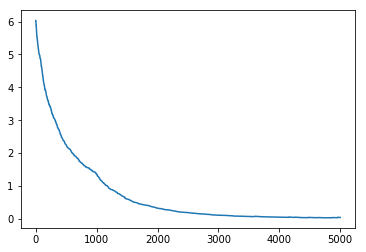

In [285]:
aa=np.arange(epochs)
print(s)
plt.figure()

plt.fill_between(aa, m - s,
                             m + s, alpha=0.1)
plt.plot(aa, m)
plt.fill

## Sarsa

In [58]:
# The implementation of Q_learning algorithm. The input parameters are the discount factor gamma, the learning rate alpha, the 
# parameter epsilon of greedy research, the number of iterations epochs and the reward matrix R. P corresponds to the 
# probability of having a broken robot, thus staying to the same state with probability P.
def SARSA(gamma, alpha, epsilon, epochs, R, Q_star, P = None):
    
    Q_check = np.zeros(epochs)
    std_Q_check = np.zeros_like(Q_check)
    
    if P == None:
        P = 0
    Q = np.zeros_like(R)
    
    n_states = Q.shape[1] - 1
    end_state = False
    
    # iterate for the set number of epochs
    for ii in range(epochs):
        # set an arbitrary initial state. Continue if the initial state is also a terminal state.
        LL = []
        s = np.rint(n_states * np.random.rand()).astype(int)
        if s==0 or s==5:
            Q_check[ii] = Q_check[ii-1] 
            continue
                
        # Apply ε-greedy research. The second condition applies for the case of multiple occurences of the max value.
        # Withoout this condition the first occurence would always be returned, meaning that always the agent would take
        # the action left
        t = np.random.rand()
        if t<epsilon or (Q[:,s] == np.amax(Q[:, s]) * np.ones_like(Q[:,s])).all():
            a = np.rint(np.random.rand()).astype(int)
        else:
            a = np.argmax([Q[:,s]])
        
           
        # each episode include a number of steps updating the Q-function until the agent reaches a terminal state, when the
        # running episode ends and we move to the next iteration
        while(not end_state):
            # set current Q function to the value extracted from the previous iteration.
            #Q = np.array(Q_next, copy = True)
            
            s_next = 2*a - 1 + s 
            # Determine the next state based on action a. Then update the Q function.
            # If we get a reward for ending up in a terminal state set end_state to true and continue with the next epoch
            LL.append(np.linalg.norm(Q- Q_star))
            t = np.random.rand()
            if t<epsilon or (Q[:,s_next] == np.amax(Q[:, s_next]) * np.ones_like(Q[:,s_next])).all():
                a_next = np.rint(np.random.rand()).astype(int)
            else:
                a_next = np.argmax(Q[:,s_next])
            
            delta = R[a,s] + gamma * ((1-P)*Q[a_next, s_next] + P*Q[a_next, s]) - Q[a,s]
            Q[a,s] = Q[a,s] + alpha * delta
            #Q_next[a,s] = Q[a,s] + alpha/(ii+1) * (R[a,s] + gamma * max(Q[:,s_next]) - Q[a,s])
            if R[a,s]>0:
                end_state = True   
            s = s_next
            a = a_next
        LL.append(np.linalg.norm(Q-Q_star))
        Q_check[ii] = np.mean(np.array(LL, copy=True))
        std_Q_check[ii] = np.std(np.array(LL, copy=True))
        end_state = False
       
    
    return Q, Q_check, std_Q_check

In [71]:
epochs = 2000
alpha = 0.1
epsilon = 0.2
gamma=0.5

Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
R = np.zeros((2,6))
R[0,1] = 1
R[1,4] = 5

QQ, L,_ = SARSA(gamma, alpha, epsilon, epochs, R, Q_star)
print(QQ)

[[0.         1.         0.49553124 0.44279748 1.11623145 0.        ]
 [0.         0.51027771 1.13980815 2.35650838 5.         0.        ]]


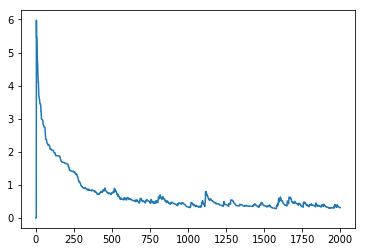

In [72]:
plt.figure()
plt.plot(np.arange(epochs), L)

### Continuous environment - stochastic transition

In [244]:
# Hyperparameters of Q-learning. Number of epochs-iter, epsilon parameter for e-greedy searck, discount factor gamma
# and learning rate alpha for the GD
epochs = 10000
epsilon = 0.3
gamma = 0.5
alpha = 1
lamda = 0.5


# initialization of algorithm parameters. weights for the function approximation.
r = 0
n_states = 5
end_state = False

# parameters of the Gaussian for the noise corruption of state transition. Mean and std
mean_g = 0
sigma_g = 0.1

# statistics
Loss = 0
acc_Reward = 0

# Parameters of the utilized basis functions. Width sigma and c_i is the vector with the centers of the RBF kernels
theta = np.random.rand(13)   # 13: number of kernels x number of actions + 1 bias term
sigma = 0.1
c_i = np.arange(0,6)
#c_i = np.array([1,4])

for ii in range(epochs):
    # set an arbitrary initial state. Continue if the initial state is also a terminal state.
    e = np.zeros_like(theta)
    s = np.rint(n_states * np.random.rand()).astype(int)
    if s==0 or s==5:
            continue
    # Apply ε-greedy research to determine the next action
    t = np.random.rand()
    if t<epsilon:
        a = np.rint(np.random.rand()).astype(int)
    else:
        phi_as = RBF_kernels_norm(c_i, sigma, s, 2)
        a = np.argmax(np.matmul(phi_as, theta))
            
    while(not end_state):
    #for i in range(1):        
            
            
        # derive next continuous state, incorporating the Gaussian noise
        # extract also a discretised next state. each state corresponds to the interval s+-0.5
        #print(e)
        e[a*len(c_i) : (a+1)*len(c_i)] += 1
        e[12] += 1
        #print(e)
        Q = np.matmul(phi_as, theta)
        s_next = 2*a - 1 + s + np.random.normal(mean_g, sigma_g)
        
        
        # Incrementing the counter of interactions with the certain (action, state) for a discretized version of the next state
        # Next update the Q_target approximation, by division with the counter of (action, state)
        #cc[a, s_disc] += 1
        if s_next <0.5 or s_next>=4.5:
            end_state = True
            if s_next < 0.5:
                r = 1
            else:
                r = 5
                
        #delta = r - np.sum(theta[a*len(c_i) : (a+1)*len(c_i)]) - theta[12]      
        delta = r - Q[a]
        
        phi_as_next = RBF_kernels_norm(c_i, sigma, s_next, 2)
        
        # Apply ε-greedy research to determine the next action
        t = np.random.rand()
        if t<epsilon:
            a_next = np.rint(np.random.rand()).astype(int)
        else:
            a_next = np.argmax(np.matmul(phi_as_next, theta))
        
        Q = np.matmul(phi_as_next[a_next, :], theta)
        #Q = np.sum(theta[a_next*len(c_i) : (a_next+1)*len(c_i)]) + theta[12]
        
        delta += gamma*Q
        temp = np.array(theta, copy = True)
        theta += alpha*delta*e
        e = gamma*lamda*e
        
        acc_Reward += r

        
        
        #print(temp,theta)
            
        s = s_next
        a = a_next
        
    end_state = False
    r = 0
    if ii%100 == 0 :
        print('Loss', np.linalg.norm(temp-theta))
        

Loss 2.629800574619949
Loss 3.084924691197245
Loss 3.020249003610918
Loss 3.015510833905695
Loss 2.189559697124437
Loss 14.635270057025723
Loss 2.7227522305405
Loss 3.1560531838082597
Loss 1.6449228098796498
Loss 21.086097173499027
Loss 18.993810983880458
Loss 2.722752196789655
Loss 5.56643482846212
Loss 2.643635955619678
Loss 2.722752204601785
Loss 2.472129950901459
Loss 19.229140450207648
Loss 14.592858924371356
Loss 14.66576307224549
Loss 2.72275221760027
Loss 2.6745676262971427
Loss 4.23966431696853
Loss 2.633525065938703
Loss 18.720184081613784
Loss 3.0301284553637378
Loss 3.0259456492283805
Loss 19.1709365929159
Loss 1.0156972095281314
Loss 1.6235263757844374
Loss 18.723489274381997
Loss 14.899523302142688
Loss 4.249900535873358
Loss 18.723489376134086
Loss 17.758946915287364
Loss 18.723489377403084
Loss 18.909508137328984
Loss 2.643635956721508
Loss 17.722592831649525
Loss 1.8565741793397805
Loss 2.6436359476607048
Loss 2.1895567112968677
Loss 0.6119959432685494
Loss 2.611569490

In [245]:
Q = np.zeros((2,6))
for s in range(6):
    for a in range(2):
        phi = RBF_kernels_norm(c_i, 0.1, s, 2)
        Q[a,s]= np.matmul(theta, phi[a,:])
print(Q)

[[2.94828322 3.30171743 2.80581907 2.71204644 2.67283798 2.96666625]
 [0.98218401 0.67263874 0.81107986 0.88010546 0.70364723 1.44324891]]


In [141]:
bb = np.empty(())
print(bb)


25.0


In [53]:
a = np.random.rand(2,13)
b = np.random.rand(13)

c = np.matmul(a,b)
d = np.amax(c)
print(c, d)

[3.90806461 4.59201795] 4.592017945100274
